In [1]:
import os
import sys
sys.path.append('/nfs/z1/userhome/ChenXiaYu/workingdir/code/MagicBox')
import numpy as np
import pandas as pd
import seaborn as sns
import pickle as pkl
import nibabel as nib
from os.path import join as pjoin
from scipy.stats import sem, zscore, pearsonr, spearmanr
from scipy.spatial.distance import cdist
from scipy.interpolate import CubicSpline
from sklearn.linear_model import LinearRegression
from statsmodels.stats.multitest import multipletests
from matplotlib import pyplot as plt
from cxy_visual_dev.lib.predefine import proj_dir, Atlas, get_rois, mmp_name2label,\
    hemi2stru, hemi2Hemi, meas2color, beh_name2abbr, mmp_map_file, Hemi2stru,\
    s1200_avg_eccentricity, s1200_avg_RFsize, LR_count_32k, s1200_avg_R2
from cxy_visual_dev.lib.algo import AgeSlideWindow
from magicbox.io.io import CiftiReader
from magicbox.stats.outlier import outlier_iqr
from magicbox.stats.tool import summary_across_col_by_mask, print_ps
from magicbox.algo.metric import calc_overlap
from magicbox.vis.plot import prepare_y_bar_line, plot_bar, plot_line,\
    show_bar_value, TickRefinery

anal_dir = pjoin(proj_dir, 'analysis')
work_dir = pjoin(anal_dir, 'plot/line_bar')
if not os.path.isdir(work_dir):
    os.makedirs(work_dir)

# 各种PC与视觉加工层级量化指标之间的相关

## RFsize

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


n_vtx: 2503


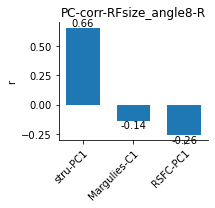

In [5]:
figsize = (3, 3)
mask_type = 'Wang2015'
visual_angle_limit = 8  # None, 8
Hemi = 'R'
out_name =  f'PC-corr-RFsize_angle{visual_angle_limit}-{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
out_file = 'show'

# ===prepare mask===
mask = Atlas('HCP-MMP').get_mask(get_rois(f'MMP-vis3-{Hemi}'))[0]
if mask_type == 'MMP-vis3':
    pass
elif mask_type == 'R2_limit':
    mask_tmp = nib.load(s1200_avg_R2).get_fdata()[0, :LR_count_32k] > 9.8
    mask = np.logical_and(mask, mask_tmp)
elif mask_type == 'Wang2015':
    mask_tmp = Atlas('Wang2015').get_mask(get_rois(f'Wang2015-{Hemi}'))[0]
    mask = np.logical_and(mask, mask_tmp)
else:
    raise ValueError('unsupported mask_type:', mask_type)

# ===prepare gradient maps===
# 结构梯度的PC1
map_stru_pc = nib.load(pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names = ['stru-PC1']
grad_maps = [map_stru_pc]

# Margulies gradient
map_margulies_c = nib.load(pjoin(
    proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
    'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii'
)).get_fdata()[0, mask][None, :]
grad_names.append('Margulies-C1')
grad_maps.append(map_margulies_c)

# RSFC矩阵的PCA成分
reader = CiftiReader(pjoin(
    anal_dir, 'decomposition/'
    f'S1200-grp-RSFC-z_MMP-vis3-{Hemi}2MMP-vis3-{Hemi}_zscore_PCA-comp.dscalar.nii'))
map_rsfc_c = reader.get_data()[0, :LR_count_32k][mask][None, :]
grad_names.append(f'RSFC-P{reader.map_names()[0]}')
grad_maps.append(map_rsfc_c)

grad_maps = np.concatenate(grad_maps, 0)
n_grad = len(grad_names)

# ===prepare retinotopic map===
map_meas = nib.load(s1200_avg_RFsize).get_fdata()[0, :LR_count_32k]
map_meas = map_meas[mask]

if visual_angle_limit is not None:
    angle_mask = map_meas <= visual_angle_limit
    grad_maps = grad_maps[:, angle_mask]
    map_meas = map_meas[angle_mask]
print('n_vtx:', map_meas.shape[0])

y = np.zeros(n_grad)
for grad_idx in range(n_grad):
    y[grad_idx] = pearsonr(map_meas, grad_maps[grad_idx])[0]

plot_bar(y, 1, 1, figsize, show_height='.2f',
         xticklabel=tuple(grad_names), rotate_xticklabel=True,
         ylabel='r', title=out_name, mode=out_file)


## Hierarchical Rank

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


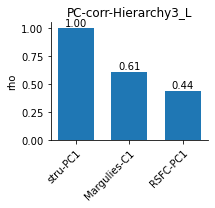

In [3]:
Hemi = 'L'
path_name = 'Hierarchy3'
figsize = (3, 3)
rois_plot = get_rois(path_name)
rois = [f'{Hemi}_{i}' for i in rois_plot]
out_name = f'PC-corr-{path_name}_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

# ===prepare PC maps===
# 结构梯度的PC1, PC2: stru-C1, stru-C2;
map_stru_pc = nib.load(pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj.dscalar.nii'
)).get_fdata()[[0]]
pc_names = ['stru-PC1']
pc_maps = [map_stru_pc]

# Margulies gradient
map_margulies_c = nib.load(pjoin(
    proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
    'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii'
)).get_fdata()[[0]]
pc_names.append('Margulies-C1')
pc_maps.append(map_margulies_c)

# RSFC矩阵的PCA成分
reader = CiftiReader(pjoin(
    anal_dir, 'decomposition/'
    f'S1200-grp-RSFC-z_MMP-vis3-{Hemi}2MMP-vis3-{Hemi}_zscore_PCA-comp.dscalar.nii'))
map_rsfc_pc = reader.get_data()[[0], :LR_count_32k]
pc_names.append(f'RSFC-P{reader.map_names()[0]}')
pc_maps.append(map_rsfc_pc)

pc_maps = np.concatenate(pc_maps, 0)
n_pc_map = len(pc_names)

# ===prepare data===
n_roi = len(rois)
x = np.arange(1, n_roi+1)
atlas = Atlas('HCP-MMP')
rs = np.zeros(n_pc_map)
for pc_idx in range(n_pc_map):
    y =  np.zeros(n_roi)
    for roi_idx, roi in enumerate(rois):
        roi_mask = atlas.get_mask(roi)[0]
        y[roi_idx] = np.mean(pc_maps[pc_idx][roi_mask])
    rs[pc_idx] = spearmanr(x, y, alternative='two-sided')[0]

plot_bar(rs, 1, 1, figsize, show_height='.2f',
         xticklabel=tuple(pc_names), rotate_xticklabel=True,
         ylabel='rho', title=out_name, mode=out_file)

# PC12 corr margulies

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


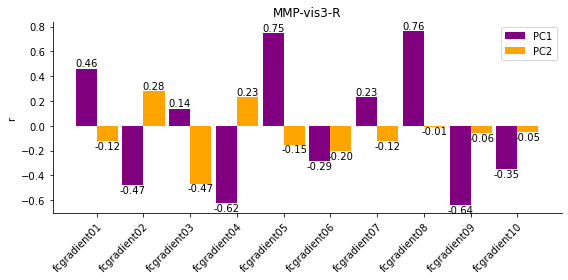

In [3]:
figsize = (8, 4)
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
fc_grad_file=pjoin(proj_dir, 'data/neuromaps-data/annotations/margulies2016/'
                   'source-margulies2016_space-fsLR_den-32k_feature.dscalar.nii')
out_file = pjoin(work_dir, f'PC1+2-corr-Margulies-grad_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
pc_maps = nib.load(pc_file).get_fdata()[:n_pc, vis_mask]
reader = CiftiReader(fc_grad_file)
fc_grad_maps = reader.get_data()[:, vis_mask]
xticklabels = tuple(reader.map_names())
n_fc_grad = len(xticklabels)

ys = np.zeros((n_pc, n_fc_grad))
for pc_idx in range(n_pc):
    for fc_grad_idx in range(n_fc_grad):
        r, p = pearsonr(pc_maps[pc_idx], fc_grad_maps[fc_grad_idx])
        ys[pc_idx, fc_grad_idx] = r

colors = tuple(meas2color[i] for i in pc_names)
plot_bar(ys, 1, 1, figsize, label=pc_names, color=colors, show_height='.2f',
         xticklabel=xticklabels, rotate_xticklabel=True, ylabel='r',
         title=vis_name, mode=out_file)

# 画不同通路内的梯度的变异程度

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


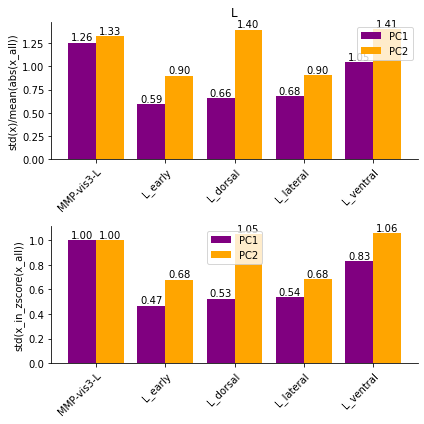

In [3]:
figsize = (6, 6)

Hemi = 'L'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
pc_file = pjoin(
    anal_dir,
    f'decomposition/HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, f'grad-var_{Hemi}.jpg')
# out_file = 'show'

# loading
vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
n_pc = len(pc_names)
pc_maps = nib.load(pc_file).get_fdata()[:n_pc, vis_mask]
pc_scales = np.mean(np.abs(pc_maps), 1)
pc_maps_z = zscore(pc_maps, 1)

# doing
n_mask = len(mask_names)
ys = np.zeros((n_pc, n_mask))
ys_z = np.zeros((n_pc, n_mask))
for mask_idx, mask_name in enumerate(mask_names):
    # prepare data in mask
    if mask_name == vis_name:
        pc_data = pc_maps
        pc_data_z = pc_maps_z
    else:
        mask = atlas.get_mask(mask_name)[0]
        mask = mask[vis_mask]
        pc_data = pc_maps[:, mask]
        pc_data_z = pc_maps_z[:, mask]

    # calculate variation
    ys[:, mask_idx] = np.std(pc_data, 1, ddof=1) / pc_scales
    ys_z[:, mask_idx] = np.std(pc_data_z, 1, ddof=1)

# plot
colors = tuple(meas2color[i] for i in pc_names)
ylabels = ['std(x)/mean(abs(x_all))', 'std(x_in_zscore(x_all))']
xticklabels = tuple(mask_names)
plot_bar([ys, ys_z], 2, 1, figsize, label=[pc_names]*2, color=[colors]*2,
         show_height='.2f', xticklabel=xticklabels, rotate_xticklabel=True,
         ylabel=ylabels, title=Hemi, mode=out_file)


# 以两两顶点测地距离作为限制

## 以物理单位（毫米）由小到大均分成几份

### 展示各部分的PC1距离和PC2距离的mean和sem (line)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


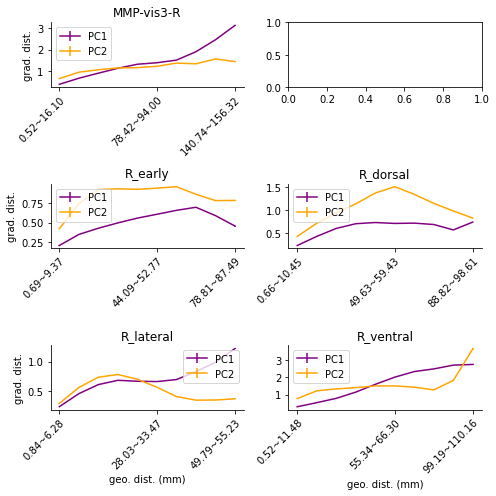

In [7]:
n_row, n_col = 3, 2
figsize = (7, 7)
n_seg = 10  # 10, 40, 80

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, f'grad-dist_vs_geo-dist-mm_seg{n_seg}_{Hemi}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx'] - offset
assert np.all(tmp1 == hemi_idx2vtx[tmp2])
row_idx2std_idx = grad_dist['row-idx_to_32k-fs-LR-idx'].tolist()

x = np.arange(n_seg)
n_pc = len(pc_names)
local_idx = 0
fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
for mask_name in mask_names:
    # prepare data in mask
    if mask_name == vis_name:
        row_idx, col_idx = 0, 0
        geo_dist_arr = geo_dist['gdist']
        grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]
    else:
        row_idx = int(local_idx / n_col) + 1
        col_idx = local_idx % n_col
        local_idx += 1
        mask = atlas.get_mask(mask_name)[0]
        mask_indices = np.where(mask)[0]
        row_indices = [row_idx2std_idx.index(i) for i in mask_indices]
        geo_dist_arr = geo_dist['gdist'][row_indices][:, row_indices]
        grad_dist_arrs = [grad_dist[f'{i}-zscore'][row_indices][:, row_indices] for i in pc_names]
    ax = axes[row_idx, col_idx]

    # prepare segments
    n_vtx = geo_dist_arr.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    geo_dist_vec = geo_dist_arr[idx_mat]
    geo_dist_min = np.min(geo_dist_vec)
    geo_dist_max = np.max(geo_dist_vec)
    geo_seg_borders = np.linspace(geo_dist_min, geo_dist_max, n_seg+1, endpoint=True)
    assert geo_seg_borders.min() == geo_dist_min and geo_seg_borders.max() == geo_dist_max

    # mask gradient distance
    grad_dist_vecs = [i[idx_mat] for i in grad_dist_arrs]
    ys = np.zeros((n_pc, n_seg))
    yerrs = np.zeros((n_pc, n_seg))
    for idx, geo_seg_s in enumerate(geo_seg_borders[:-1]):
        geo_seg_e = geo_seg_borders[idx + 1]
        if idx == n_seg-1:
            assert geo_seg_e == geo_dist_max
            geo_mask = np.logical_and(
                geo_dist_vec >= geo_seg_s,
                geo_dist_vec <= geo_seg_e)
        else:
            geo_mask = np.logical_and(
                geo_dist_vec >= geo_seg_s,
                geo_dist_vec < geo_seg_e)

        for pc_idx in range(n_pc):
            pc_dist = grad_dist_vecs[pc_idx][geo_mask]
            ys[pc_idx, idx] = np.mean(pc_dist)
            yerrs[pc_idx, idx] = sem(pc_dist)
    xticks = (0, int(n_seg/2), n_seg-1)
    xticklabels = tuple('{:.2f}~{:.2f}'.format(geo_seg_borders[i], geo_seg_borders[i+1])
                        for i in xticks)

    # plot
    for pc_idx, pc_name in enumerate(pc_names):
        ax.errorbar(x, ys[pc_idx], yerrs[pc_idx], label=pc_name, color=meas2color[pc_name])
    ax.legend()
    ax.set_title(mask_name)
    if row_idx == n_row-1:
        ax.set_xlabel('geo. dist. (mm)')
    if col_idx == 0:
        ax.set_ylabel('grad. dist.')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)


### 在各部分均分的空间范围内，首先逐顶点总结其与范围内的顶点的梯度距离的mean统计值，然后跨顶点计算该统计值的mean和sem (line)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


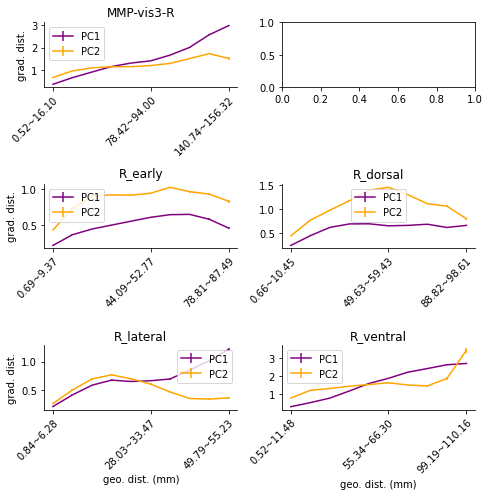

In [7]:
n_row, n_col = 3, 2
figsize = (7, 7)
n_seg = 10  # 10, 40, 80

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, f'grad-dist_vs_geo-dist-mm1_seg{n_seg}_{Hemi}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx'] - offset
assert np.all(tmp1 == hemi_idx2vtx[tmp2])
row_idx2std_idx = grad_dist['row-idx_to_32k-fs-LR-idx'].tolist()

x = np.arange(n_seg)
n_pc = len(pc_names)
local_idx = 0
fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
for mask_name in mask_names:
    # prepare data in mask
    if mask_name == vis_name:
        row_idx, col_idx = 0, 0
        geo_dist_arr = geo_dist['gdist']
        grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]
    else:
        row_idx = int(local_idx / n_col) + 1
        col_idx = local_idx % n_col
        local_idx += 1
        mask = atlas.get_mask(mask_name)[0]
        mask_indices = np.where(mask)[0]
        row_indices = [row_idx2std_idx.index(i) for i in mask_indices]
        geo_dist_arr = geo_dist['gdist'][row_indices][:, row_indices]
        grad_dist_arrs = [grad_dist[f'{i}-zscore'][row_indices][:, row_indices] for i in pc_names]
    ax = axes[row_idx, col_idx]

    # prepare segments
    n_vtx = geo_dist_arr.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    geo_dist_vec = geo_dist_arr[idx_mat]
    geo_dist_min = np.min(geo_dist_vec)
    geo_dist_max = np.max(geo_dist_vec)
    geo_seg_borders = np.linspace(geo_dist_min, geo_dist_max, n_seg+1, endpoint=True)
    assert geo_seg_borders.min() == geo_dist_min and geo_seg_borders.max() == geo_dist_max

    # mask gradient distance
    ys = np.zeros((n_pc, n_seg))
    yerrs = np.zeros((n_pc, n_seg))
    for idx, geo_seg_s in enumerate(geo_seg_borders[:-1]):
        geo_seg_e = geo_seg_borders[idx + 1]
        if idx == n_seg-1:
            assert geo_seg_e == geo_dist_max
            geo_mask = np.logical_and(
                geo_dist_arr >= geo_seg_s,
                geo_dist_arr <= geo_seg_e)
        else:
            geo_mask = np.logical_and(
                geo_dist_arr >= geo_seg_s,
                geo_dist_arr < geo_seg_e)

        row_data_list = [[], []]
        for vtx_idx in range(n_vtx):
            row_mask = geo_mask[vtx_idx]
            n_valid = np.sum(row_mask)
            if n_valid > 0:
                for pc_idx in range(n_pc):
                    pc_dist = grad_dist_arrs[pc_idx][vtx_idx][row_mask]
                    row_data_list[pc_idx].append(np.mean(pc_dist))
        for pc_idx in range(n_pc):
            ys[pc_idx, idx] = np.mean(row_data_list[pc_idx])
            yerrs[pc_idx, idx] = sem(row_data_list[pc_idx])
    xticks = (0, int(n_seg/2), n_seg-1)
    xticklabels = tuple('{:.2f}~{:.2f}'.format(geo_seg_borders[i], geo_seg_borders[i+1])
                        for i in xticks)

    # plot
    for pc_idx, pc_name in enumerate(pc_names):
        ax.errorbar(x, ys[pc_idx], yerrs[pc_idx], label=pc_name, color=meas2color[pc_name])
    ax.legend()
    ax.set_title(mask_name)
    if row_idx == n_row-1:
        ax.set_xlabel('geo. dist. (mm)')
    if col_idx == 0:
        ax.set_ylabel('grad. dist.')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)


## 将所有顶点对以测地距离由小到大排列，然后均匀分成几份

### 展示各部分的PC1距离和PC2距离的mean和sem (bar)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


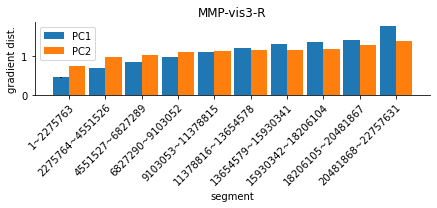

In [8]:
figsize = (6.4, 3)
n_seg = 10

# figsize = (7, 3)
# n_seg = 20

# figsize = (9, 3)
# n_seg = 40

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, f'grad-dist_vs_geo-dist1_seg{n_seg}_{Hemi}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx'] - offset
assert np.all(tmp1 == hemi_idx2vtx[tmp2])

# prepare segments
n_vtx = len(tmp1)
idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
geo_dist_vec = geo_dist['gdist'][idx_mat]
n_pair = len(geo_dist_vec)
sort_indices = np.argsort(geo_dist_vec)
seg_indices = np.linspace(0, n_pair, n_seg+1, endpoint=True, dtype=int)

# mask gradient distance
n_pc = len(pc_names)
grad_dist_vecs = [grad_dist[f'{i}-zscore'][idx_mat] for i in pc_names]
ys = np.zeros((n_pc, n_seg))
yerrs = np.zeros((n_pc, n_seg))
xticklabels = []
for idx, seg_idx_s in enumerate(seg_indices[:-1]):
    seg_idx_e = seg_indices[idx + 1]
    indices = sort_indices[seg_idx_s:seg_idx_e]
    xticklabels.append(f'{seg_idx_s+1}~{seg_idx_e}')
    for pc_idx in range(n_pc):
        pc_dist = grad_dist_vecs[pc_idx][indices]
        ys[pc_idx, idx] = np.mean(pc_dist)
        yerrs[pc_idx, idx] = sem(pc_dist)
xticklabels = tuple(xticklabels)

# plot
plot_bar(ys, 1, 1, figsize, yerrs, label=pc_names,
         xlabel='segment', xticklabel=xticklabels, rotate_xticklabel=True,
         ylabel='gradient dist.', title=vis_name, mode=out_file)

### 展示各部分的PC1距离和PC2距离的mean和sem (line)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


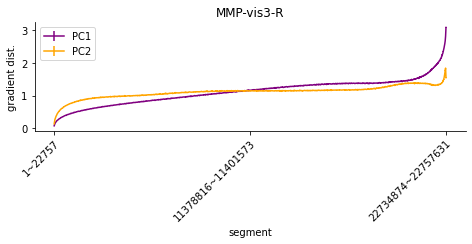

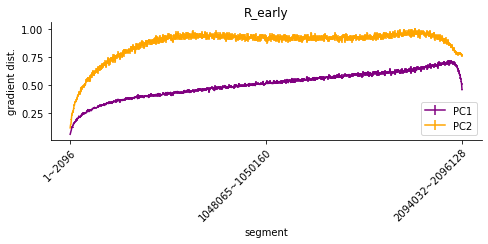

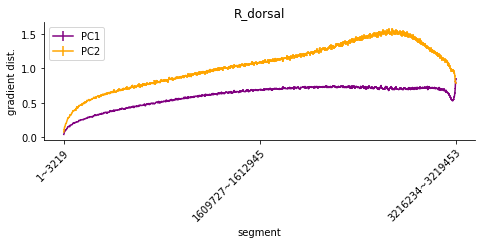

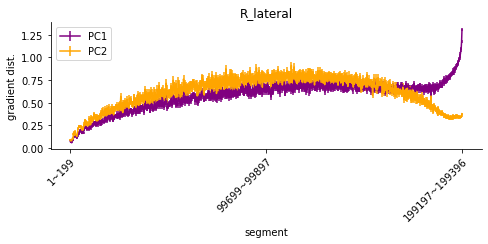

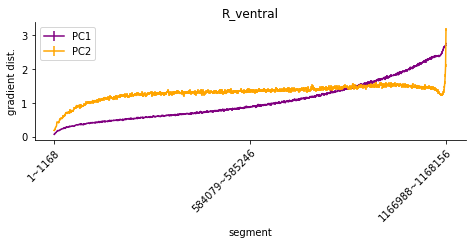

In [3]:
observe_first_seg_num = None
yerr_flag = True
figsize = (6.8, 3.5)
n_seg = 1000

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, 'grad-dist_vs_geo-dist2_seg{n_seg}_{mask_name}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx'] - offset
assert np.all(tmp1 == hemi_idx2vtx[tmp2])
row_idx2std_idx = grad_dist['row-idx_to_32k-fs-LR-idx'].tolist()

n_pc = len(pc_names)
for mask_name in mask_names:
    # prepare data in mask
    if mask_name == vis_name:
        geo_dist_arr = geo_dist['gdist']
        grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]
    else:
        mask = atlas.get_mask(mask_name)[0]
        mask_indices = np.where(mask)[0]
        row_indices = [row_idx2std_idx.index(i) for i in mask_indices]
        geo_dist_arr = geo_dist['gdist'][row_indices][:, row_indices]
        grad_dist_arrs = [grad_dist[f'{i}-zscore'][row_indices][:, row_indices] for i in pc_names]

    # prepare segments
    n_vtx = geo_dist_arr.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    geo_dist_vec = geo_dist_arr[idx_mat]
    n_pair = len(geo_dist_vec)
    sort_indices = np.argsort(geo_dist_vec)
    seg_indices = np.linspace(0, n_pair, n_seg+1, endpoint=True, dtype=int)

    # observe the first 'observe_first_seg_num' segments
    if observe_first_seg_num is not None:
        n_seg = observe_first_seg_num
        seg_indices = seg_indices[:(n_seg+1)]

    # mask gradient distance
    grad_dist_vecs = [i[idx_mat] for i in grad_dist_arrs]
    ys = np.zeros((n_pc, n_seg))
    yerrs = np.zeros((n_pc, n_seg))
    for idx, seg_idx_s in enumerate(seg_indices[:-1]):
        seg_idx_e = seg_indices[idx + 1]
        indices = sort_indices[seg_idx_s:seg_idx_e]
        for pc_idx in range(n_pc):
            pc_dist = grad_dist_vecs[pc_idx][indices]
            ys[pc_idx, idx] = np.mean(pc_dist)
            yerrs[pc_idx, idx] = sem(pc_dist)
    xticks = (0, int(n_seg/2), n_seg-1)
    xticklabels = tuple(f'{seg_indices[i]+1}~{seg_indices[i+1]}' for i in xticks)

    # plot
    colors = tuple(meas2color[i] for i in pc_names)
    x = np.arange(n_seg)
    if not yerr_flag:
        yerrs = None
    plot_line(ys, 1, 1, figsize, yerrs, x, label=pc_names, color=colors,
              xlabel='segment',xtick=xticks, xticklabel=xticklabels,
              rotate_xticklabel=True, ylabel='gradient dist.',
              title=mask_name, mode=out_file.format(n_seg=n_seg, mask_name=mask_name))

### 在各部分均分的空间范围内，首先逐顶点总结其与范围内的顶点的mean/max/std统计值，然后跨顶点计算该统计值的mean和sem (line)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


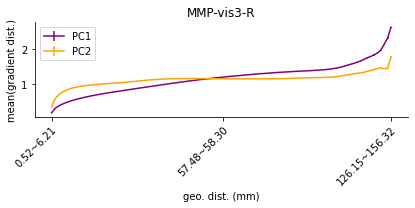

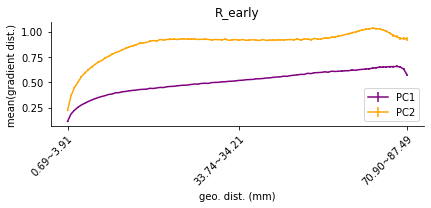

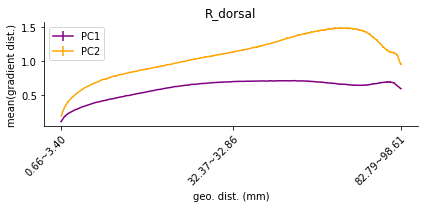

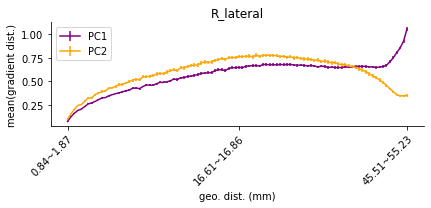

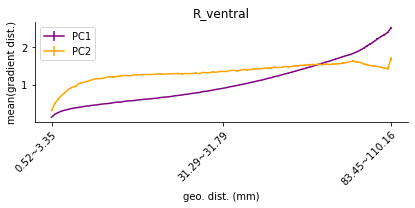

In [3]:
metric = 'mean'  # mean, max, std
grad_dist_type = 'dist'  # dist, diff

# metric = 'max'  # mean, max, std
# grad_dist_type = 'dist'  # dist, diff

# metric = 'std'  # mean, max, std
# grad_dist_type = 'diff'  # dist, diff

mm_unit = True
observe_first_seg_num = None
yerr_flag = True
figsize = (6, 3)
n_seg = 100

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
if grad_dist_type == 'dist':
    grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
elif grad_dist_type == 'diff':
    grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_diff_{vis_name}.pkl')
else:
    raise ValueError
out_file = pjoin(work_dir, 'grad-{grad_dist_type}_vs_geo-dist_row-{metric}_seg{n_seg}_{mask_name}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx']
assert np.all(tmp1 == hemi_idx2vtx[tmp2-offset])
row_idx2std_idx = grad_dist['row-idx_to_32k-fs-LR-idx'].tolist()

n_pc = len(pc_names)
colors = tuple(meas2color[i] for i in pc_names)
for mask_name in mask_names:
    # prepare data in mask
    if mask_name == vis_name:
        geo_dist_arr = geo_dist['gdist']
        grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]
    else:
        mask = atlas.get_mask(mask_name)[0]
        mask_indices = np.where(mask)[0]
        row_indices = [row_idx2std_idx.index(i) for i in mask_indices]
        geo_dist_arr = geo_dist['gdist'][row_indices][:, row_indices]
        grad_dist_arrs = [grad_dist[f'{i}-zscore'][row_indices][:, row_indices] for i in pc_names]

    # prepare segments
    n_vtx = geo_dist_arr.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    geo_dist_vec = geo_dist_arr[idx_mat]
    n_pair = len(geo_dist_vec)
    sort_indices = np.argsort(geo_dist_vec)
    seg_indices = np.linspace(0, n_pair, n_seg+1, endpoint=True, dtype=int)

    # observe the first 'observe_first_seg_num' segments
    if observe_first_seg_num is not None:
        n_seg = observe_first_seg_num
        seg_indices = seg_indices[:(n_seg+1)]

    # mask gradient distance
    ys = np.zeros((n_pc, n_seg))
    yerrs = np.zeros((n_pc, n_seg))
    for idx, seg_idx_s in enumerate(seg_indices[:-1]):
        seg_idx_e = seg_indices[idx + 1]
        indices = sort_indices[seg_idx_s:seg_idx_e]
        geo_mask_vec = np.zeros(n_pair, dtype=bool)
        geo_mask_vec[indices] = True
        geo_mask_arr = np.zeros((n_vtx, n_vtx), dtype=bool)
        geo_mask_arr[idx_mat] = geo_mask_vec
        geo_mask_arr = np.logical_or(geo_mask_arr, geo_mask_arr.T)
        for pc_idx in range(n_pc):
            pc_dist_arr = grad_dist_arrs[pc_idx]
            pc_dist_vec = []
            for vtx_idx in range(n_vtx):
                row_data = pc_dist_arr[vtx_idx][geo_mask_arr[vtx_idx]]
                n_valid = len(row_data)
                if metric == 'mean' and n_valid > 0:
                    pc_dist_vec.append(np.mean(row_data))
                elif metric == 'max' and n_valid > 0:
                    pc_dist_vec.append(np.max(row_data))
                elif metric == 'std' and n_valid > 1:
                    pc_dist_vec.append(np.std(row_data, ddof=1))
            ys[pc_idx, idx] = np.mean(pc_dist_vec)
            yerrs[pc_idx, idx] = sem(pc_dist_vec)
    xticks = (0, int(n_seg/2), n_seg-1)
    if mm_unit:
        xticklabels = []
        for xtick in xticks:
            seg_idx_s = seg_indices[xtick]
            seg_idx_e = seg_indices[xtick + 1] - 1
            geo_dist_idx1 = sort_indices[seg_idx_s]
            geo_dist_idx2 = sort_indices[seg_idx_e]
            xticklabels.append('{:.2f}~{:.2f}'.format(
                geo_dist_vec[geo_dist_idx1], geo_dist_vec[geo_dist_idx2]))
        xlabel = 'geo. dist. (mm)'
        xticklabels = tuple(xticklabels)
    else:
        xticklabels = tuple(f'{seg_indices[i]+1}~{seg_indices[i+1]}' for i in xticks)
        xlabel='segment'

    # plot
    x = np.arange(n_seg)
    if not yerr_flag:
        yerrs = None
    plot_line(ys, 1, 1, figsize, yerrs, x, label=pc_names, color=colors,
              xlabel=xlabel,xtick=xticks, xticklabel=xticklabels,
              rotate_xticklabel=True, ylabel=f'{metric}(gradient {grad_dist_type}.)',
              title=mask_name, mode=out_file.format(
                  grad_dist_type=grad_dist_type, metric=metric,
                  n_seg=n_seg, mask_name=mask_name))

### 展示各部分梯度距离和RSFC的相关(line)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


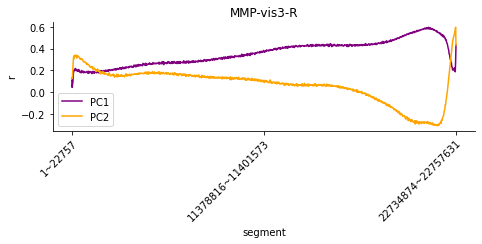

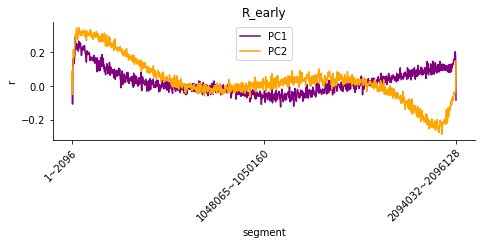

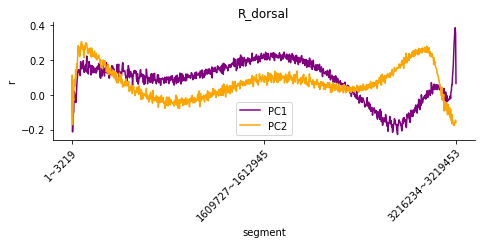

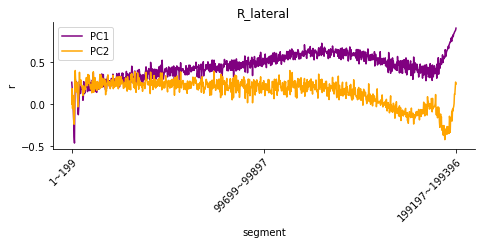

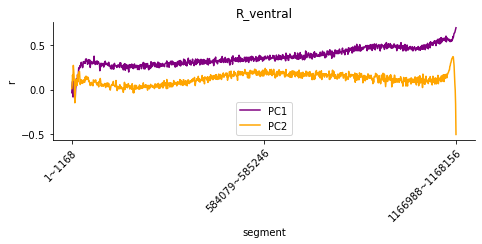

In [3]:
rsfc_dist_flag = True
figsize = (6.8, 3.5)
n_seg = 1000

Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
mask_names = ['early', 'dorsal', 'lateral', 'ventral']
mask_names = [vis_name] + [f'{Hemi}_{i}' for i in mask_names]
atlas = Atlas('MMP-vis3-EDLV')
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
rsfc_file = pjoin(proj_dir, f'data/HCP/HCPY-avg_RSFC-{vis_name}.pkl')
out_file = pjoin(work_dir, 'grad-dist-corr-rsfc_vs_geo-dist2_seg{n_seg}_{mask_name}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
rsfc_dict = pkl.load(open(rsfc_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx']
tmp3 = rsfc_dict['row-idx_to_32k-fs-LR-idx']
assert np.all(tmp1 == hemi_idx2vtx[tmp2-offset])
assert np.all(tmp2 == tmp3)
row_idx2std_idx = tmp2.tolist()

n_pc = len(pc_names)
rsfc_arr_all = rsfc_dict['matrix']
if rsfc_dist_flag:
    rsfc_arr_all = 1 - rsfc_arr_all
for mask_name in mask_names:
    # prepare data in mask
    if mask_name == vis_name:
        geo_dist_arr = geo_dist['gdist']
        grad_dist_arrs = [grad_dist[i] for i in pc_names]
        rsfc_arr = rsfc_arr_all
    else:
        mask = atlas.get_mask(mask_name)[0]
        mask_indices = np.where(mask)[0]
        row_indices = [row_idx2std_idx.index(i) for i in mask_indices]
        geo_dist_arr = geo_dist['gdist'][row_indices][:, row_indices]
        grad_dist_arrs = [grad_dist[i][row_indices][:, row_indices] for i in pc_names]
        rsfc_arr = rsfc_arr_all[row_indices][:, row_indices]

    # prepare segments
    n_vtx = geo_dist_arr.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    geo_dist_vec = geo_dist_arr[idx_mat]
    n_pair = len(geo_dist_vec)
    sort_indices = np.argsort(geo_dist_vec)
    seg_indices = np.linspace(0, n_pair, n_seg+1, endpoint=True, dtype=int)

    # mask gradient distance
    grad_dist_vecs = [i[idx_mat] for i in grad_dist_arrs]
    rsfc_vec = rsfc_arr[idx_mat]
    ys = np.zeros((n_pc, n_seg))
    for idx, seg_idx_s in enumerate(seg_indices[:-1]):
        seg_idx_e = seg_indices[idx + 1]
        indices = sort_indices[seg_idx_s:seg_idx_e]
        rsfc_data = rsfc_vec[indices]
        for pc_idx in range(n_pc):
            pc_data = grad_dist_vecs[pc_idx][indices]
            ys[pc_idx, idx] = pearsonr(rsfc_data, pc_data)[0]
    xticks = (0, int(n_seg/2), n_seg-1)
    xticklabels = tuple(f'{seg_indices[i]+1}~{seg_indices[i+1]}' for i in xticks)

    # plot
    colors = tuple(meas2color[i] for i in pc_names)
    x = np.arange(n_seg)
    ylabel = 'r'
    plot_line(ys, 1, 1, figsize, x=x, label=pc_names, color=colors,
            xlabel='segment',xtick=xticks, xticklabel=xticklabels,
            rotate_xticklabel=True, ylabel=ylabel,
            title=mask_name, mode=out_file.format(n_seg=n_seg, mask_name=mask_name))


### CubicSpline拟合测地距离和梯度距离的关系

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


x.min: 0.5187799681196339
PC1 y.min: 4.9986074307506456e-08
PC2 y.min: 2.903929940956118e-08


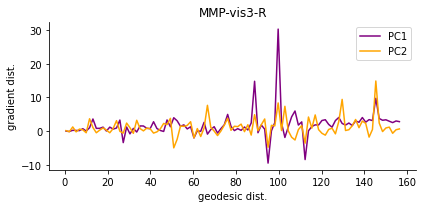

In [2]:
iqr_coef = None  ## None, float
n_x_plot = 100  # 100, 10000
figsize = (6, 3)
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
geo_dist_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
grad_dist_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
out_file = pjoin(work_dir, f'grad-dist_vs_geo-dist_CubicSpline_{Hemi}.jpg')
# out_file = 'show'

# loading
geo_dist = pkl.load(open(geo_dist_file, 'rb'))
grad_dist = pkl.load(open(grad_dist_file, 'rb'))
offset, _, _, hemi_idx2vtx = CiftiReader(mmp_map_file).get_stru_pos(Hemi2stru[Hemi])
hemi_idx2vtx = np.array(hemi_idx2vtx)
tmp1 = geo_dist[f'vtx_number_in_32k_fs_{Hemi}']
tmp2 = grad_dist['row-idx_to_32k-fs-LR-idx']
assert np.all(tmp1 == hemi_idx2vtx[tmp2-offset])

n_pc = len(pc_names)
colors = tuple(meas2color[i] for i in pc_names)
geo_dist_arr = geo_dist['gdist']
grad_dist_arrs = [grad_dist[f'{i}-zscore'] for i in pc_names]

n_vtx = geo_dist_arr.shape[0]
idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
geo_dist_vec = geo_dist_arr[idx_mat]
sort_indices = np.argsort(geo_dist_vec)
x = geo_dist_vec[sort_indices]
x_plot = np.linspace(x[0], x[-1], n_x_plot, endpoint=True)

y_plot = np.zeros((n_pc, n_x_plot))
print('x.min:', x.min())
for pc_idx, pc_name in enumerate(pc_names):
    y = grad_dist_arrs[pc_idx][idx_mat][sort_indices]
    print(f'{pc_name} y.min:', y.min())
    cs = CubicSpline(x, y)
    y_plot[pc_idx] = cs(x_plot)

if iqr_coef is not None:
    # to be refined
    non_outlier_mask = ~outlier_iqr(y_plot, iqr_coef)
    x_plot = x_plot[non_outlier_mask]
    y_plot = y_plot[non_outlier_mask]
plot_line(y_plot, 1, 1, figsize, x=x_plot, label=pc_names, color=colors,
          xlabel='geodesic dist.', ylabel='gradient dist.',
          title=vis_name, mode=out_file)

# 把不同梯度距离与RSFC在不同通路内的相关画到同一ax里

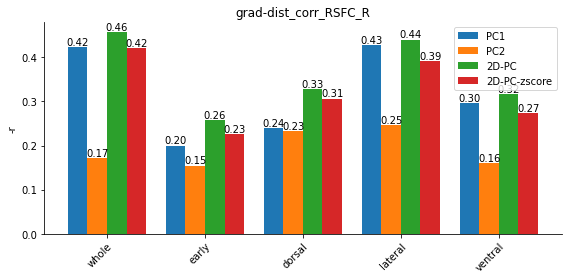

In [2]:
figsize = (8, 4)
Hemi = 'R'  # L or R
vis_name = f'MMP-vis3-{Hemi}'
atlas = Atlas('MMP-vis3-EDLV')
grad_names = ('PC1', 'PC2', '2D-PC', '2D-PC-zscore')
mask_names = ('whole', 'early', 'dorsal', 'lateral', 'ventral')
grad_file = pjoin(anal_dir, f'grad_dist/grad_dist_{vis_name}.pkl')
rsfc_file = pjoin(proj_dir, f'data/HCP/HCPY-avg_RSFC-{vis_name}.pkl')
out_name = f'grad-dist_corr_RSFC_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

grad_dict = pkl.load(open(grad_file, 'rb'))
rsfc_dict = pkl.load(open(rsfc_file, 'rb'))
vis_vertices = grad_dict['row-idx_to_32k-fs-LR-idx']
assert np.all(vis_vertices == rsfc_dict['row-idx_to_32k-fs-LR-idx'])
vis_vertices = vis_vertices.tolist()

n_grad = len(grad_names)
n_mask = len(mask_names)
ys = np.zeros((n_grad, n_mask))
for mask_idx, mask_name in enumerate(mask_names):
    rsfc_mat = rsfc_dict['matrix']
    if mask_name != 'whole':
        mask = atlas.get_mask(f'{Hemi}_{mask_name}')[0]
        mask_vertices = np.where(mask)[0]
        mask_indices = [vis_vertices.index(i) for i in mask_vertices]
        rsfc_mat = rsfc_mat[mask_indices][:, mask_indices]
    n_vtx = rsfc_mat.shape[0]
    idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
    rsfc_vec = rsfc_mat[idx_mat]
    for grad_idx, grad_name in enumerate(grad_names):
        grad_mat = grad_dict[grad_name]
        if mask_name != 'whole':
            grad_mat = grad_mat[mask_indices][:, mask_indices]
        grad_vec = grad_mat[idx_mat]
        r, p = pearsonr(grad_vec, rsfc_vec)
        ys[grad_idx, mask_idx] = -r

plot_bar(ys, figsize=figsize, label=grad_names, xticklabel=mask_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='-r', mode=out_file, title=out_name)

# Plot RSA

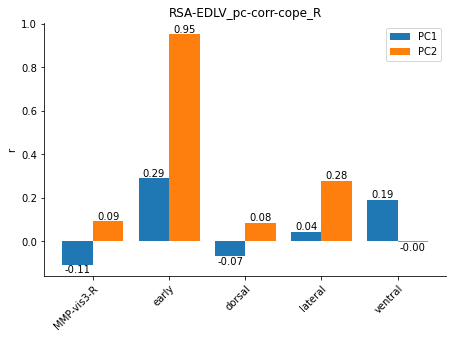

In [4]:
figsize = (6.4, 4.8)
Hemi = 'R'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('PC1', 'PC2')
pc_rdm_file = pjoin(anal_dir, f'RSA/{vis_name}-EDLV_RDM-PC12.pkl')
cope_rdm_file = pjoin(anal_dir, f'RSA/{vis_name}-EDLV_RDM-WM-cope.pkl')
mask_names = (vis_name, 'early', 'dorsal', 'lateral', 'ventral')
out_name = f'RSA-EDLV_pc-corr-cope_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
pc_rdm_dict = pkl.load(open(pc_rdm_file, 'rb'))
cope_rdm_dict = pkl.load(open(cope_rdm_file, 'rb'))
n_mask = len(mask_names)
ys = np.zeros((n_pc, n_mask))
for mask_idx, mask_name in enumerate(mask_names):
    cope_rdm = cope_rdm_dict[mask_name]
    n_roi = cope_rdm.shape[0]
    tri_idx_arr = np.tri(n_roi, k=-1, dtype=bool).T
    cope_vec = cope_rdm[tri_idx_arr]
    for pc_idx, pc_name in enumerate(pc_names):
        pc_rdm = pc_rdm_dict[mask_name][pc_name]
        pc_vec = pc_rdm[tri_idx_arr]
        ys[pc_idx, mask_idx] = pearsonr(pc_vec, cope_vec)[0]

plot_bar(ys, n_row=1, n_col=1, figsize=figsize, 
         label=pc_names, show_height='.2f',
         xticklabel=mask_names, rotate_xticklabel=True,
         ylabel='r', title=out_name, mode=out_file)

# Plot retinotopy

## PC12_corr_retinotopy_roi1/3

n_r_type x n_pc
L-r:
 [[ 0.89232667 -0.19663543]
 [ 0.03236526 -0.05730676]]

L-p:
 [[5.46592737e-08 3.92935587e-01]
 [1.02733021e-01 3.84226019e-03]]
R-r:
 [[ 0.72267787  0.25522849]
 [ 0.0673745  -0.07466118]]

R-p:
 [[1.45323554e-04 2.51645807e-01]
 [7.67893749e-04 1.92302199e-04]]


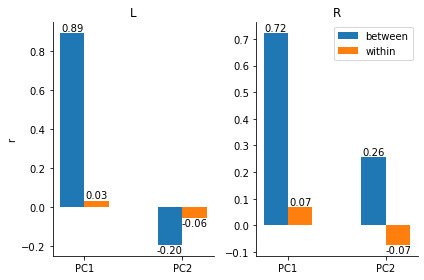

In [3]:
abs_flag = False
figsize = (6, 4)
Hemis = ['L', 'R']
meas_type = 'RFsize'
roi_type = 'Wang2015'
fname = f'PC12-corr-{meas_type}_roi3-{roi_type}'
fpath = pjoin(anal_dir, f'retinotopy/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
pc_names = data['pc_name']
corr_types = data['corr_type']
n_Hemi = len(Hemis)
n_r_type = len(corr_types)
n_pc = len(pc_names)

if abs_flag:
    ylabel = 'abs(r)'
else:
    ylabel = 'r'
print(data['arr_shape'])
ys = []
for Hemi in Hemis:
    y = data[f'{Hemi}-r']
    if abs_flag:
        y = np.abs(y)
    ys.append(y)
    print(f'{Hemi}-r:\n', y)
    print()
    print(f'{Hemi}-p:\n', data[f'{Hemi}-p'])

fig, axes, n_ax = plot_bar(
    ys, 1, n_Hemi, figsize,
    xticklabel=pc_names, ylabel=ylabel,
    title=Hemis, mode='go on',
    show_height='.2f', label=[None, corr_types]
)
# for ax in axes[0]:
#     tick_refiner = TickRefinery(ax)
#     tick_refiner.set_yticks_as_limit(2, 1)

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## PC12_corr_retinotopy_roi

shape=(n_lbl, n_pc)
L:
 [[0.89232667 0.19663543]
 [0.37742617 0.40806995]]
R:
 [[0.72267787 0.25522849]
 [0.38515288 0.43606927]]


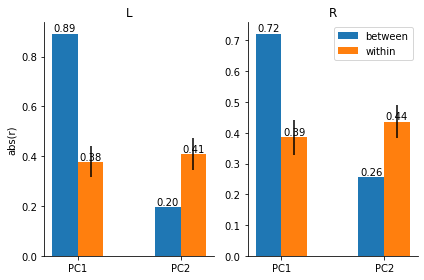

In [6]:
abs_flag = True
figsize = (6, 4)
Hemis = ['L', 'R']
labels = ('between', 'within')
meas_type = 'RFsize'
roi_type = 'Wang2015'
fname = f'PC12-corr-{meas_type}_roi-{roi_type}'
fpath = pjoin(anal_dir, f'retinotopy/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
pc_names = data['pc_name']
n_Hemi = len(Hemis)
n_lbl = len(labels)
n_pc = len(pc_names)

ys = []
yerrs = []
if abs_flag:
    ylabel = 'abs(r)'
else:
    ylabel = 'r'
print('shape=(n_lbl, n_pc)')
for Hemi in Hemis:
    y = np.zeros((n_lbl, n_pc))
    yerr = np.zeros((n_lbl, n_pc))
    meas_vec = data[f'{Hemi}_{meas_type}']
    for pc_idx in range(n_pc):
        pc_vec = data[f'{Hemi}_PC'][pc_idx]
        r_between = pearsonr(meas_vec, pc_vec)[0]
        r_within = data[f'{Hemi}_r'][pc_idx]
        if abs_flag:
            r_between = np.abs(r_between)
            r_within = np.abs(r_within)
        y[0, pc_idx] = r_between
        y[1, pc_idx] = np.mean(r_within)
        yerr[0, pc_idx] = None
        yerr[1, pc_idx] = sem(r_within)
    ys.append(y)
    yerrs.append(yerr)
    print(f'{Hemi}:\n', y)

fig, axes, n_ax = plot_bar(
    ys, 1, n_Hemi, figsize, yerrs,
    xticklabel=pc_names, ylabel=ylabel,
    title=Hemis, mode='go on',
    show_height='.2f', label=[None, labels]
)
# for ax in axes[0]:
#     tick_refiner = TickRefinery(ax)
#     tick_refiner.set_yticks_as_limit(2, 1)

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# Pair Distance

---PC1---
pearsonr(geo_vec, grad_vec, alternative='greater'):
 PearsonRResult(statistic=0.43067580939373507, pvalue=0.0)
---PC2---
pearsonr(geo_vec, grad_vec, alternative='greater'):
 PearsonRResult(statistic=0.18422250767580264, pvalue=0.0)
---PC3---
pearsonr(geo_vec, grad_vec, alternative='greater'):
 PearsonRResult(statistic=0.12538137529040877, pvalue=0.0)
---PC4---
pearsonr(geo_vec, grad_vec, alternative='greater'):
 PearsonRResult(statistic=0.1377983214018244, pvalue=0.0)
---PC5---
pearsonr(geo_vec, grad_vec, alternative='greater'):
 PearsonRResult(statistic=0.1594017504385063, pvalue=0.0)


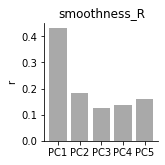

In [2]:
Hemi = 'R'  # L or R
pc_names = [f'PC{i}' for i in range(1, 6)]
vis_name = f'MMP-vis3-{Hemi}'
figsize = (2.4, 2.4)
grad_file = pjoin(anal_dir, 'pair_dist/gradient_distance_{pc_name}_{Hemi}.pkl')
geo_file = pjoin(anal_dir, f'gdist/gdist-between-all-pair-vtx_{vis_name}.pkl')
out_name = f'smoothness_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.svg')
out_file = 'show'

n_pc = len(pc_names)
geo_data = pkl.load(open(geo_file, 'rb'))
vis_vertices = geo_data[f'vtx_number_in_32k_fs_{Hemi}']
n_vtx = len(vis_vertices)
idx_mat = np.tri(n_vtx, k=-1, dtype=bool).T
geo_vec = geo_data['gdist'][idx_mat]

rs = np.zeros(n_pc)
for pc_idx, pc_name in enumerate(pc_names):
    grad_data = pkl.load(open(
        grad_file.format(pc_name=pc_name, Hemi=Hemi), 'rb'))
    assert np.all(
        grad_data[f'vtx_number_in_32k_fs_{Hemi}'] == vis_vertices)
    grad_vec = grad_data['mat'][idx_mat]
    print(f'---{pc_name}---')
    corr_res = pearsonr(geo_vec, grad_vec, alternative='greater')
    print("pearsonr(geo_vec, grad_vec, alternative='greater'):\n",
          corr_res)
    rs[pc_idx] = corr_res[0]

fig, ax = plt.subplots(1, 1, figsize=figsize)
x = np.arange(n_pc)
ax.bar(x, rs, color='darkgray')
ax.set_xticks(x)
ax.set_xticklabels(pc_names)
# ylim = ax.get_ylim()
# ylim = (np.floor(ylim[0]), np.ceil(ylim[1]))
# ax.set_yticks(ylim)
# ax.set_yticklabels(ylim)
ax.set_ylabel('r')
ax.set_title(out_name)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# 梯度与行为的相关

## 梯度权重幅值与行为指标的相关

===PicSeq_Unadj===
---PC1---
#subj: 1052

---PC2---
#subj: 1062

===CardSort_Unadj===
---PC1---
#subj: 1051

---PC2---
#subj: 1061

===Flanker_Unadj===
---PC1---
#subj: 1053

---PC2---
#subj: 1063

===PMAT24_A_CR===
---PC1---
#subj: 1046

---PC2---
#subj: 1055

===ReadEng_Unadj===
---PC1---
#subj: 1053

---PC2---
#subj: 1063

===PicVocab_Unadj===
---PC1---
#subj: 1049

---PC2---
#subj: 1059

===ProcSpeed_Unadj===
---PC1---
#subj: 1051

---PC2---
#subj: 1061

===DDisc_AUC_200===
---PC1---
#subj: 1023

---PC2---
#subj: 1032

===DDisc_AUC_40K===
---PC1---
#subj: 1047

---PC2---
#subj: 1056

===VSPLOT_TC===
---PC1---
#subj: 1047

---PC2---
#subj: 1056

===SCPT_SEN===
---PC1---
#subj: 1009

---PC2---
#subj: 1017

===SCPT_SPEC===
---PC1---
#subj: 1016

---PC2---
#subj: 1025

===IWRD_TOT===
---PC1---
#subj: 1044

---PC2---
#subj: 1053

===ListSort_Unadj===
---PC1---
#subj: 1044

---PC2---
#subj: 1054

===Noise_Comp===
---PC1---
#subj: 1039

---PC2---
#subj: 1049

===Odor_Unadj===
---PC1---
#s

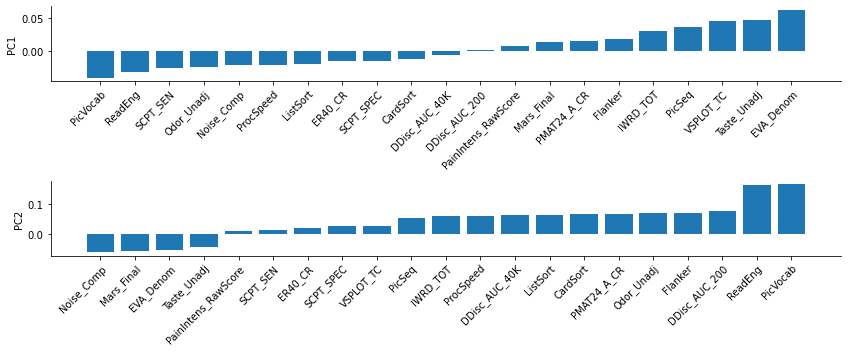

In [2]:
iqr_coef = 2  # None, float

figsize = (12, 5)
cognition_cols = [
    'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 
    'PMAT24_A_CR', 'ReadEng_Unadj', 'PicVocab_Unadj', 
    'ProcSpeed_Unadj', 'DDisc_AUC_200', 'DDisc_AUC_40K',
    'VSPLOT_TC', 'SCPT_SEN', 'SCPT_SPEC', 'IWRD_TOT',
    'ListSort_Unadj']
sensory_cols = [
    'Noise_Comp', 'Odor_Unadj', 'PainIntens_RawScore',
    'Taste_Unadj', 'EVA_Denom', 'Mars_Final']
beh_names = cognition_cols + sensory_cols + ['ER40_CR']

Hemi = 'L'
vis_name=f'MMP-vis3-{Hemi}'
pc_names = ('C1', 'C2')
m_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_M.csv')
t_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_corrT.csv')
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_file1 = '/nfs/z1/HCP/HCPYA/S1200_behavior.csv'
beh_file2 = '/nfs/z1/HCP/HCPYA/S1200_behavior_restricted.csv'
out_file = pjoin(work_dir, f'MT-corr-beh_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_beh = len(beh_names)
m_df = pd.read_csv(m_file, usecols=pc_names)
t_df = pd.read_csv(t_file, usecols=pc_names)
mt_df = np.abs(m_df) + np.abs(t_df)
beh_df1 = pd.read_csv(beh_file1, index_col='Subject')
beh_df2 = pd.read_csv(beh_file2, index_col='Subject')
assert np.all(beh_df1.index == beh_df2.index)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
info_df = pd.read_csv(info_file, index_col='subID')
beh_df = beh_df.loc[info_df.index, beh_names]

rs = np.zeros((n_pc, n_beh))
ps = np.zeros((n_pc, n_beh))
for beh_idx, beh_name in enumerate(beh_names):
    beh_vec = beh_df[beh_name].values
    non_nan_vec = ~np.isnan(beh_vec)
    print(f'==={beh_name}===')
    beh_vec = beh_vec[non_nan_vec]
    if iqr_coef is not None:
        outlier_mask1 = outlier_iqr(beh_vec, iqr_coef)
    for pc_idx, pc_name in enumerate(pc_names):
        print(f'---P{pc_name}---')
        mt_vec = mt_df[pc_name].values[non_nan_vec]
        if iqr_coef is not None:
            outlier_mask2 = outlier_iqr(mt_vec, iqr_coef)
            outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
            mask = ~outlier_mask
            x = mt_vec[mask]
            y = beh_vec[mask]
        else:
            x = mt_vec
            y = beh_vec
        print('#subj:', x.size)
        print()
        r, p = pearsonr(x, y)
        rs[pc_idx, beh_idx] = r
        ps[pc_idx, beh_idx] = p

print('>>>p value')
for pc_idx, pc_name in enumerate(pc_names):
    print(f'===P{pc_name}===')
    print('---significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p < 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()

    print('---not significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p >= 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()
print('p value<<<')

# plot
fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
x_plot = np.arange(n_beh)
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    r_vec = rs[pc_idx]
    sorted_indices = np.argsort(r_vec)
    r_vec = r_vec[sorted_indices]
    xticklabels = []
    for sorted_idx in sorted_indices:
        beh_name = beh_names[sorted_idx]
        if beh_name in beh_name2abbr.keys():
            beh_name = beh_name2abbr[beh_name]
        xticklabels.append(beh_name)
    ax.bar(x_plot, r_vec)
    ax.set_xticks(x_plot)
    ax.set_xticklabels(xticklabels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylabel(f'P{pc_name}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 梯度权重幅值与行为指标的相关，PC1和PC2画到一起

>>>p value
===PC1===
---significant---

---not significant---
PicVocab_Unadj(0.053741576469512935), ProcSpeed_Unadj(0.7698574857018112), VSPLOT_TC(0.558737979364253), SCPT_SEN(0.1288149110098607), SCPT_SPEC(0.28865840398892634), ER40_CR(0.7241359142352645), EVA_Denom(0.1454563436956101), Mars_Final(0.18832986863501944), 
===PC2===
---significant---
PicVocab_Unadj(3.3427337353528585e-06), VSPLOT_TC(0.004885323065372858), EVA_Denom(0.008025366996595371), 
---not significant---
ProcSpeed_Unadj(0.20315996724310592), SCPT_SEN(0.1073725503150974), SCPT_SPEC(0.6169335480658332), ER40_CR(0.12437419102241479), Mars_Final(0.29816308750520504), 
p value<<<























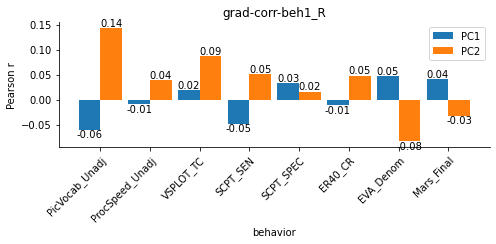

In [7]:
iqr_coef = 2  # None, float

figsize = (7, 3.5)
beh_names = (
    'PicVocab_Unadj', 'ProcSpeed_Unadj', 'VSPLOT_TC',
    'SCPT_SEN', 'SCPT_SPEC', 'ER40_CR', 'EVA_Denom', 'Mars_Final')

Hemi = 'R'
vis_name=f'MMP-vis3-{Hemi}'
pc_names = ('C1', 'C2')
m_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_M.csv')
t_file = pjoin(
    anal_dir, 'decomposition/'
    f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_corrT.csv')
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_file1 = '/nfs/z1/HCP/HCPYA/S1200_behavior.csv'
beh_file2 = '/nfs/z1/HCP/HCPYA/S1200_behavior_restricted.csv'
out_file = pjoin(work_dir, f'MT-corr-beh_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_beh = len(beh_names)
m_df = pd.read_csv(m_file, usecols=pc_names)
t_df = pd.read_csv(t_file, usecols=pc_names)
beh_df1 = pd.read_csv(beh_file1, index_col='Subject')
beh_df2 = pd.read_csv(beh_file2, index_col='Subject')
assert np.all(beh_df1.index == beh_df2.index)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
info_df = pd.read_csv(info_file, index_col='subID')
beh_df = beh_df.loc[info_df.index, beh_names]

rs = np.zeros((n_pc, n_beh))
ps = np.zeros((n_pc, n_beh))
for beh_idx, beh_name in enumerate(beh_names):
    beh_vec = beh_df[beh_name].values
    non_nan_vec = ~np.isnan(beh_vec)
    beh_vec = beh_vec[non_nan_vec]
    if iqr_coef is not None:
        outlier_mask1 = outlier_iqr(beh_vec, iqr_coef)
    for pc_idx, pc_name in enumerate(pc_names):
        m_vec = m_df[pc_name].values[non_nan_vec]
        t_vec = t_df[pc_name].values[non_nan_vec]
        if iqr_coef is not None:
            outlier_mask2 = outlier_iqr(m_vec, iqr_coef)
            outlier_mask3 = outlier_iqr(t_vec, iqr_coef)
            outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
            outlier_mask = np.logical_or(outlier_mask, outlier_mask3)
            mask = ~outlier_mask
            x = np.abs(m_vec[mask]) + np.abs(t_vec[mask])
            y = beh_vec[mask]
        else:
            x = np.abs(m_vec) + np.abs(t_vec)
            y = beh_vec
        r, p = pearsonr(x, y)
        rs[pc_idx, beh_idx] = r
        ps[pc_idx, beh_idx] = p

print('>>>p value')
for pc_idx, pc_name in enumerate(pc_names):
    print(f'===P{pc_name}===')
    print('---significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p < 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()

    print('---not significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p >= 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()
print('p value<<<')
print('\n'*20)

# plot
plot_bar(y=rs, n_row=1, n_col=1, figsize=figsize, yerr=None, x=None, width=None,
         label=tuple(f'P{i}' for i in pc_names), color=None, fc_ec_flag=False,
         fc=None, ec=None, show_height='.2f', xlabel='behavior', xticklabel=beh_names,
         rotate_xticklabel=True, ylabel='Pearson r', ylim=None,
         title=f'grad-corr-beh1_{Hemi}', mode=out_file)

## 梯度成形度与行为指标的相关

===PicSeq_Unadj===
---PC1---
#subj: 1040

---PC2---
#subj: 1063

===CardSort_Unadj===
---PC1---
#subj: 1038

---PC2---
#subj: 1061

===Flanker_Unadj===
---PC1---
#subj: 1040

---PC2---
#subj: 1063

===PMAT24_A_CR===
---PC1---
#subj: 1031

---PC2---
#subj: 1055

===ReadEng_Unadj===
---PC1---
#subj: 1040

---PC2---
#subj: 1063

===PicVocab_Unadj===
---PC1---
#subj: 1036

---PC2---
#subj: 1059

===ProcSpeed_Unadj===
---PC1---
#subj: 1038

---PC2---
#subj: 1061

===DDisc_AUC_200===
---PC1---
#subj: 1007

---PC2---
#subj: 1031

===DDisc_AUC_40K===
---PC1---
#subj: 1032

---PC2---
#subj: 1056

===VSPLOT_TC===
---PC1---
#subj: 1032

---PC2---
#subj: 1056

===SCPT_SEN===
---PC1---
#subj: 993

---PC2---
#subj: 1017

===SCPT_SPEC===
---PC1---
#subj: 1002

---PC2---
#subj: 1025

===IWRD_TOT===
---PC1---
#subj: 1029

---PC2---
#subj: 1053

===ListSort_Unadj===
---PC1---
#subj: 1031

---PC2---
#subj: 1054

===Noise_Comp===
---PC1---
#subj: 1026

---PC2---
#subj: 1049

===Odor_Unadj===
---PC1---
#su

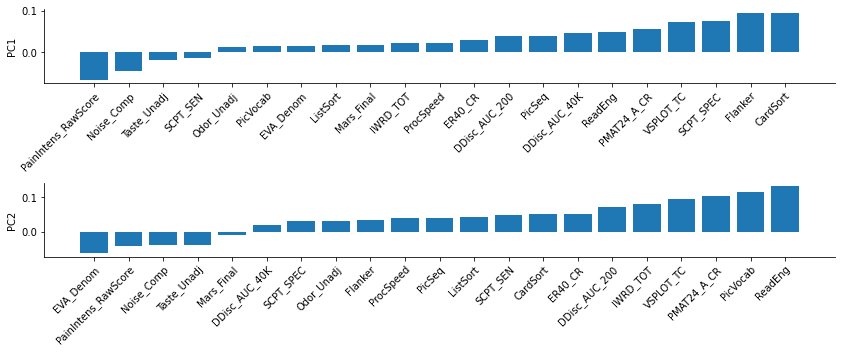

In [2]:
iqr_coef = 2  # None, float

figsize = (12, 5)
cognition_cols = [
    'PicSeq_Unadj', 'CardSort_Unadj', 'Flanker_Unadj', 
    'PMAT24_A_CR', 'ReadEng_Unadj', 'PicVocab_Unadj', 
    'ProcSpeed_Unadj', 'DDisc_AUC_200', 'DDisc_AUC_40K',
    'VSPLOT_TC', 'SCPT_SEN', 'SCPT_SPEC', 'IWRD_TOT',
    'ListSort_Unadj']
sensory_cols = [
    'Noise_Comp', 'Odor_Unadj', 'PainIntens_RawScore',
    'Taste_Unadj', 'EVA_Denom', 'Mars_Final']
beh_names = cognition_cols + sensory_cols + ['ER40_CR']

Hemi = 'R'
vis_name=f'MMP-vis3-{Hemi}'
pc_names = ('C1', 'C2')
grad_file = pjoin(
    anal_dir, 'fit/'
    f'HCPY-M+corrT_{vis_name}_fit_PC_subj-wise.pkl')
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_file1 = '/nfs/z1/HCP/HCPYA/S1200_behavior.csv'
beh_file2 = '/nfs/z1/HCP/HCPYA/S1200_behavior_restricted.csv'
out_file = pjoin(work_dir, f'grad-corr-beh_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_beh = len(beh_names)
grad_data = pkl.load(open(grad_file, 'rb'))
beh_df1 = pd.read_csv(beh_file1, index_col='Subject')
beh_df2 = pd.read_csv(beh_file2, index_col='Subject')
assert np.all(beh_df1.index == beh_df2.index)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
info_df = pd.read_csv(info_file, index_col='subID')
beh_df = beh_df.loc[info_df.index, beh_names]

rs = np.zeros((n_pc, n_beh))
ps = np.zeros((n_pc, n_beh))
for beh_idx, beh_name in enumerate(beh_names):
    beh_vec = beh_df[beh_name].values
    non_nan_vec = ~np.isnan(beh_vec)
    print(f'==={beh_name}===')
    beh_vec = beh_vec[non_nan_vec]
    if iqr_coef is not None:
        outlier_mask1 = outlier_iqr(beh_vec, iqr_coef)
    for pc_idx, pc_name in enumerate(pc_names):
        print(f'---P{pc_name}---')
        grad_vec = grad_data[f'{vis_name}_{pc_name}'][non_nan_vec]
        if iqr_coef is not None:
            outlier_mask2 = outlier_iqr(grad_vec, iqr_coef)
            outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
            mask = ~outlier_mask
            x = grad_vec[mask]
            y = beh_vec[mask]
        else:
            x = grad_vec
            y = beh_vec
        print('#subj:', x.size)
        print()
        r, p = pearsonr(x, y)
        rs[pc_idx, beh_idx] = r
        ps[pc_idx, beh_idx] = p

print('>>>p value')
for pc_idx, pc_name in enumerate(pc_names):
    print(f'===P{pc_name}===')
    print('---significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p < 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()

    print('---not significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p >= 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()
print('p value<<<')

# plot
fig, axes = plt.subplots(n_pc, 1, figsize=figsize)
x_plot = np.arange(n_beh)
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    r_vec = rs[pc_idx]
    sorted_indices = np.argsort(r_vec)
    r_vec = r_vec[sorted_indices]
    xticklabels = []
    for sorted_idx in sorted_indices:
        beh_name = beh_names[sorted_idx]
        if beh_name in beh_name2abbr.keys():
            beh_name = beh_name2abbr[beh_name]
        xticklabels.append(beh_name)
    ax.bar(x_plot, r_vec)
    ax.set_xticks(x_plot)
    ax.set_xticklabels(xticklabels)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylabel(f'P{pc_name}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 梯度成形度与行为指标的相关，PC1和PC2画到一起

>>>p value
===PC1===
---significant---
VSPLOT_TC(0.021602042148911666), SCPT_SPEC(0.016511230684976452), 
---not significant---
PicVocab_Unadj(0.656743560190558), ProcSpeed_Unadj(0.46414942254989666), SCPT_SEN(0.6583494286614135), ER40_CR(0.3670699988680637), EVA_Denom(0.6623154565460276), Mars_Final(0.5868720494947469), 
===PC2===
---significant---
PicVocab_Unadj(0.000149122442497586), VSPLOT_TC(0.0018629587966074474), EVA_Denom(0.04742719085800938), 
---not significant---
ProcSpeed_Unadj(0.2055613077068478), SCPT_SEN(0.12128199778254657), SCPT_SPEC(0.3290818937758216), ER40_CR(0.09113163023049871), Mars_Final(0.7627542274951258), 
p value<<<


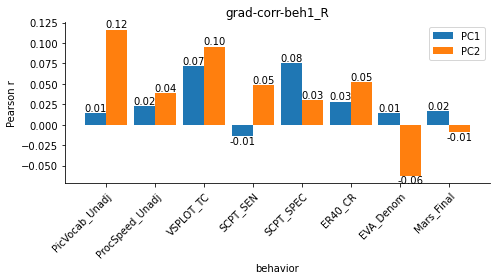

In [4]:
iqr_coef = 2  # None, float

figsize = (7, 4)
beh_names = (
    'PicVocab_Unadj', 'ProcSpeed_Unadj', 'VSPLOT_TC',
    'SCPT_SEN', 'SCPT_SPEC', 'ER40_CR', 'EVA_Denom', 'Mars_Final')

Hemi = 'R'
vis_name=f'MMP-vis3-{Hemi}'
pc_names = ('C1', 'C2')
grad_file = pjoin(
    anal_dir, 'fit/'
    f'HCPY-M+corrT_{vis_name}_fit_PC_subj-wise.pkl')
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
beh_file1 = '/nfs/z1/HCP/HCPYA/S1200_behavior.csv'
beh_file2 = '/nfs/z1/HCP/HCPYA/S1200_behavior_restricted.csv'
out_file = pjoin(work_dir, f'grad-corr-beh1_{Hemi}.jpg')
# out_file = 'show'

n_pc = len(pc_names)
n_beh = len(beh_names)
grad_data = pkl.load(open(grad_file, 'rb'))
beh_df1 = pd.read_csv(beh_file1, index_col='Subject')
beh_df2 = pd.read_csv(beh_file2, index_col='Subject')
assert np.all(beh_df1.index == beh_df2.index)
beh_df = pd.concat([beh_df1, beh_df2], axis=1)
info_df = pd.read_csv(info_file, index_col='subID')
beh_df = beh_df.loc[info_df.index, beh_names]

rs = np.zeros((n_pc, n_beh))
ps = np.zeros((n_pc, n_beh))
for beh_idx, beh_name in enumerate(beh_names):
    beh_vec = beh_df[beh_name].values
    non_nan_vec = ~np.isnan(beh_vec)
    beh_vec = beh_vec[non_nan_vec]
    if iqr_coef is not None:
        outlier_mask1 = outlier_iqr(beh_vec, iqr_coef)
    for pc_idx, pc_name in enumerate(pc_names):
        grad_vec = grad_data[f'{vis_name}_{pc_name}'][non_nan_vec]
        if iqr_coef is not None:
            outlier_mask2 = outlier_iqr(grad_vec, iqr_coef)
            outlier_mask = np.logical_or(outlier_mask1, outlier_mask2)
            mask = ~outlier_mask
            x = grad_vec[mask]
            y = beh_vec[mask]
        else:
            x = grad_vec
            y = beh_vec
        r, p = pearsonr(x, y)
        rs[pc_idx, beh_idx] = r
        ps[pc_idx, beh_idx] = p

print('>>>p value')
for pc_idx, pc_name in enumerate(pc_names):
    print(f'===P{pc_name}===')
    print('---significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p < 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()

    print('---not significant---')
    for beh_idx, p in enumerate(ps[pc_idx]):
        if p >= 0.05:
            print(f'{beh_names[beh_idx]}({p})', end=', ')
    print()
print('p value<<<')

# plot
plot_bar(y=rs, n_row=1, n_col=1, figsize=figsize, yerr=None, x=None, width=None,
         label=tuple(f'P{i}' for i in pc_names), color=None, fc_ec_flag=False,
         fc=None, ec=None, show_height='.2f', xlabel='behavior', xticklabel=beh_names,
         rotate_xticklabel=True, ylabel='Pearson r', ylim=None,
         title=f'grad-corr-beh1_{Hemi}', mode=out_file)

# Divide map

## 基于stru-C2扩张的区域与EDLV的overlap

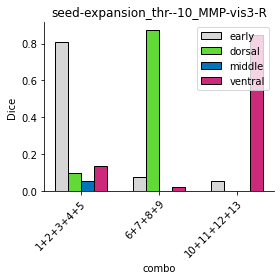

In [3]:
figsize = (4, 4)
hemi = 'rh'
seed_combos = [(1, 2, 3, 4, 5), (6, 7, 8, 9), (10, 11, 12, 13)]
combo_names = tuple('+'.join(map(str, i)) for i in seed_combos)
fname = 'seed-expansion_thr--10_MMP-vis3-R'
expand_file = pjoin(anal_dir, f'divide_map/{fname}.dlabel.nii')
edlv_file = pjoin(anal_dir, 'tmp/MMP-vis3-EDMV.dlabel.nii')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

reader1 = CiftiReader(expand_file)
expand_maps = reader1.get_data(hemi2stru[hemi], True)
map_names = reader1.map_names()

reader2 = CiftiReader(edlv_file)
edlv_map = reader2.get_data(hemi2stru[hemi], True)[0]
edlv_keys = np.unique(edlv_map)
edlv_keys = edlv_keys[edlv_keys != 0]
lbl_tab = reader2.label_tables()[0]
edlv_lbls = tuple(lbl_tab[i].label for i in edlv_keys)
colors = (
    (0.84, 0.84, 0.84, 1),
    (0.38, 0.85, 0.21, 1),
    (0, 0.46, 0.73, 1),
    (0.80, 0.16, 0.48, 1))

n_edlv_key = len(edlv_keys)
n_combo = len(seed_combos)
data = np.zeros((n_edlv_key, n_combo))
for combo_idx, combo in enumerate(seed_combos):
    map_idx = map_names.index(str(combo))
    for edlv_idx, edlv_key in enumerate(edlv_keys):
        data[edlv_idx, combo_idx] = calc_overlap(
            data1=expand_maps[map_idx], data2=edlv_map,
            label1=1, label2=edlv_key, index='dice')
plot_bar(data, label=edlv_lbls, fc_ec_flag=True, fc=colors, ec=('k',)*n_edlv_key,
         xlabel='combo', xticklabel=combo_names, rotate_xticklabel=True,
         ylabel='Dice', title=fname, mode=out_file, figsize=figsize)


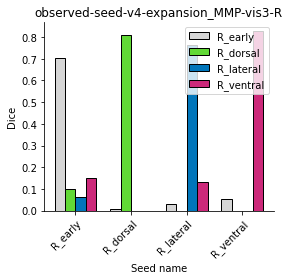

In [2]:
figsize = (4, 4)
hemi = 'rh'
Hemi = hemi2Hemi[hemi]
seed_names = ('early', 'dorsal', 'lateral', 'ventral')
seed_names = tuple(f'{Hemi}_{i}' for i in seed_names)
fname = 'observed-seed-v4-expansion_MMP-vis3-R'
expand_file = pjoin(anal_dir, f'divide_map/{fname}.dlabel.nii')
edlv_file = pjoin(proj_dir, 'data/HCP/HCP-MMP1_visual-cortex3_EDLV.dlabel.nii')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

reader1 = CiftiReader(expand_file)
expand_maps = reader1.get_data(hemi2stru[hemi], True)
map_names = reader1.map_names()

reader2 = CiftiReader(edlv_file)
edlv_map = reader2.get_data(hemi2stru[hemi], True)[0]
edlv_keys = np.unique(edlv_map)
edlv_keys = edlv_keys[edlv_keys != 0]
lbl_tab = reader2.label_tables()[0]
edlv_lbls = tuple(lbl_tab[i].label for i in edlv_keys)
colors = (
    (0.84, 0.84, 0.84, 1),
    (0.38, 0.85, 0.21, 1),
    (0, 0.46, 0.73, 1),
    (0.80, 0.16, 0.48, 1))

n_edlv_key = len(edlv_keys)
n_seed = len(seed_names)
data = np.zeros((n_edlv_key, n_seed))
for seed_name in seed_names:
    map_idx = map_names.index(seed_name)
    for edlv_idx, edlv_key in enumerate(edlv_keys):
        data[edlv_idx, map_idx] = calc_overlap(
            data1=expand_maps[map_idx], data2=edlv_map,
            label1=1, label2=edlv_key, index='dice')
plot_bar(data, label=edlv_lbls, fc_ec_flag=True, fc=colors, ec=('k',)*n_edlv_key,
         xlabel='Seed name', xticklabel=seed_names, rotate_xticklabel=True,
         ylabel='Dice', title=fname, mode=out_file, figsize=figsize)


# 分层级考察PC2的变异

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


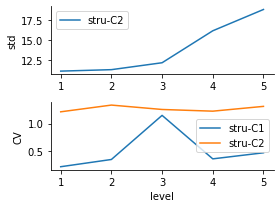

In [6]:
figsize = (4, 3)
n_level = 5
levels = np.arange(1, n_level+1)
# fname = f'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_{n_level}level-ROI'
fname = f'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_N{n_level}'
scale_type = 'local'  # local, global
pc_names = ('stru-C1', 'stru-C2')
pc_file = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
mask_file = pjoin(anal_dir, f'mask_map/{fname}.dlabel.nii')
vis_mask = Atlas('HCP-MMP').get_mask(get_rois('MMP-vis3-R'))[0]
out_file = pjoin(work_dir, f'{fname}_variance.jpg')
# out_file = 'show'

pc_maps = nib.load(pc_file).get_fdata()[:2]
mask_map = nib.load(mask_file).get_fdata()[0]
pc1_abs_mean = np.mean(np.abs(pc_maps[0][vis_mask]))
pc2_abs_mean = np.mean(np.abs(pc_maps[1][vis_mask]))
y1 = np.zeros(n_level)
y2 = np.zeros((2, n_level))
for idx, level in enumerate(levels):
    mask = mask_map == level
    y1[idx] = np.std(pc_maps[1][mask], ddof=1)
    if scale_type == 'global':
        y2[0, idx] = np.std(pc_maps[0][mask], ddof=1) / pc1_abs_mean
        y2[1, idx] = np.std(pc_maps[1][mask], ddof=1) / pc2_abs_mean
    elif scale_type == 'local':
        y2[0, idx] = np.std(pc_maps[0][mask], ddof=1) / np.mean(np.abs(pc_maps[0][mask]))
        y2[1, idx] = np.std(pc_maps[1][mask], ddof=1) / np.mean(np.abs(pc_maps[1][mask]))
    else:
        raise ValueError

plot_line([y1, y2], 2, 1, label=[(pc_names[1],), pc_names], xlabel='level', xticklabel=levels, ylabel=['std', 'CV'], mode=out_file, figsize=figsize)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


#invalid: 3
pearsonr (0.36013312898716054, 0.6398668710128395)
SpearmanrResult(correlation=0.6000000000000001, pvalue=0.3999999999999999)


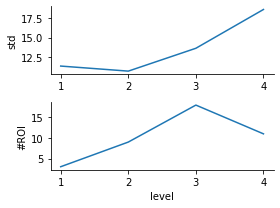

In [4]:
figsize = (4, 3)
n_level = 4
levels = np.arange(1, n_level+1)
# fname = f'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_N{n_level}'
pc_file = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
mask_file = pjoin(anal_dir, f'mask_map/{fname}.dlabel.nii')
rois = get_rois('MMP-vis3-R')
atlas = Atlas('HCP-MMP')
out_file = pjoin(work_dir, f'{fname}_#ROI.jpg')
# out_file = 'show'

n_roi = len(rois)
c2_map = nib.load(pc_file).get_fdata()[1]
mask_map = nib.load(mask_file).get_fdata()[0]
count_mat = np.zeros((n_roi, n_level))
for roi_idx, roi in enumerate(rois):
    mask_roi = atlas.get_mask(roi)[0]
    samples = mask_map[mask_roi]
    for level_idx, level in enumerate(levels):
        count_mat[roi_idx, level_idx] = np.mean(samples == level)
level_vec = np.argmax(count_mat, 1) + 1
invalid_vec = np.all(count_mat < 0.5, 1)
print('#invalid:', np.sum(invalid_vec))
level_vec[invalid_vec] = 0

y1 = np.zeros(n_level)
y2 = np.zeros(n_level)
for idx, level in enumerate(levels):
    mask = mask_map == level
    y1[idx] = np.std(c2_map[mask], ddof=1)
    y2[idx] = np.sum(level_vec == level)

plot_line([y1, y2], 2, 1, xlabel='level', xticklabel=levels, ylabel=['std', '#ROI'], mode=out_file, figsize=figsize)
print('pearsonr', pearsonr(y1, y2))
print(spearmanr(y1, y2))

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


pearsonr (0.23701415896565095, 0.45826062736571593)
SpearmanrResult(correlation=0.3873335483621993, pvalue=0.2135115526743914)


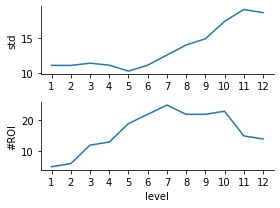

In [3]:
# 用滑窗的方式划定层级，按PC1值排序，窗宽为1000个顶点，以500为步长进行移动
# 最后不足500的247个顶点合并到前1000个顶点中.
# 计算PC2在各窗口内的std(ddof=1)。
# 在每个窗口中，对于每个ROI，其有10%以上的顶点属于该窗口时，计入该窗口所涉及的ROI数量。
figsize = (4, 3)
width = 1000
step = 500
atlas = Atlas('HCP-MMP')
rois = get_rois('MMP-vis3-R')
vis_mask = atlas.get_mask(rois)[0]
n_vtx = np.sum(vis_mask)
pc_file = pjoin(anal_dir, 'decomposition/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.dscalar.nii')
out_file = pjoin(work_dir, 'PC2_var_in_slide_hierarchy.jpg')
# out_file = 'show'

# get window start and end indices
step_space = n_vtx - width
n_remainder = step_space % step
start_indices = list(range(0, step_space, step))
end_indices = [i + width for i in start_indices]
end_indices[-1] = n_vtx
n_win = len(start_indices)
levels = np.arange(1, n_win + 1)

# get vertex indices sorted by PC1 value
pc_maps = nib.load(pc_file).get_fdata()[:2, vis_mask]
vtx_indices = np.argsort(pc_maps[0])

# prepare roi masks and vertex numbers
roi2mask = {}
roi2vtx_num = {}
for roi in rois:
    roi2mask[roi] = atlas.get_mask(roi)[0]
    roi2vtx_num[roi] = np.sum(roi2mask[roi])

y1 = np.zeros(n_win)
y2 = np.zeros(n_win)
for idx in range(n_win):
    win_mask = np.zeros_like(atlas.maps[0], bool)
    win_mask_vis = np.zeros_like(pc_maps[0], bool)
    s_idx = start_indices[idx]
    e_idx = end_indices[idx]
    vtx_indices_win = vtx_indices[s_idx:e_idx]
    y1[idx] = np.std(pc_maps[1][vtx_indices_win], ddof=1)

    win_mask_vis[vtx_indices_win] = True
    win_mask[vis_mask] = win_mask_vis
    n_roi = 0
    for roi in rois:
        win_roi_overlap = np.logical_and(win_mask, roi2mask[roi])
        n_vtx_overlap = np.sum(win_roi_overlap)
        if (n_vtx_overlap / roi2vtx_num[roi]) > 0.1:
            n_roi += 1
    y2[idx] = n_roi

plot_line([y1, y2], 2, 1, xlabel='level', xticklabel=levels, ylabel=['std', '#ROI'],
          mode=out_file, figsize=figsize)
print('pearsonr', pearsonr(y1, y2))
print(spearmanr(y1, y2))

# rfMRI

## pc_corr_rftp

### 观察单个run的相关序列

#### PC1和PC2画一块

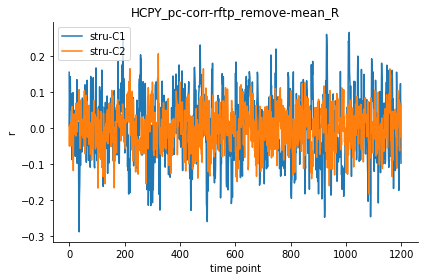

In [6]:
figsize = (3, 3)
sid = 100307
run = 'rfMRI_REST1_LR'
fname = 'HCPY_pc-corr-rftp_remove-mean_R'
fpath = pjoin(anal_dir, f'rfMRI/{fname}.pkl')
zscore_flag = False
out_file = pjoin(work_dir, f'{fname}1.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
pc_names = tuple(data['pc_name'])
ys = data[sid][run]
if zscore_flag:
    ys = zscore(ys, 1)
plot_line(ys, label=pc_names, xlabel='time point', ylabel='r', title=fname, mode=out_file)

#### PC1和PC2分开画

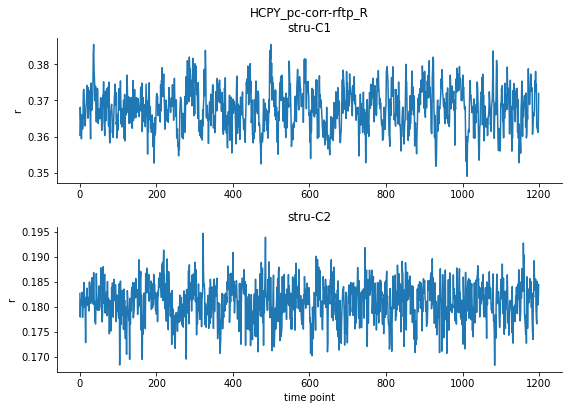

In [3]:
figsize = (8, 5.8)
sid = 100307
run = 'rfMRI_REST1_LR'
fname = 'HCPY_pc-corr-rftp_R'
fpath = pjoin(anal_dir, f'rfMRI/{fname}.pkl')
zscore_flag = False
abs_flag = True
out_file = pjoin(work_dir, f'{fname}4.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
ys = data[sid][run]
if zscore_flag:
    ys = zscore(ys, 1)
if abs_flag:
    ys = np.abs(ys)
ys = [ys[0], ys[1]]
titles = [f"{fname}\n{data['pc_name'][0]}", data['pc_name'][1]]
plot_line(ys, 2, 1, xlabel='time point', ylabel='r', title=titles, mode=out_file, figsize=figsize)

### 跨被试跨run看PC和每个时间点相关值的分布

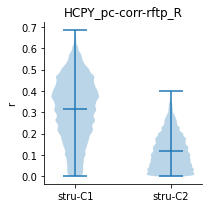

In [4]:
figsize = (3, 3)
fname = 'HCPY_pc-corr-rftp_R'
fpath = pjoin(anal_dir, f'rfMRI/{fname}.pkl')
pc_names = ['stru-C1', 'stru-C2']
abs_flag = True
out_file = pjoin(work_dir, f'{fname}2.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
pc_indices = [data['pc_name'].index(i) for i in pc_names]
data.pop('pc_name')
xs = np.arange(len(pc_names))
datasets = [[], []]
fig, ax = plt.subplots(figsize=figsize)
for sid_data in data.values():
    for run_data in sid_data.values():
        for x, pc_name in enumerate(pc_names):
            datasets[x].extend(run_data[pc_indices[x]])
if abs_flag:
    datasets = [np.abs(i) for i in datasets]
ax.violinplot(datasets, xs, showmeans=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xs)
ax.set_xticklabels(pc_names)
ax.set_ylabel('r')
ax.set_title(fname)
fig.tight_layout()

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

差值的分布

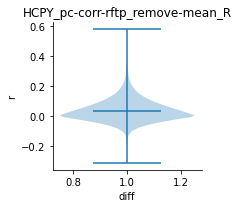

In [3]:
figsize = (3, 3)
fname = 'HCPY_pc-corr-rftp_remove-mean_R'
fpath = pjoin(anal_dir, f'rfMRI/{fname}.pkl')
pc_names = ['stru-C1', 'stru-C2']
out_file = pjoin(work_dir, f'{fname}2.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
pc_indices = [data['pc_name'].index(i) for i in pc_names]
data.pop('pc_name')
xs = np.arange(len(pc_names))
datasets = [[], []]
fig, ax = plt.subplots(figsize=figsize)
for sid_data in data.values():
    for run_data in sid_data.values():
        for x, pc_name in enumerate(pc_names):
            datasets[x].extend(run_data[pc_indices[x]])
datasets = [np.abs(i) for i in datasets]
datasets = [datasets[0] - datasets[1]]
ax.violinplot(datasets, showmeans=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('diff')
ax.set_ylabel('r')
ax.set_title(fname)
fig.tight_layout()

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 跨被试跨run看两个PC与时间点map相关序列的相关

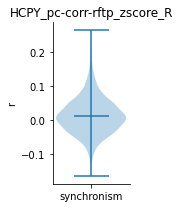

In [4]:
# 在每个run中，PC1和PC2与1200个时间点map做相关可以得到各自的长度为1200的相关序列，
# 我们可以计算这两个序列之间的相关。然后看看所有被试所有run的这个相关的分布。

figsize = (2, 3)
fname = 'HCPY_pc-corr-rftp_zscore_R'
fpath = pjoin(anal_dir, f'rfMRI/{fname}.pkl')
pc_names = ['stru-C1', 'stru-C2']
abs_flag = True
out_file = pjoin(work_dir, f'{fname}3.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
data.pop('pc_name')
fig, ax = plt.subplots(figsize=figsize)
dataset = []
for sid_data in data.values():
    for run_data in sid_data.values():
        if abs_flag:
            run_data = np.abs(run_data)
        r, p = pearsonr(run_data[0], run_data[1])
        dataset.append(r)
ax.violinplot(dataset, showmeans=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([1])
ax.set_xticklabels(['synchronism'])
ax.set_ylabel('r')
ax.set_title(fname)
fig.tight_layout()

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

# RSM

## RSM9

C1_abs(weight)_M+T_R corr VSPLOT_CR/RT, p value: 0.7827010463757745
C1_abs(weight)_M+T_R corr Emotion_Task_CR/RT, p value: 0.23594560613935855
C1_abs(weight)_M+T_R corr ER40_CR/RT, p value: 0.35320505824205506
C1_abs(weight)_M+T_R corr WM_Task_0bk_CR/RT, p value: 0.2721200721763959
C1_abs(weight)_M+T_R corr Mars_Final, p value: 0.5188264209889378
C2_abs(weight)_M+T_R corr VSPLOT_CR/RT, p value: 3.268671972432362e-05
C2_abs(weight)_M+T_R corr Emotion_Task_CR/RT, p value: 0.0011164324882587766
C2_abs(weight)_M+T_R corr ER40_CR/RT, p value: 0.11176717962418106
C2_abs(weight)_M+T_R corr WM_Task_0bk_CR/RT, p value: 0.009325397102311677
C2_abs(weight)_M+T_R corr Mars_Final, p value: 0.8882326513827757


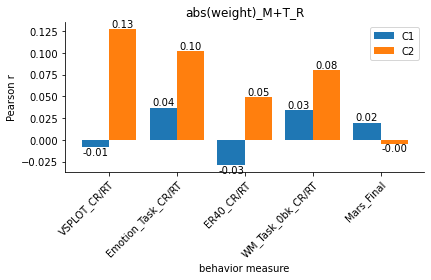

In [6]:
Hemi = 'R'
fpath = pjoin(anal_dir, 'RSM/RSM9.pkl')
out_file = pjoin(work_dir, f'RSM9_{Hemi}.jpg')
# out_file = 'show'

pc_names = ('C1', 'C2')
beh_names = ('VSPLOT_CR/RT', 'Emotion_Task_CR/RT', 'ER40_CR/RT',
             'WM_Task_0bk_CR/RT', 'Mars_Final')
n_pc = len(pc_names)
n_beh = len(beh_names)

data = pkl.load(open(fpath, 'rb'))
ys = np.zeros((n_pc, n_beh))
for pc_idx, pc_name in enumerate(pc_names):
    grad_contri_name = f'{pc_name}_abs(weight)_M+T_{Hemi}'
    row_idx = data['row_name'].index(grad_contri_name)
    for beh_idx, beh_name in enumerate(beh_names):
        col_idx = data['col_name'].index(beh_name)
        ys[pc_idx, beh_idx] = data['r'][row_idx, col_idx]
        print(f'{grad_contri_name} corr {beh_name}, p value:',
              data['p'][row_idx, col_idx])

plot_bar(y=ys, n_row=1, n_col=1, figsize=None, yerr=None, x=None, width=None,
         label=pc_names, color=None, fc_ec_flag=False, fc=None, ec=None,
         show_height='.2f', xlabel='behavior measure', xticklabel=beh_names,
         rotate_xticklabel=True, ylabel='Pearson r', ylim=None,
         title=f'abs(weight)_M+T_{Hemi}', mode=out_file)

## RSM5

### all sorted visual ROIs

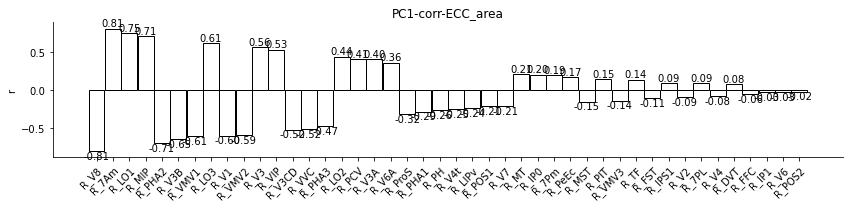

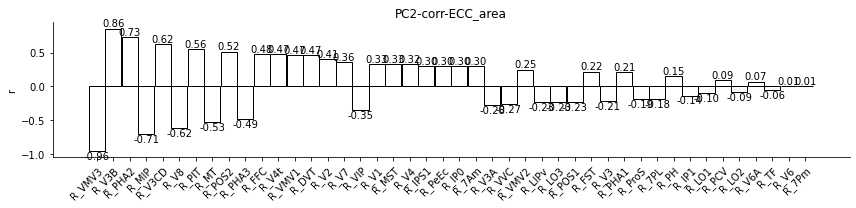

In [7]:
fpath = pjoin(anal_dir, 'RSM/RSM5_PC12-corr-ECC_area.pkl')
data = pkl.load(open(fpath, 'rb'))
out_file = pjoin(work_dir, 'RSM5_PC{}-corr-ECC_area.jpg')
for pc_idx, pc_name in enumerate(data['row_name']):
    sort_indices = np.argsort(np.abs(data['r'][pc_idx]))[::-1]
    y = data['r'][pc_idx][sort_indices]
    xticklabels = tuple(data['col_name'][i] for i in sort_indices)
    plot_bar(y, figsize=(12, 3), fc_ec_flag=True, fc=('w',), ec=('k',),
            show_height='.2f', xticklabel=xticklabels, rotate_xticklabel=True, ylabel='r',
            title=f'PC{pc_idx+1}-corr-ECC_area', mode=out_file.format(pc_idx+1))

# Predict

## grad_predict_ROI8/9

### 将多个文件的正确率按照一定的排列画到一张图上

random level: 0.022727272727272728
random level: 0.022727272727272728
random level: 0.022727272727272728


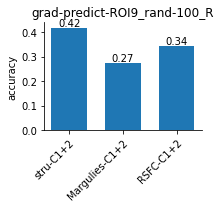

In [2]:
figsize = (3, 3)
Hemi = 'R'
n_rand = 100
# grad_names = ('stru-C1', 'stru-C2', 'stru-C1+2')
grad_names = ('stru-C1+2', 'Margulies-C1+2', 'RSFC-C1+2')

title = 'grad-predict-ROI9'
pkl_file = pjoin(anal_dir, 'predict/{title}_{grad_name}_rand-{n_rand}_{Hemi}.pkl')
out_name = f'{title}_rand-{n_rand}_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

n_grad = len(grad_names)
ys = np.zeros(n_grad)
yerrs = np.zeros(n_grad)
for grad_idx, grad_name in enumerate(grad_names):
    data = pkl.load(open(
        pkl_file.format(title=title, grad_name=grad_name, n_rand=n_rand, Hemi=Hemi), 'rb'
    ))
    accs = np.mean(data['test_score'], 1)
    ys[grad_idx] = np.mean(accs)
    yerrs[grad_idx] = sem(accs)
    print('random level:', 1 / len(data['roi_name']))

plot_bar(ys, figsize=figsize, yerr=yerrs, xticklabel=grad_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=out_name)


## PC_predict_ALFF

### 将多个文件的预测分数按照一定的排列画到一张图上

mean:
 [[0.33434538]
 [0.05487536]
 [0.39277451]]

sem:
 [[0.0102966 ]
 [0.00278198]
 [0.01007338]]


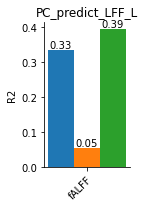

In [4]:
figsize = (2, 3)
label_flag = False
Hemi = 'L'
trg_names = ('fALFF',)

pc_names = ('PC1', 'PC2', 'PC1+2')
n_pc = len(pc_names)
n_trg = len(trg_names)
pkl_file = pjoin(anal_dir, 'predict/{pc_name}_predict_{trg}_{Hemi}H.pkl')
out_name = f'PC_predict_LFF_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

ys = np.zeros((n_pc, n_trg))
yerrs = np.zeros((n_pc, n_trg))
for pc_idx, pc_name in enumerate(pc_names):
    for trg_idx, trg in enumerate(trg_names):
        data = pkl.load(open(
            pkl_file.format(pc_name=pc_name, trg=trg, Hemi=Hemi), 'rb'
        ))
        ys[pc_idx, trg_idx] = np.mean(data['test_score'])
        yerrs[pc_idx, trg_idx] = sem(data['test_score'])

if label_flag:
    label = pc_names
else:
    label = None
plot_bar(ys, figsize=figsize, label=label, xticklabel=trg_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='R2', mode=out_file, title=out_name)
print('mean:\n', ys)
print('\nsem:\n', yerrs)

## PC_predict_ALFF1

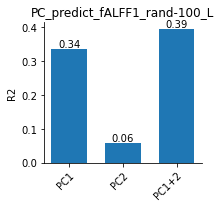

In [3]:
figsize = (3, 3)
Hemi = 'L'
n_rand = 100
grad_names = ('PC1', 'PC2', 'PC1+2')
trg = 'fALFF1'

title = 'grad-predict-ROI9'
pkl_file = pjoin(anal_dir, 'predict/{grad_name}_predict_{trg}_rand-{n_rand}_{Hemi}H.pkl')
out_name = f'PC_predict_{trg}_rand-{n_rand}_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

n_grad = len(grad_names)
ys = np.zeros(n_grad)
yerrs = np.zeros(n_grad)
for grad_idx, grad_name in enumerate(grad_names):
    data = pkl.load(open(
        pkl_file.format(grad_name=grad_name, trg=trg, n_rand=n_rand, Hemi=Hemi), 'rb'
    ))
    scores = np.mean(data['test_score'], 1)
    ys[grad_idx] = np.mean(scores)
    yerrs[grad_idx] = sem(scores)

plot_bar(ys, figsize=figsize, yerr=yerrs, xticklabel=grad_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='R2', mode=out_file, title=out_name)


## PC_predict_ROI7

### 对每个文件，输出基本信息，以及类别正确率和大小（按照类别正确率由大到小排序）

#ROI: 44
train scores: [0.1647258098666102, 0.16282024137200932, 0.15435104806267202, 0.16387889053567647, 0.15982218458933106]
train score: 0.16111963488525982
test scores: [0.15749364944961897, 0.15495342929720576, 0.17696867061812024, 0.14987298899237933, 0.1576271186440678]
test score: 0.1593831714002784
pearsonr: PearsonRResult(statistic=0.0094062431677556, pvalue=0.4699164063531139)
accuracy: 0.15938346883468835
accs corr sizes: PearsonRResult(statistic=0.42185153118791197, pvalue=0.004342550119046344)
accs corr sizes (rank): SignificanceResult(statistic=0.5313660452875094, pvalue=0.00020615204671264488)


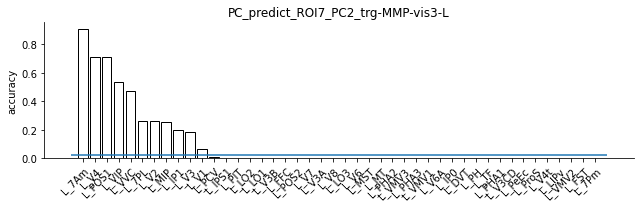

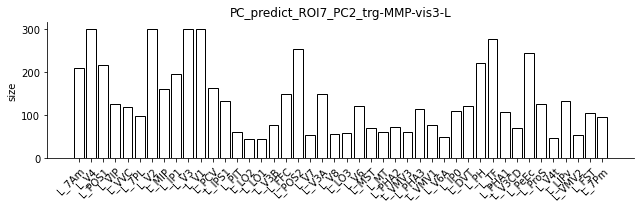

In [4]:
# figsize = (6, 3)
# fname = 'PC_predict_ROI7_PC1+2_trg-Wang2015-R'

figsize = (9, 3)
fname = 'PC_predict_ROI7_PC2_trg-MMP-vis3-L'

pkl_file = pjoin(anal_dir, f'predict/{fname}.pkl')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')
out_file = True

pkl_data = pkl.load(open(pkl_file, 'rb'))
rois = pkl_data['roi_name']
n_roi = len(rois)
print('#ROI:', n_roi)
print('train scores:', pkl_data['train_score'])
print('train score:', np.mean(pkl_data['train_score']))
print('test scores:', pkl_data['test_score'])
print('test score:', np.mean(pkl_data['test_score']))

y_true = pkl_data['y_true']
y_pred = pkl_data['y_pred']
print('pearsonr:', pearsonr(y_true, y_pred))
print('accuracy:', np.mean(y_true == y_pred))
class_accs = np.zeros(n_roi, np.float64)
class_sizes = np.zeros(n_roi, np.uint16)
roi_name2key = pkl_data['roi_name2key']
for roi_idx, roi in enumerate(rois):
    class_mask = y_true == roi_name2key[roi]
    y_true_tmp = y_true[class_mask]
    y_pred_tmp = y_pred[class_mask]
    class_accs[roi_idx] = np.mean(y_true_tmp == y_pred_tmp)
    class_sizes[roi_idx] = np.sum(class_mask)
assert pkl_data['roi_size'] == class_sizes.tolist()
sort_indices = np.argsort(class_accs)[::-1]
rois = tuple(rois[i] for i in sort_indices)
class_accs = class_accs[sort_indices]
class_sizes = class_sizes[sort_indices]
print('accs corr sizes:', pearsonr(class_accs, class_sizes))
print('accs corr sizes (rank):', spearmanr(class_accs, class_sizes))

x = np.arange(n_roi)
fig, ax = plt.subplots(figsize=figsize)
rects = ax.bar(x, class_accs, ec='k', fc='w')
# show_bar_value(rects, '.4f', ax)
ax.set_xticks(x)
ax.set_xticklabels(rois)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('accuracy')
ax.set_title(fname)
ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=figsize)
rects = ax2.bar(x, class_sizes, ec='k', fc='w')
ax2.set_xticks(x)
ax2.set_xticklabels(rois)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_ylabel('size')
ax2.set_title(fname)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.tight_layout()

if not out_file:
    fig.show()
    fig2.show()
else:
    fig.savefig(out_file1)
    fig2.savefig(out_file2)

### 将多个文件的正确率按照一定的排列画到一张图上

MMP-vis3-L random level: 0.022727272727272728
[[0.28760163]
 [0.15938347]
 [0.44563008]]


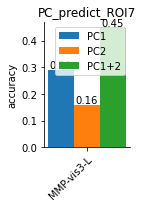

In [4]:
# figsize = (3, 3)
# trg_names = ('MMP-vis3-R', 'Wang2015-R')

figsize = (2, 3)
trg_names = ('MMP-vis3-L',)

title = 'PC_predict_ROI7'
pc_names = ('PC1', 'PC2', 'PC1+2')
n_pc = len(pc_names)
n_trg = len(trg_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_trg-{trg}.pkl')
out_file = pjoin(work_dir, f'{title}.jpg')
out_file = 'show'

accs = np.zeros((n_pc, n_trg))
first_flag = True
for pc_idx, pc_name in enumerate(pc_names):
    for trg_idx, trg in enumerate(trg_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, trg=trg), 'rb'
        ))
        accs[pc_idx, trg_idx] = np.mean(data['y_true'] == data['y_pred'])
        if first_flag:
            print(f'{trg} random level:', 1 / len(data['roi_name']))
    first_flag = False
plot_bar(accs, figsize=figsize, label=pc_names, xticklabel=trg_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=title)
print(accs)

## PC_predict_ROI6

### 将多个文件的正确率按照一定的排列画到一张图上

R_V1~4's true ROI keys: [1 2 3]
MMP-vis3-R_ex(V1~4)'s true ROI keys: [1 2 3]
R_V1~4's true ROI keys: [1 2 3]
MMP-vis3-R_ex(V1~4)'s true ROI keys: [1 2 3]


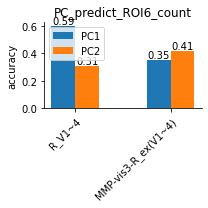

In [12]:
figsize = (4.8, 8)
trg = 'count'
title = f'PC_predict_ROI6_{trg}'
pc_names = ('PC1', 'PC2')
n_pc = len(pc_names)
mask_names = ('R_V1~4', 'MMP-vis3-R_ex(V1~4)')
n_mask = len(mask_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_mask-{mask_name}.pkl')
out_file = pjoin(work_dir, f'{title}.jpg')

accs = np.zeros((n_pc, n_mask))
for pc_idx, pc_name in enumerate(pc_names):
    for mask_idx, mask_name in enumerate(mask_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, mask_name=mask_name), 'rb'
        ))
        accs[pc_idx, mask_idx] = np.mean(data['y_true'] == data['y_pred'])
        print(f"{mask_name}'s true ROI keys:", np.unique(data['y_true']))
plot_bar(accs, figsize=(3, 3), label=pc_names, xticklabel=mask_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=title)

## PC_predict_ROI4/5

### 对每个文件，输出基本信息，以及类别正确率和大小（按照类别正确率由大到小排序）

#ROI: 44
train scores: [0.07967389290346488, 0.08893829905503058, 0.08058540200074102, 0.08688403112263801, 0.08595776213412375]
train score: 0.08440787744319965
train scores (new): [0.1387794100083602, 0.14736507431841667, 0.13329393223010244, 0.13105917532263142, 0.1299952614120992]
train score (new): 0.13609857065832198
test scores: [0.07703703703703704, 0.09111111111111111, 0.07412898443291327, 0.08821349147516679, 0.07635285396590066]
test score: 0.08136869560442576
pearsonr: PearsonRResult(statistic=-0.01683217675456836, pvalue=0.16683699582662254)
accuracy: 0.08136949755446865
accs corr sizes: PearsonRResult(statistic=-0.23733455246614785, pvalue=0.12084529364058283)
accs corr sizes (rank): SignificanceResult(statistic=-0.5829598470783647, pvalue=3.29012982103072e-05)


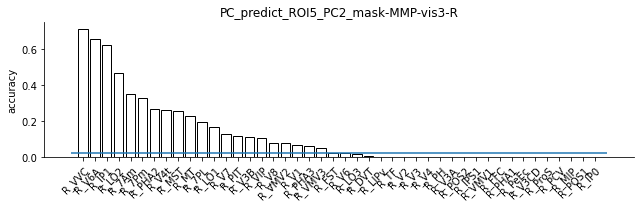

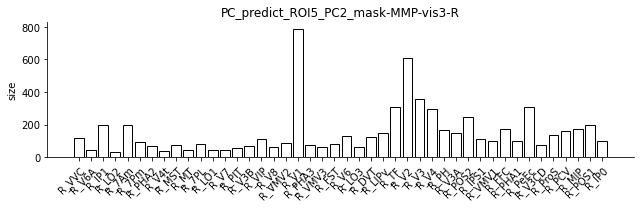

In [3]:
# figsize = (8.5, 3)
# fname = 'PC_predict_ROI5_PC1_mask-MMP-vis3-R_ex(V1~4)'

# figsize = (2, 3)
# fname = 'PC_predict_ROI5_PC1+2_mask-MMP-vis3-R-early'

figsize = (9, 3)
# fname = 'PC_predict_ROI4_PC1+3+4+5+6+7+8+9+10_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI4_PC2_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI4_PC1+2_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI4_PC1+3_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI4_PC1+6_mask-MMP-vis3-R'
fname = 'PC_predict_ROI5_PC2_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI5_PC1+2_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI5_PC1+3_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI5_PC1+6_mask-MMP-vis3-R'
# fname = 'PC_predict_ROI5_PC1+9_mask-MMP-vis3-R'

pkl_file = pjoin(anal_dir, f'predict/{fname}.pkl')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')
out_file = True

pkl_data = pkl.load(open(pkl_file, 'rb'))
rois = pkl_data['roi_name']
n_roi = len(rois)
print('#ROI:', n_roi)
print('train scores:', pkl_data['train_score'])
print('train score:', np.mean(pkl_data['train_score']))
if 'ROI5' in fname:
    print('train scores (new):', pkl_data['train_score_new'])
    print('train score (new):', np.mean(pkl_data['train_score_new']))
print('test scores:', pkl_data['test_score'])
print('test score:', np.mean(pkl_data['test_score']))

y_true = pkl_data['y_true']
y_pred = pkl_data['y_pred']
print('pearsonr:', pearsonr(y_true, y_pred))
print('accuracy:', np.mean(y_true == y_pred))
class_accs = np.zeros(n_roi, np.float64)
class_sizes = np.zeros(n_roi, np.uint16)
for roi_idx, roi in enumerate(rois):
    class_mask = y_true == mmp_name2label[roi]
    y_true_tmp = y_true[class_mask]
    y_pred_tmp = y_pred[class_mask]
    class_accs[roi_idx] = np.mean(y_true_tmp == y_pred_tmp)
    class_sizes[roi_idx] = np.sum(class_mask)
sort_indices = np.argsort(class_accs)[::-1]
rois = tuple(rois[i] for i in sort_indices)
class_accs = class_accs[sort_indices]
class_sizes = class_sizes[sort_indices]
print('accs corr sizes:', pearsonr(class_accs, class_sizes))
print('accs corr sizes (rank):', spearmanr(class_accs, class_sizes))

x = np.arange(n_roi)
fig, ax = plt.subplots(figsize=figsize)
rects = ax.bar(x, class_accs, ec='k', fc='w')
# show_bar_value(rects, '.4f', ax)
ax.set_xticks(x)
ax.set_xticklabels(rois)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('accuracy')
ax.set_title(fname)
ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=figsize)
rects = ax2.bar(x, class_sizes, ec='k', fc='w')
ax2.set_xticks(x)
ax2.set_xticklabels(rois)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_ylabel('size')
ax2.set_title(fname)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.tight_layout()

if not out_file:
    fig.show()
    fig2.show()
else:
    fig.savefig(out_file1)
    fig2.savefig(out_file2)

### 将多个文件的正确率按照一定的排列画到一张图上

MMP-vis3-L random level: 0.022727272727272728
MMP-vis3-L-early random level: 0.25
MMP-vis3-L-dorsal random level: 0.05263157894736842
MMP-vis3-L-lateral random level: 0.1111111111111111
MMP-vis3-L-ventral random level: 0.08333333333333333


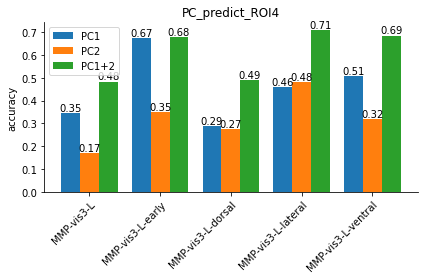

In [2]:
# figsize = (3, 3)
# mask_names = ('R_V1~4', 'MMP-vis3-R_ex(V1~4)')

# figsize = (8, 4)
# mask_names = (
#     'MMP-vis3-R', 'MMP-vis3-R-early', 'MMP-vis3-R-dorsal',
#     'MMP-vis3-R-lateral', 'MMP-vis3-R-ventral',
#     'MMP-vis3-R-forefront', 'MMP-vis3-R-ventral_ex(forefront)')
# mask_names = (
#     'MMP-vis3-R', 'MMP-vis3-R-early', 'MMP-vis3-R-dorsal',
#     'MMP-vis3-R-lateral', 'MMP-vis3-R-ventral',
#     'MMP-vis3-R-ventral_ex(forefront)', 'MMP-vis3-R_ex(V1~4)')

figsize = (6, 4)
mask_names = (
    'MMP-vis3-L', 'MMP-vis3-L-early', 'MMP-vis3-L-dorsal',
    'MMP-vis3-L-lateral', 'MMP-vis3-L-ventral')

title = 'PC_predict_ROI4'
pc_names = ('PC1', 'PC2', 'PC1+2')
n_pc = len(pc_names)
n_mask = len(mask_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_mask-{mask_name}.pkl')
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

accs = np.zeros((n_pc, n_mask))
first_flag = True
for pc_idx, pc_name in enumerate(pc_names):
    for mask_idx, mask_name in enumerate(mask_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, mask_name=mask_name), 'rb'
        ))
        accs[pc_idx, mask_idx] = np.mean(data['y_true'] == data['y_pred'])
        if first_flag:
            print(f'{mask_name} random level:', 1 / len(data['roi_name']))
    first_flag = False
plot_bar(accs, figsize=figsize, label=pc_names, xticklabel=mask_names, show_height='.2f',
         rotate_xticklabel=True, ylabel='accuracy', mode=out_file, title=title)

### 不同mask画到不同ax，同一mask的不同pc的正确率画到同一ax中

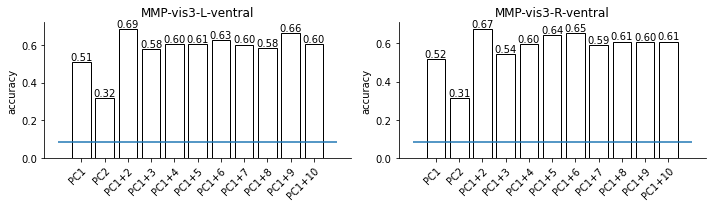

In [5]:
# figsize = (4.8, 3)
# title = 'PC_predict_ROI5'
# pc_names = ('PC1', 'PC1+2', 'PC2')
# mask_names = ('R_V1~4', 'MMP-vis3-R_ex(V1~4)')
# out_file = pjoin(work_dir, f'{title}.jpg')

# figsize = (5, 3)
# title = 'PC_predict_ROI4'
# pc_names = ['PC1'] + [f'PC1+{i}' for i in range(2, 11)]
# mask_names = ('MMP-vis3-L',)
# out_file = pjoin(work_dir, f'{title}.jpg')

# figsize = (6, 3)
# part = 'early'
# title = 'PC_predict_ROI4'
# pc_names = ['PC1', 'PC2'] + [f'PC1+{i}' for i in range(2, 6)]
# mask_names = (f'MMP-vis3-L-{part}', f'MMP-vis3-R-{part}')
# out_file = pjoin(work_dir, f'{title}_{part}.jpg')

figsize = (10, 3)
part = 'ventral'
title = 'PC_predict_ROI4'
pc_names = ['PC1', 'PC2'] + [f'PC1+{i}' for i in range(2, 11)]
mask_names = (f'MMP-vis3-L-{part}', f'MMP-vis3-R-{part}')
out_file = pjoin(work_dir, f'{title}_{part}.jpg')

# ylim = (0.33, None)
n_pc = len(pc_names)
n_mask = len(mask_names)
pkl_file = pjoin(anal_dir, 'predict/{title}_{pc_name}_mask-{mask_name}.pkl')
x = np.arange(n_pc)
fig, axes = plt.subplots(1, n_mask, figsize=figsize)
for mask_idx, mask_name in enumerate(mask_names):
    if n_mask == 1:
        ax = axes
    else:
        ax = axes[mask_idx]
    accs = np.zeros(n_pc)
    n_roi = None
    for pc_idx, pc_name in enumerate(pc_names):
        data = pkl.load(open(
            pkl_file.format(title=title, pc_name=pc_name, mask_name=mask_name), 'rb'
        ))
        accs[pc_idx] = np.mean(data['y_true'] == data['y_pred'])
        if n_roi is None:
            n_roi = len(data['roi_name'])
        else:
            assert n_roi == len(data['roi_name'])
    rects = ax.bar(x, accs, ec='k', fc='w')
    show_bar_value(rects, '.2f', ax)
    ax.set_xticks(x)
    ax.set_xticklabels(pc_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylabel('accuracy')
    ax.set_title(mask_name)
    ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
fig.savefig(out_file)

## PC12_predict_ROI2/3

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


44
train scores: [0.40541041319251436, 0.4059662775616083, 0.40385327899221934, 0.4153390144497962, 0.3962578732864024]
train score: 0.40536537149650814
train scores (new): [0.3750149289382539, 0.3713933709562038, 0.3796690307328605, 0.3860166824047844, 0.36159374506397096]
train score (new): 0.37473755161921474
test scores: [0.3837037037037037, 0.40296296296296297, 0.4225352112676056, 0.3936249073387695, 0.40252038547071906]
test score: 0.40106943414875207
pearsonr: (0.6369658863971307, 0.0)
accuracy: 0.401067140951534
accs corr sizes: (0.16066151326179556, 0.2974975900679198)
accs corr sizes (rank): SpearmanrResult(correlation=-0.13407112803616172, pvalue=0.3855850431292933)


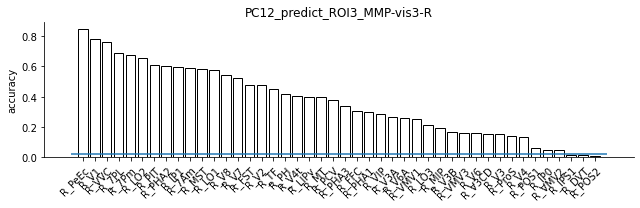

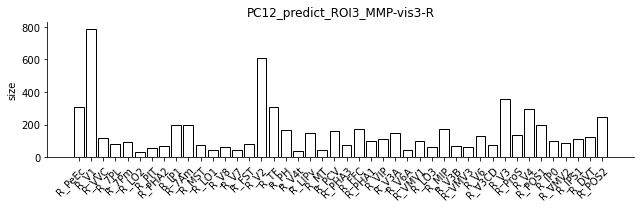

In [2]:
figsize = (9, 3)
vis_name = 'MMP-vis3-R'
atlas = Atlas('HCP-MMP')
rois = get_rois(vis_name)
mask = atlas.get_mask(rois)
fname = f'PC12_predict_ROI3_{vis_name}'
pkl_file = pjoin(anal_dir, f'predict/{fname}.pkl')
cii_file = pjoin(anal_dir, f'predict/{fname}.dlabel.nii')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')
out_file = True

n_roi = len(rois)
print(n_roi)
pkl_data = pkl.load(open(pkl_file, 'rb'))
print('train scores:', pkl_data['train_score'])
print('train score:', np.mean(pkl_data['train_score']))
print('train scores (new):', pkl_data['train_score_new'])
print('train score (new):', np.mean(pkl_data['train_score_new']))
print('test scores:', pkl_data['test_score'])
print('test score:', np.mean(pkl_data['test_score']))

y_true = atlas.maps[mask]
y_pred = nib.load(cii_file).get_fdata()[mask]
print('pearsonr:', pearsonr(y_true, y_pred))
print('accuracy:', np.mean(y_true == y_pred))
class_accs = np.zeros(n_roi, np.float64)
class_sizes = np.zeros(n_roi, np.uint16)
for roi_idx, roi in enumerate(rois):
    class_mask = y_true == mmp_name2label[roi]
    y_true_tmp = y_true[class_mask]
    y_pred_tmp = y_pred[class_mask]
    class_accs[roi_idx] = np.mean(y_true_tmp == y_pred_tmp)
    class_sizes[roi_idx] = np.sum(class_mask)
sort_indices = np.argsort(class_accs)[::-1]
rois = tuple(rois[i] for i in sort_indices)
class_accs = class_accs[sort_indices]
class_sizes = class_sizes[sort_indices]
print('accs corr sizes:', pearsonr(class_accs, class_sizes))
print('accs corr sizes (rank):', spearmanr(class_accs, class_sizes))

x = np.arange(n_roi)
fig, ax = plt.subplots(figsize=figsize)
rects = ax.bar(x, class_accs, ec='k', fc='w')
# show_bar_value(rects, '.4f', ax)
ax.set_xticks(x)
ax.set_xticklabels(rois)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax.set_ylabel('accuracy')
ax.set_title(fname)
ax.hlines(1/n_roi, x[0]-1, x[-1]+1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.tight_layout()

fig2, ax2 = plt.subplots(figsize=figsize)
rects = ax2.bar(x, class_sizes, ec='k', fc='w')
ax2.set_xticks(x)
ax2.set_xticklabels(rois)
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
ax2.set_ylabel('size')
ax2.set_title(fname)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
fig2.tight_layout()

if not out_file:
    fig.show()
    fig2.show()
else:
    fig.savefig(out_file1)
    fig2.savefig(out_file2)

# BigBrain

## 32k_fs_LR to bigbrain

[array([[0.68892117, 0.68624661, 0.68332008, 0.68176279, 0.68014316,
        0.67672329]]), array([[0.04874859, 0.0389713 , 0.02811633, 0.02231554, 0.01699182,
        0.0158908 ]])]


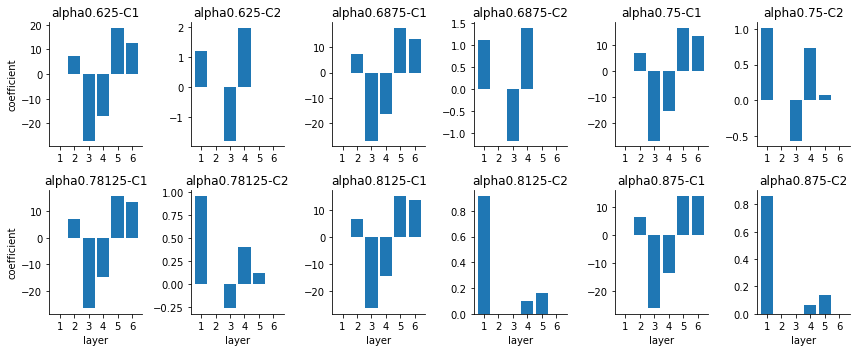

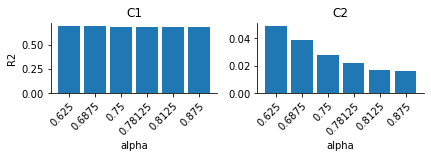

In [4]:
fname = 'Msp1~6-s2_lasso_PC12-164fsLR2bigbrain_R_fine1'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')

data = pkl.load(open(fpath, 'rb'))
n_alpha = len(data['alpha'])
y1s = []
title1s = []
y2s = [np.zeros(n_alpha), np.zeros(n_alpha)]
title2s = list(data['PC name'])
for a_idx, alpha in enumerate(data['alpha']):
    k_name = f'alpha{alpha}'
    for pc_idx, pc_name in enumerate(data['PC name']):
        y1s.append(data[k_name]['coef'][pc_idx])
        title1s.append(f'{k_name}-{pc_name}')
        y2s[pc_idx][a_idx] = data[k_name]['R2'][pc_idx]

plot_bar(
    y1s, 2, 6, xlabel='layer', figsize=(12, 5),
    xticklabel=tuple(data['layer ID']), ylabel='coefficient',
    title=title1s, mode=out_file1)
plot_bar(
    y2s, 1, 2, xlabel='alpha', figsize=(6, 2.3),
    xticklabel=tuple(data['alpha']), ylabel='R2',
    title=title2s, mode=out_file2, rotate_xticklabel=True)
print(y2s)

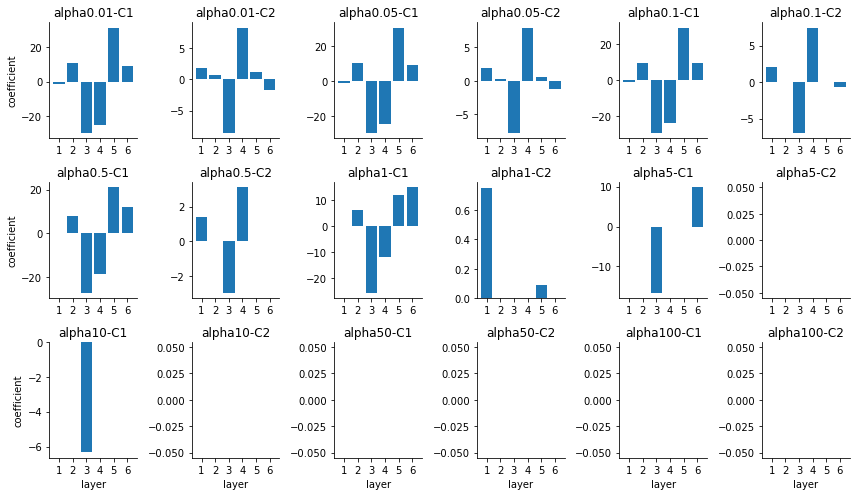

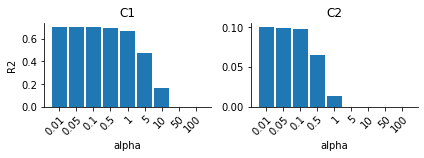

In [4]:
fname = 'Msp1~6-s2_lasso_PC12-164fsLR2bigbrain_R'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file1 = pjoin(work_dir, f'{fname}1.jpg')
out_file2 = pjoin(work_dir, f'{fname}2.jpg')

data = pkl.load(open(fpath, 'rb'))
n_alpha = len(data['alpha'])
y1s = []
title1s = []
y2s = [np.zeros(n_alpha), np.zeros(n_alpha)]
title2s = list(data['PC name'])
for a_idx, alpha in enumerate(data['alpha']):
    k_name = f'alpha{alpha}'
    for pc_idx, pc_name in enumerate(data['PC name']):
        y1s.append(data[k_name]['coef'][pc_idx])
        title1s.append(f'{k_name}-{pc_name}')
        y2s[pc_idx][a_idx] = data[k_name]['R2'][pc_idx]

plot_bar(
    y1s, 3, 6, xlabel='layer', figsize=(12, 7),
    xticklabel=tuple(data['layer ID']), ylabel='coefficient',
    title=title1s, mode=out_file1)
plot_bar(
    y2s, 1, 2, xlabel='alpha', figsize=(6, 2.3),
    xticklabel=tuple(data['alpha']), ylabel='R2',
    title=title2s, mode=out_file2, rotate_xticklabel=True)

C1 R2: 0.6688745882476561
C2 R2: 0.01345310350804707


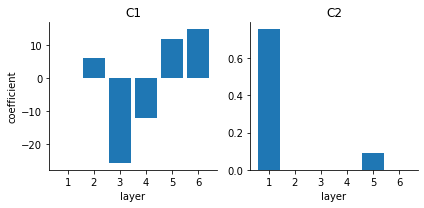

In [5]:
fname = 'Msp1~6-s2_fit-lasso_PC12-164fsLR2bigbrain_R'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
ys = []
titles = []
for pc_idx, pc_name in enumerate(data['PC name']):
    ys.append(data['coef'][pc_idx])
    titles.append(pc_name)
    print(f'{pc_name} R2:', data['R2'][pc_idx])

plot_bar(
    ys, 1, 2, xlabel='layer', figsize=(6, 3),
    xticklabel=tuple(data['layer ID']), ylabel='coefficient',
    title=titles, mode=out_file)

C1_corr_layer-mean-p: [3.82466890e-026 5.40825660e-196 0.00000000e+000 0.00000000e+000
 3.33922369e-128 1.18588352e-245]
C2_corr_layer-mean-p: [6.86446885e-246 5.87644474e-001 3.40274534e-083 6.21395954e-003
 8.88188296e-007 9.15340970e-001]


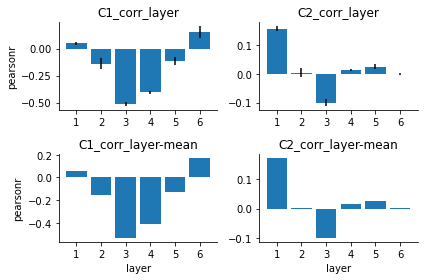

In [5]:
# fname = '164fsLR2bigbrain_L_s2'
fname = 'fsavg2bigbrain_R_s2'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
y = [
    np.mean(data['C1_corr_layer'], 0),
    np.mean(data['C2_corr_layer'], 0),
    data['C1_corr_layer-mean'],
    data['C2_corr_layer-mean']]
yerr = [
    sem(data['C1_corr_layer'], 0),
    sem(data['C2_corr_layer'], 0),
    None, None]
title = [
    'C1_corr_layer', 'C2_corr_layer',
    'C1_corr_layer-mean', 'C2_corr_layer-mean']

print('C1_corr_layer-mean-p:', data['C1_corr_layer-mean-p'])
print('C2_corr_layer-mean-p:', data['C2_corr_layer-mean-p'])
plot_bar(
    y, 2, 2, yerr=yerr, xlabel='layer',
    xticklabel=data['layer_name'], ylabel='pearsonr',
    title=title, mode=out_file)

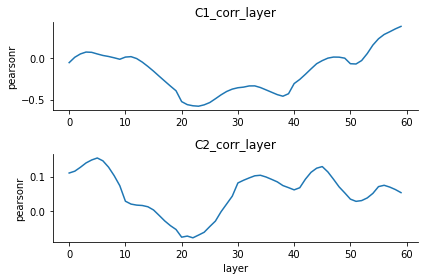

In [5]:
fname = '164fsLR2bigbrain_R_s2'
fpath = pjoin(anal_dir, f'bigbrain/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}_60.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
y = [
    data['C1_corr_layer'].reshape((-1,), order='F'),
    data['C2_corr_layer'].reshape((-1,), order='F')]
title = ['C1_corr_layer', 'C2_corr_layer']

plot_line(
    y, 2, 1, xlabel='layer', ylabel='pearsonr',
    title=title, mode=out_file,)

## bigbrain to 32k_fs_LR

### Msp1~6_corr_PC12

C1_corr_layer-mean-p:
 [7.70856171e-001 6.17499778e-021 0.00000000e+000 8.80745567e-298
 5.43111519e-048 2.55985894e-013]
C2_corr_layer-mean-p:
 [8.24322047e-16 2.47249015e-03 5.34956607e-08 4.44729600e-05
 1.63116941e-03 2.80078389e-01]
C1_corr_layer-mean-permutation-Pvalue:
 [7.74522548e-01 1.99980002e-04 1.99980002e-04 1.99980002e-04
 1.99980002e-04 1.99980002e-04]
C2_corr_layer-mean-permutation-Pvalue:
 [1.99980002e-04 1.19988001e-03 1.99980002e-04 1.99980002e-04
 1.99980002e-03 2.63173683e-01]
===after bonferroni===
C1_corr_layer-mean-p:
 [1.00000000e+000 3.70499867e-020 0.00000000e+000 5.28447340e-297
 3.25866911e-047 1.53591536e-012]
C2_corr_layer-mean-p:
 [4.94593228e-15 1.48349409e-02 3.20973964e-07 2.66837760e-04
 9.78701645e-03 1.00000000e+00]
C1_corr_layer-mean-permutation-Pvalue:
 [1.         0.00119988 0.00119988 0.00119988 0.00119988 0.00119988]
C2_corr_layer-mean-permutation-Pvalue:
 [0.00119988 0.00719928 0.00119988 0.00119988 0.0119988  1.        ]


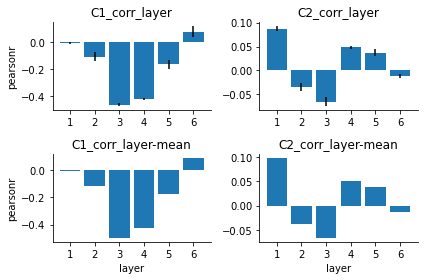

In [3]:
fname = 'PC12-corr-msp_R'
fpath = pjoin(anal_dir, f'bigbrain/to_32fsLR/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.svg')
out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
y = [
    np.mean(data['C1_corr_layer'], 0),
    np.mean(data['C2_corr_layer'], 0),
    data['C1_corr_layer-mean'],
    data['C2_corr_layer-mean']]
yerr = [
    sem(data['C1_corr_layer'], 0),
    sem(data['C2_corr_layer'], 0),
    None, None]
title = [
    'C1_corr_layer', 'C2_corr_layer',
    'C1_corr_layer-mean', 'C2_corr_layer-mean']

print('C1_corr_layer-mean-p:\n', data['C1_corr_layer-mean-p'])
print('C2_corr_layer-mean-p:\n', data['C2_corr_layer-mean-p'])
print('C1_corr_layer-mean-permutation-Pvalue:\n', data['C1_corr_layer-mean-pmt-p'])
print('C2_corr_layer-mean-permutation-Pvalue:\n', data['C2_corr_layer-mean-pmt-p'])
_, ps1, _, _ = multipletests(data['C1_corr_layer-mean-p'], 0.05, 'bonferroni')
_, ps2, _, _ = multipletests(data['C2_corr_layer-mean-p'], 0.05, 'bonferroni')
_, ps3, _, _ = multipletests(data['C1_corr_layer-mean-pmt-p'], 0.05, 'bonferroni')
_, ps4, _, _ = multipletests(data['C2_corr_layer-mean-pmt-p'], 0.05, 'bonferroni')
print('===after bonferroni===')
print('C1_corr_layer-mean-p:\n', ps1)
print('C2_corr_layer-mean-p:\n', ps2)
print('C1_corr_layer-mean-permutation-Pvalue:\n', ps3)
print('C2_corr_layer-mean-permutation-Pvalue:\n', ps4)
plot_bar(
    y, 2, 2, yerr=yerr, xlabel='layer',
    xticklabel=data['layer_name'], ylabel='pearsonr',
    title=title, mode=out_file)

### Msp1~6_corr_PC12竖着画

===PC12-corr-msp_R===
C1_corr_layer_mean-r
Layer1(-0.003546479044022815), Layer2(-0.11392884049061104), Layer3(-0.4966159516632211), Layer4(-0.4273807308023768), Layer5(-0.17584698719444483), Layer6(0.08890409791223275), 
>>>C1_corr_layer-mean-p
---significant---
Layer2(6.174997778108127e-21), Layer3(0.0), Layer4(8.807455668029453e-298), Layer5(5.431115190389652e-48), Layer6(2.5598589404458803e-13)
---not significant---
Layer1(0.7708561707047576)
C1_corr_layer-mean-p<<<
>>>C1_corr_layer-mean-p (bonf)
---significant---
Layer2(3.704998666864876e-20), Layer3(0.0), Layer4(5.284473400817672e-297), Layer5(3.2586691142337914e-47), Layer6(1.5359153642675282e-12)
---not significant---
Layer1(1.0)
C1_corr_layer-mean-p (bonf)<<<
C2_corr_layer_mean-r
Layer1(0.0977929178894674), Layer2(-0.03684217980305845), Layer3(-0.06615925484359188), Layer4(0.049685297206744694), Layer5(0.03834544828324543), Layer6(-0.013151875812934873), 
>>>C2_corr_layer-mean-p
---significant---
Layer1(8.243220466484687e-16),

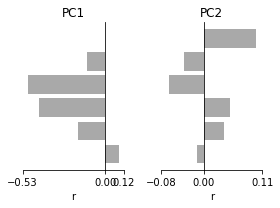

In [3]:
figsize = (4, 3)
fname = 'PC12-corr-msp_R'
pc_names = ('C1', 'C2')
fpath = pjoin(anal_dir, f'bigbrain/to_32fsLR/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.svg')
out_file = 'show'

n_pc = len(pc_names)
data = pkl.load(open(fpath, 'rb'))
lyr_names = [f'Layer{i}' for i in data['layer_name']]
n_lyr = len(lyr_names)
y = np.arange(n_lyr)
fig, axes = plt.subplots(1, n_pc, figsize=figsize)
print(f'==={fname}===')
for pc_idx, pc_name in enumerate(pc_names):
    ax = axes[pc_idx]
    x = data[f'{pc_name}_corr_layer-mean'][::-1]
    ax.barh(y, x, color='darkgray')
    ax.set_title(f'P{pc_name}')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_position(('data',0))
    ax.tick_params(left=False, labelleft=False)
    tick_refiner = TickRefinery(ax)
    xticks = tick_refiner.set_xticks_as_limit(2, 2)
    ax.set_xticks([xticks[0], 0, xticks[1]])
    ax.set_xlabel('r')

    print(f'{pc_name}_corr_layer_mean-r')
    for r, lyr_name in zip(data[f'{pc_name}_corr_layer-mean'], lyr_names):
        print(f'{lyr_name}({r})', end=', ')
    print()
    p_type = f'{pc_name}_corr_layer-mean-p'
    ps = data[p_type]
    print_ps(ps, lyr_names, p_type)
    _, ps_bonf, _, _ = multipletests(ps, 0.05, 'bonferroni')
    print_ps(ps_bonf, lyr_names, f'{p_type} (bonf)')
print('\n'*10)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### Msp1~6_fit_PC12

C1 R2: 0.5249726222190045
C2 R2: 0.06879845511437277


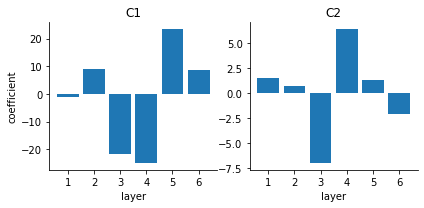

In [2]:
fname = 'Msp1~6_fit-ordinary_PC12_R'
fpath = pjoin(anal_dir, f'bigbrain/to_32fsLR/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

data = pkl.load(open(fpath, 'rb'))
ys = []
titles = []
for pc_idx, pc_name in enumerate(data['PC name']):
    ys.append(data['coef'][pc_idx])
    titles.append(pc_name)
    print(f'{pc_name} R2:', data['R2'][pc_idx])

plot_bar(
    ys, 1, 2, xlabel='layer', figsize=(6, 3),
    xticklabel=tuple(data['layer ID']), ylabel='coefficient',
    title=titles, mode=out_file)

# ROI Scalar

## 检查区域内变异和区域间变异的关系

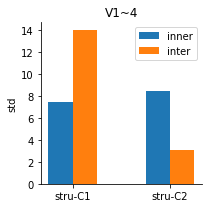

In [4]:
# roi_title = 'MMP-vis3-R'
# roi_title = 'ex(V1~4)'
roi_title = 'V1~4'
figsize = (3, 3)
pc_names = ('stru-C1', 'stru-C2')
rois = get_rois('MMP-vis3-R')
fpath = pjoin(anal_dir, 'ROI_scalar/ROI_scalar1_MMP-vis3-R.csv')
out_file = pjoin(work_dir, 'PC12-inner-inter-var.jpg')
# out_file = 'show'

df = pd.read_csv(fpath, index_col=0)
if roi_title == 'MMP-vis3-R':
    assert sorted(df.columns) == sorted(rois)
elif roi_title == 'ex(V1~4)':
    for roi in ['R_V1', 'R_V2', 'R_V3', 'R_V4']:
        rois.remove(roi)
elif roi_title == 'V1~4':
    rois = ['R_V1', 'R_V2', 'R_V3', 'R_V4']
else:
    raise ValueError

labels = ('inner', 'inter')
y_inner = [np.mean(df.loc[f'std_{pc_name}', rois]) for pc_name in pc_names]
y_inter = [np.std(df.loc[f'mean_{pc_name}', rois], ddof=1) for pc_name in pc_names]
y = np.array([y_inner, y_inter])

plot_bar(y, figsize=figsize, label=labels, xticklabel=pc_names,
         title=roi_title, ylabel='std', mode=out_file)

## 画多个ROI随年龄的变化曲线

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


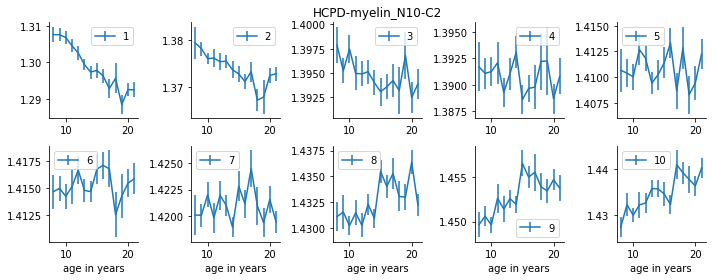

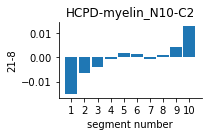

In [19]:
# set parameters
age_mask = 'remove567'
src_file = pjoin(anal_dir, 'ROI_scalar/HCPD-myelin_N10-C2.csv')
rois = [str(i) for i in np.arange(1, 11)]
arrange_flag = None  # OP-gdist, M+T-PC1
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
# n_row, n_col = 5, 9
# figsize = (18, 10)
# n_row, n_col = 1, 3
# figsize = (6, 2)
n_row, n_col = 2, 5
figsize = (10, 4)
ylim = None
title = 'HCPD-myelin_N10-C2'
mode1 = pjoin(work_dir, f'{title}-1.jpg')
mode2 = pjoin(work_dir, f'{title}-2.jpg')
# mode1 = 'show'
# mode2 = 'show'

# arrange ROIs
if arrange_flag is None:
    pass
elif arrange_flag == 'OP-gdist':
    # 依据各ROI离枕极的距离从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/gdist_src-OccipitalPole_HCP-MMP.csv'
    ))
    arrange_values = df_tmp.loc[0, rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
elif arrange_flag == 'M+T-PC1':
    # 依据各ROI在HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj PC1中的均值从小到大排序
    df_tmp = pd.read_csv(pjoin(
        anal_dir, 'ROI_scalar/HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_HCP-MMP.csv'
    ), index_col=0)
    arrange_values = df_tmp.loc['C1', rois]
    sort_indices = np.argsort(arrange_values)
    rois = [rois[i] for i in sort_indices]
else:
    raise ValueError

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True
)
key_groups = [(i,) for i in rois]
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), n_row=n_row, n_col=n_col, x=[ages_uniq]*len(rois),
    figsize=figsize, yerr=prepare_y_bar_line(yerr_dict, key_groups),
    label=key_groups, xlabel=age_name, ylim=ylim, title=title, mode=mode1
)

y2 = np.zeros(len(rois), np.float64)
for roi_idx, roi in enumerate(rois):
    y2[roi_idx] = y_dict[roi][-1] - y_dict[roi][0]
plot_bar(y2, figsize=(3, 2), show_height=None, xlabel='segment number',
         xticklabel=tuple(rois), ylabel='21-8', title=title, mode=mode2)

## 把多个ROI的发育趋势画到同一个ax里

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


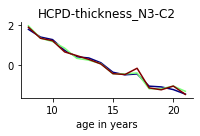

In [7]:
# set parameters
age_mask = 'remove567'
fname = 'HCPD-thickness_N3-C2'
src_file = pjoin(anal_dir, f'ROI_scalar/{fname}.csv')
rois = [str(i) for i in np.arange(1, 4)]
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, 3)
colors = tuple(cmap(color_indices[i]) for i in range(3))
labels = None
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
n_row, n_col = 1, 1
figsize = (3, 2)
zscore_flag = True
mode = pjoin(work_dir, f'{fname}.jpg')
# mode = 'show'

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True)
key_groups = [rois]
if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, n_row=n_row, n_col=n_col, x=ages_uniq, figsize=figsize, yerr=yerr,
    label=labels, xlabel=age_name, title=fname, mode=mode, color=colors
)

## 把ROI分组，同一组的画到同一个ax里

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


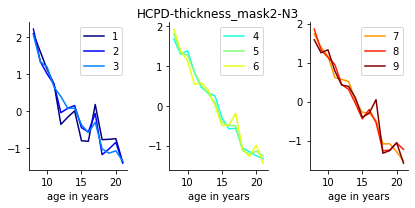

In [13]:
# set parameters
age_mask = 'remove567'
fname = 'HCPD-thickness_mask2-N3'
src_file = pjoin(anal_dir, f'ROI_scalar/{fname}.csv')
rois = [str(i) for i in np.arange(1, 10)]
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, 9)
colors = [
    tuple(cmap(color_indices[i]) for i in range(3)),
    tuple(cmap(color_indices[i]) for i in range(3, 6)),
    tuple(cmap(color_indices[i]) for i in range(6, 9))]
labels = [tuple(rois[:3]), tuple(rois[3:6]), tuple(rois[6:])]
info_file = pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv')
age_name = 'age in years'
n_row, n_col = 1, 3
n_ax = 3
figsize = (6, 3)
zscore_flag = True
mode = pjoin(work_dir, f'{fname}.jpg')
# mode = 'show'

# calculating
src_df = pd.read_csv(src_file)
src_data = np.array(src_df.loc[:, rois]).T
ages = np.array(pd.read_csv(info_file)[age_name])
ages_uniq = np.unique(ages)
if age_mask is None:
    pass
elif age_mask == 'remove567':
    # 舍弃5, 6, 7岁的被试
    print(ages_uniq)
    ages_uniq = ages_uniq[3:]
    print(ages_uniq)
else:
    raise ValueError
y_dict, yerr_dict = summary_across_col_by_mask(
    src_data, ages, ages_uniq, ['mean', 'sem'], row_names=rois, out_dict=True)
key_groups = labels
if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, n_row=n_row, n_col=n_col, x=[ages_uniq] * n_ax, figsize=figsize,
    yerr=yerr, label=labels, xlabel=age_name, title=fname, mode=mode, color=colors
)

# Plot Age Distribution

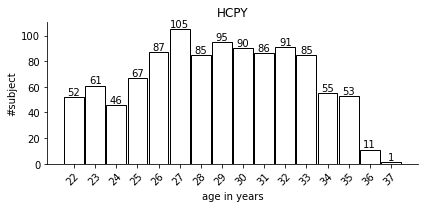

In [2]:
dataset_name = 'HCPY'
figsize = (6, 3)
# figsize = (13, 3)
age_name = 'age in years'
fpath = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
out_file = pjoin(work_dir, f'{dataset_name}_age_dist.jpg')
# out_file = 'show'

df = pd.read_csv(fpath)
ages = np.array(df[age_name])
ages_uniq = np.unique(ages)

y = np.zeros_like(ages_uniq, int)
for idx, age in enumerate(ages_uniq):
    y[idx] = np.sum(ages == age)

plot_bar(y, figsize=figsize, x=ages_uniq, fc_ec_flag=True,
         fc=('w',), ec=('k',), show_height='', xlabel=age_name,
         xticklabel=ages_uniq, rotate_xticklabel=True,
         ylabel='#subject', title=dataset_name, mode=out_file)

# Plot Cluster

## 把detect_community1得到的各map的modularity用bar图展示

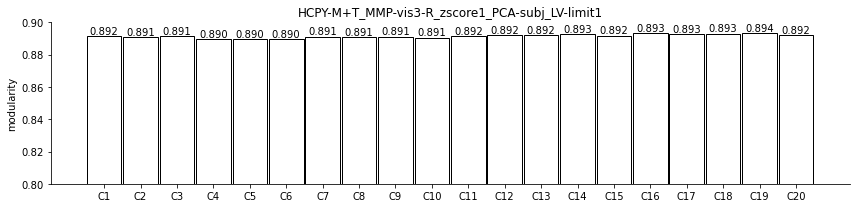

In [3]:
fname = 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1'
df = pd.read_csv(pjoin(anal_dir, f'cluster/{fname}.csv'))
plot_bar(np.array(df['modularity']), figsize=(12, 3) ,fc_ec_flag=True, fc=('w',), ec=('k',),
         show_height='.3f', xticklabel=tuple(df['name']), ylabel='modularity', ylim=(0.8, 0.9),
         title=fname, mode=pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_LV-limit1.jpg'))

# Plot Decomposition

## PCA behavior data

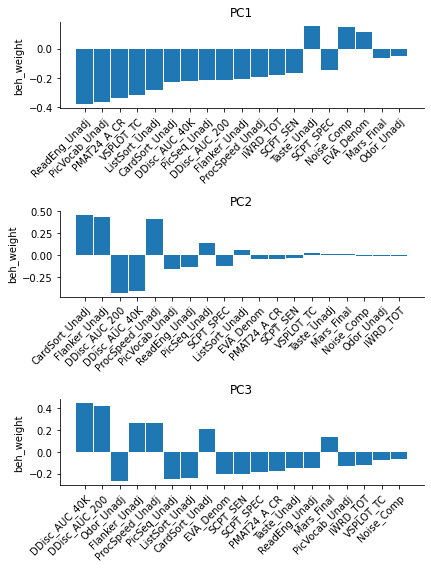

In [2]:
# settings
figsize = (6, 8)
fname = 'PCA_beh_data_v1_IQR2'
n_pc = 3
data_file = pjoin(anal_dir, f'decomposition/{fname}.pkl')
out_name = f'beh-weight_{fname}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

# load
data = pkl.load(open(data_file, 'rb'))
titles = []
ys = []
xticklabels = []
for pc_idx in range(n_pc):
    y = data['PCA']['beh_weight'][pc_idx]
    sorted_indices = np.argsort(np.abs(y))[::-1]
    xticklabel = tuple(data['beh_name'][i] for i in sorted_indices)
    ys.append(y[sorted_indices])
    xticklabels.append(xticklabel)
    title = data['PCA']['component_name'][pc_idx]
    titles.append(f'P{title}')

plot_bar(ys, n_pc, 1, figsize, xticklabel=xticklabels,
         rotate_xticklabel=True, ylabel='beh_weight',
         title=titles, mode=out_file)

## 单模态主成分与联合MT的主次梯度的相关

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


shape=(n_pc, n_mod)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


L:
 [[ 0.95973856  0.90481328]
 [-0.28082217  0.42574579]]
R:
 [[ 0.94664099  0.87834376]
 [-0.32223545  0.47799128]]


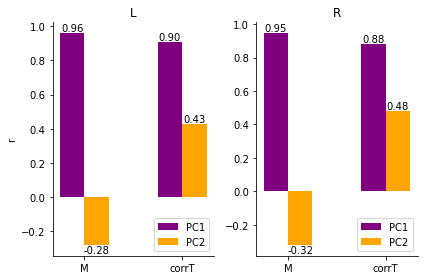

In [2]:
figsize = (6, 4)
Hemis = ['L', 'R']
vis_names = 'MMP-vis3-{Hemi}'
mod_names = ('M', 'corrT')
pc_names = ('PC1', 'PC2')
multi_mod_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj.dscalar.nii')
uni_mod_file = pjoin(
    anal_dir, 'decomposition/'
    'HCPY-{mod}_{vis_name}_zscore1_PCA-subj.dscalar.nii')
out_name = 'uni-C1_corr_multi-C1C2'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

n_Hemi = len(Hemis)
n_mod = len(mod_names)
n_pc = len(pc_names)
pc_colors = tuple(meas2color[i] for i in pc_names)

ys = []
print('shape=(n_pc, n_mod)')
for Hemi in Hemis:
    y = np.zeros((n_pc, n_mod))
    vis_name = vis_names.format(Hemi=Hemi)
    vis_mask = Atlas('HCP-MMP').get_mask(get_rois(vis_name))[0]
    pc_maps = nib.load(
        multi_mod_file.format(vis_name=vis_name)
    ).get_fdata()[:n_pc, vis_mask]
    for mod_idx, mod in enumerate(mod_names):
        uni_map = nib.load(
            uni_mod_file.format(mod=mod, vis_name=vis_name)
        ).get_fdata()[0, vis_mask]
        for pc_idx, pc_name in enumerate(pc_names):
            pc_map = pc_maps[pc_idx]
            y[pc_idx, mod_idx] = pearsonr(uni_map, pc_map)[0]
    ys.append(y)
    print(f'{Hemi}:\n', y)

fig, axes, n_ax = plot_bar(
    ys, 1, n_Hemi, figsize, color=[pc_colors]*2,
    xticklabel=mod_names, ylabel='r', title=Hemis, mode='go on',
    show_height='.2f', label=[pc_names]*2
)
# for ax in axes[0]:
#     tick_refiner = TickRefinery(ax)
#     tick_refiner.set_yticks_as_limit(2, 1)

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## 统计被试内的M+T联合空间PCA的参数在所有被试中的分布

### 所有被试的被试内C1和C2的方差占比分布

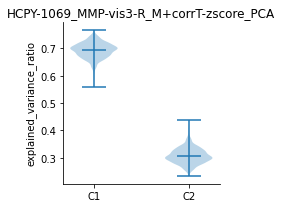

In [2]:
figsize = (3, 3)
fname = 'HCPY-1069_MMP-vis3-R_M+corrT-zscore_PCA'
fpath = pjoin(anal_dir, f'decomposition/{fname}.csv')
out_file = pjoin(work_dir, f'{fname}_var.jpg')
out_file = 'show'

pc_names = ('C1', 'C2')
xs = np.arange(len(pc_names))
ylabel = 'explained_variance_ratio'
df = pd.read_csv(fpath)
datasets = [df[f'{i}_{ylabel}'].values for i in pc_names]
fig, ax = plt.subplots(figsize=figsize)
ax.violinplot(datasets, xs, showmeans=True)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks(xs)
ax.set_xticklabels(pc_names)
ax.set_ylabel(ylabel)
ax.set_title(fname)
fig.tight_layout()

if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 所有被试内myelin和(corr)thickness对C1和C2的权重占比

[[1.27619591e-08 1.27619591e-08]
 [1.27619591e-08 1.27619591e-08]]


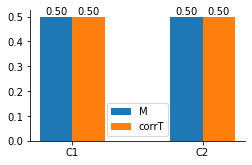

In [4]:
figsize = (3.6, 2.4)
fname = 'HCPY-1069_MMP-vis3-R_M+corrT-zscore_PCA'
fpath = pjoin(anal_dir, f'decomposition/{fname}.csv')
pc_names = ('C1', 'C2')
meas_names = ('M', 'corrT')
out_file = pjoin(work_dir, f'{fname}_proportion.jpg')
# out_file = 'show'

meas2name = {'M': 'M', 'T': 'T', 'corrT': 'T'}

df = pd.read_csv(fpath)
n_pc = len(pc_names)
n_meas = len(meas_names)
ys = np.zeros((n_meas, n_pc))
yerrs = np.zeros((n_meas, n_pc))
for pc_idx, pc_name in enumerate(pc_names):
    col1 = f'{pc_name}_weight_{meas2name[meas_names[0]]}'
    col2 = f'{pc_name}_weight_{meas2name[meas_names[1]]}'
    weights1 = np.abs(df[col1].values)
    weights2 = np.abs(df[col2].values)
    weights_sum = weights1 + weights2
    proportion1 = weights1 / weights_sum
    proportion2 = weights2 / weights_sum
    ys[0, pc_idx] = np.mean(proportion1)
    ys[1, pc_idx] = np.mean(proportion2)
    yerrs[0, pc_idx] = sem(proportion1)
    yerrs[1, pc_idx] = sem(proportion2)

print(yerrs)
plot_bar(ys, yerr=yerrs, figsize=figsize, label=meas_names, mode=out_file, show_height='.2f',
         xticklabel=pc_names, ylabel=None)

## 把多个模态同一个成分的权重时间序列画到只有单个ax的fig里（线图）

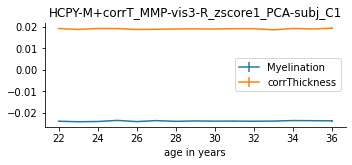

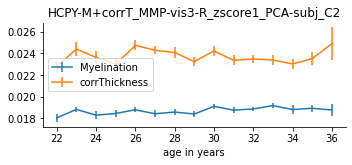

In [4]:
# settings
zscore_flag = False
fname = 'HCPY-M+corrT_MMP-vis3-R_zscore1_PCA-subj'
fpaths = [f'{fname}_M.csv', f'{fname}_corrT.csv']
labels = ('Myelination', 'corrThickness')
cols = ['C1', 'C2']
key_groups_list = [[['0-C1', '1-C1']], [['0-C2', '1-C2']]]
titles = [f'{fname}_C1', f'{fname}_C2']
info_file = pjoin(proj_dir, 'data/HCP/HCPY_SubjInfo.csv')
out_files = [
    pjoin(work_dir, f'{fname}_C1.jpg'),
    pjoin(work_dir, f'{fname}_C2.jpg')]
# out_files = ['show', 'show']

# load
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages).tolist()
ages_uniq.remove(37)
ages_uniq = np.array(ages_uniq)

# start
data = []
row_names = []
for f_idx, fpath in enumerate(fpaths):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fpath}'))
    data.append(np.array(df[cols]).T)
    row_names.extend([f'{f_idx}-{col}' for col in cols])
data = np.concatenate(data, 0)
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=row_names, zscore_flag=zscore_flag, out_dict=True
)
for i, key_groups in enumerate(key_groups_list):
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
    plot_line(y, n_row=1, n_col=1, figsize=(5, 2.4), yerr=yerr, x=ages_uniq,
              label=labels, color=None, mode=out_files[i], xlabel=age_name, xtick=None,
              xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=titles[i])

## 把多个成分多个模态的权重平均大小画到只有单个ax的fig里

### bar图

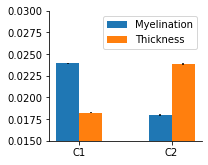

In [10]:
# settings
fnames = [
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_M.csv',
    'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj_T.csv'
]
meas = ('Myelination', 'Thickness')
cols = ('C1', 'C2')
ylim = (0.015, 0.03)
# ylim = None
# out_file = pjoin(work_dir, 'HCPY-M+T_MMP-vis3-R_zscore1_PCA-subj.jpg')
out_file = 'show'

# start
n_fname = len(fnames)
n_col = len(cols)
y = np.zeros((n_fname, n_col), np.float64)
yerr = np.zeros((n_fname, n_col), np.float64)
for f_idx, fname in enumerate(fnames):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fname}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.mean(samples)
        yerr[f_idx, col_idx] = sem(samples)
plot_bar(
    y, n_row=1, n_col=1, figsize=(3, 2.4), yerr=yerr, x=None, width=None,
    label=meas, color=None, show_height=None, mode=out_file, xlabel=None,
    xticklabel=cols, rotate_xticklabel=False, ylabel=None, ylim=ylim, title=None
)

### violin图

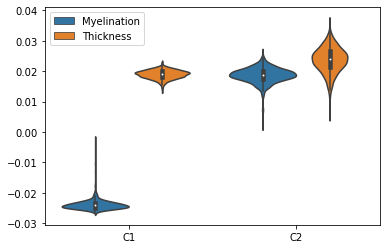

In [3]:
# settings
Hemi = 'R'
fname = f'HCPY-M+corrT_MMP-vis3-{Hemi}_zscore1_PCA-subj'
fpaths = [f'{fname}_M.csv', f'{fname}_corrT.csv']
meas = ('Myelination', 'Thickness')
cols = ('C1', 'C2')
out_file = pjoin(work_dir, f'weights-M+corrT_violin_{Hemi}.jpg')
# out_file = 'show'

# start
n_col = len(cols)
data = {'weight': [], 'PC': [], 'meas': []}
for f_idx, fpath in enumerate(fpaths):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fpath}'))
    n_subj = df.shape[0]
    data['meas'].extend([meas[f_idx]] * n_subj * n_col)
    for col_idx, col in enumerate(cols):
        data['weight'].extend(df[col].values)
        data['PC'].extend([col] * n_subj)

sns.violinplot(data=data, x="PC", y="weight", hue="meas")
if out_file == 'show':
    plt.show()
else:
    plt.savefig(out_file)

## 把多个成分多个模态的权重占比画到只有单个ax的fig里

### bar图

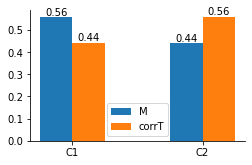

In [3]:
# settings
fname = 'HCPY-M+corrT_MMP-vis3-L_zscore1_PCA-subj'
fpaths = [f'{fname}_M.csv', f'{fname}_corrT.csv']
# meas = ('Myelination', 'corrThickness')
meas = ('M', 'corrT')
cols = ('C1', 'C2')
out_file = pjoin(work_dir, f'{fname}_proportion.jpg')
# out_file = 'show'

# start
n_fpath = len(fpaths)
n_col = len(cols)
y = np.zeros((n_fpath, n_col), np.float64)
for f_idx, fpath in enumerate(fpaths):
    df = pd.read_csv(pjoin(anal_dir, f'decomposition/{fpath}'))
    for col_idx, col in enumerate(cols):
        samples = np.array(df[col])
        samples = np.abs(samples[~np.isnan(samples)])
        y[f_idx, col_idx] = np.sum(samples)
y /= np.sum(y, 0, keepdims=True)
plot_bar(
    y, figsize=(3.6, 2.4), label=meas, mode=out_file, show_height='.2f',
    xticklabel=cols, ylabel=None)

### stacked bar图

{'Myelination': array([0.55818635, 0.44011731]), 'Thickness': array([0.44181365, 0.55988269])}


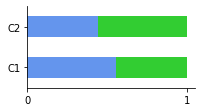

In [3]:
# settings
figsize = (3, 1.5)
Hemi = 'L'
vis_name = f'MMP-vis3-{Hemi}'
pc_names = ('C1', 'C2')
meas_names = ('Myelination', 'Thickness')
color = [meas2color[i] for i in meas_names]
meas2file = {
    'Myelination': pjoin(anal_dir, 'decomposition/'
        f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_M.csv'),
    'Thickness': pjoin(anal_dir, 'decomposition/'
        f'HCPY-M+corrT_{vis_name}_zscore1_PCA-subj_corrT.csv')}
out_name = f'weights-M+corrT_stacked-prop_{Hemi}'
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

# start
n_meas = len(meas_names)
n_pc = len(pc_names)
y = np.zeros((n_meas, n_pc))
for meas_idx, meas_name in enumerate(meas_names):
    df = pd.read_csv(meas2file[meas_name])
    for pc_idx, pc_name in enumerate(pc_names):
        samples = np.abs(df[pc_name].values)
        y[meas_idx, pc_idx] = np.sum(samples)
y /= np.sum(y, 0, keepdims=True)
data = {meas_names[0]: y[0], meas_names[1]: y[1]}
print(data)

# plot
fig, ax = plt.subplots(1, 1, figsize=figsize)
df = pd.DataFrame(data=data, index=pc_names)
df.plot.barh(stacked=True, color=color, ax=ax)
ax.legend('', frameon=False)
xticks = (0, 1)
ax.set_xticks(xticks)
ax.set_xticklabels(xticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
if out_file == 'show':
    plt.show()
else:
    plt.savefig(out_file)

## 把单个文件中的不同column画到不同ax里

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]


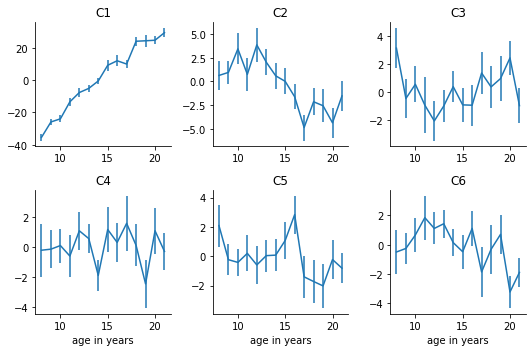

In [13]:
# settings
fname = 'HCPD-T_MMP-vis3-R_zscore0_PCA-vtx'
fpath = pjoin(anal_dir, f'decomposition/{fname}.csv')
cols = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6']
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

age_name = 'age in years'
ages = pd.read_csv(pjoin(proj_dir, 'data/HCP/HCPD_SubjInfo.csv'))[age_name]
ages_uniq = np.unique(ages).tolist()
print(ages_uniq)
for age in [5, 6, 7]:
    ages_uniq.remove(age)
print(ages_uniq)
ages_uniq = np.array(ages_uniq)

# start
n_col = len(cols)
df = pd.read_csv(fpath)
data = np.array(df[cols]).T
y, yerr = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    tol_size=10, nan_mode=False, row_names=None, zscore_flag=False, out_dict=False
)
key_groups = [[i] for i in range(n_col)]
y = prepare_y_bar_line(y, key_groups)
yerr = prepare_y_bar_line(yerr, key_groups)
plot_line(y, n_row=2, n_col=3, figsize=(7.5, 5), yerr=yerr, x=[ages_uniq]*n_col,
          label=None, color=None, mode=out_file, xlabel=age_name, xtick=None,
          xticklabel=None, rotate_xticklabel=False, ylabel=None, ylim=None, title=cols)

# Plot Fit

## stru_PC_fit_beh_PC

>>>L_C1
---significant---
C1(0.018053238510838166), C3(0.03383065511760334), C8(0.019943941264317346)
---not significant---
C2(0.25585276358040787), C4(0.1093177664667983), C5(0.10730760540613728), C6(0.28905036799972894), C7(0.13850905282351836), C9(0.13384915799541133), C10(0.3122873992385119)
L_C1<<<
>>>R_C1
---significant---
C3(0.00653671672603716), C4(0.013591544091618604), C5(0.04143082426575151), C7(0.028736299491767772)
---not significant---
C1(0.06300509424121523), C2(0.16486287136493896), C6(0.18710139291542352), C8(0.1167521136769853), C9(0.160584793443632), C10(0.1282285253869669)
R_C1<<<
>>>L_C2
---significant---
C1(4.5810927898068465e-09), C3(0.049874934721823465), C5(0.0022053723020327353), C6(4.089533560271069e-06), C7(0.028001711147097014)
---not significant---
C2(0.10117839798872826), C4(0.3067427033435193), C8(0.13803360195722525), C9(0.3058434362453441), C10(0.07138112973874765)
L_C2<<<
>>>R_C2
---significant---
C1(1.2275397266764912e-10), C3(0.014143858624393487), 

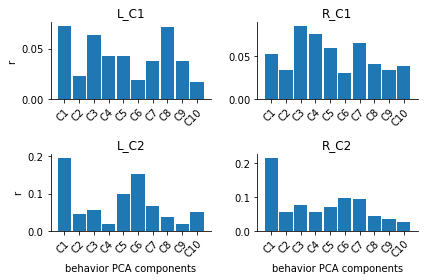

In [2]:
figsize = (6, 4)
stru_pcs = ['L_C1', 'R_C1',
            'L_C2', 'R_C2']
n_beh_pc = 10
fname = 'stru_PC_fit_beh_PC_v1_IQR2'
data_file = pjoin(anal_dir, f'fit/{fname}.pkl')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

ylabel = 'r'
xlabel = 'behavior PCA components'
data = pkl.load(open(data_file, 'rb'))
beh_pcs = tuple(data['beh_pc'][:n_beh_pc])

ys = []
for stru_pc in stru_pcs:
    ys.append(data[stru_pc]['r'][:n_beh_pc])
    ps = data[stru_pc]['p'][:n_beh_pc]
    print_ps(ps, beh_pcs, p_type=stru_pc)
print('\n'*10)

plot_bar(ys, 2, 2, figsize, xlabel=xlabel, xticklabel=beh_pcs,
         rotate_xticklabel=True, ylabel=ylabel, title=stru_pcs,
         mode=out_file)

## weight_CCA_beh

### 第一对成分之间的相关

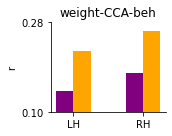

>>>r-value
PC1-LH(0.14199828976667744), PC1-RH(0.17859731838174583), PC2-LH(0.22191055011347677), PC2-RH(0.2617803866376782), r-value<<<

>>>p-value
---significant---
PC1-LH(9.127542068830917e-06), PC1-RH(3.390092479593229e-08), PC2-LH(4.739921146291814e-12), PC2-RH(4.1898598593993883e-16)
---not significant---

p-value<<<
>>>p-value (fdr)
---significant---
PC1-LH(9.127542068830917e-06), PC1-RH(4.5201233061243057e-08), PC2-LH(9.479842292583628e-12), PC2-RH(1.6759439437597553e-15)
---not significant---

p-value (fdr)<<<
>>>p-value (bonf)
---significant---
PC1-LH(3.651016827532367e-05), PC1-RH(1.3560369918372917e-07), PC2-LH(1.8959684585167256e-11), PC2-RH(1.6759439437597553e-15)
---not significant---

p-value (bonf)<<<
















In [2]:
ylim = (0.1, 0.28)
pc_name2v = {'PC1': 'v31', 'PC2': 'v32'}

# ylim = (0.06, 0.16)
# pc_name2v = {'PC1': 'v33', 'PC2': 'v34'}

figsize = (2.5, 2)
Hemis = ('L', 'R')
pc_names = ('PC1', 'PC2')
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_MMP-vis3-{Hemi}_{v}.pkl')
out_name = 'weight-CCA-beh'
out_file = pjoin(work_dir, f'{out_name}.svg')
out_file = 'show'

arr_shape = (len(pc_names), len(Hemis))
rs = np.zeros(arr_shape, np.float64)
rs_print = []
ps = []
p_names = []
for pc_idx, pc_name in enumerate(pc_names):
    for Hemi_idx, Hemi in enumerate(Hemis):
        cca_dict = pkl.load(open(fpath.format(
            Hemi=Hemi, v=pc_name2v[pc_name]), 'rb'))
        x = cca_dict['X_trans'][:, 0]
        y = cca_dict['Y_trans'][:, 0]
        r, p = pearsonr(x, y, alternative='greater')
        rs[pc_idx, Hemi_idx] = r
        rs_print.append(r)
        ps.append(p)
        p_names.append(f'{pc_name}-{Hemi}H')

xticklabels = tuple(f'{i}H' for i in Hemis)
colors = tuple(meas2color[i] for i in pc_names)
plot_bar(rs, 1, 1, figsize, color=colors, xticklabel=xticklabels,
         ylabel='r', title=out_name, mode='go on', ylim=ylim)
tick_refiner = TickRefinery()
tick_refiner.set_yticks_as_limit(2, 2)
if out_file == 'show':
    plt.show()
else:
    plt.savefig(out_file)

print(f'>>>r-value')
r_names = p_names
for r, r_name in zip(rs_print, r_names):
    print(f'{r_name}({r})', end=', ')
print()
print(f'r-value<<<')
print()

print_ps(ps, p_names, 'p-value')
_, ps_fdr, _, _ = multipletests(ps, 0.05, 'fdr_bh')
print_ps(ps_fdr, p_names, 'p-value (fdr)')
_, ps_bonf, _, _ = multipletests(ps, 0.05, 'bonferroni')
print_ps(ps_bonf, p_names, 'p-value (bonf)')
print('\n'*13)

### 各行为指标组合形成第一个行为成分的权重的偏侧化

CCA_BWR-LI_v32:
 [ 0.63720243  0.54109853  0.52219138  0.41945679  0.35271253  0.20480988
 -0.08734591 -0.12244557 -0.16521652 -0.397372   -0.3978654  -0.49470898
 -0.64315876 -0.7166939  -0.92975712]


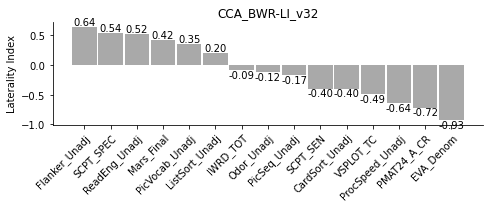

In [3]:
w_type = 'BWR'  # BW（权重幅值）或BWR（权重比例）
figsize = (7, 3)
cca_ver = 'v32'
fpath_lh = pjoin(anal_dir, f'fit/weight-CCA-beh_MMP-vis3-L_{cca_ver}.pkl')
fpath_rh = pjoin(anal_dir, f'fit/weight-CCA-beh_MMP-vis3-R_{cca_ver}.pkl')
out_name = f'CCA_{w_type}-LI_{cca_ver}'
out_file = pjoin(work_dir, f'{out_name}.jpg')
# out_file = 'show'

data_lh = pkl.load(open(fpath_lh, 'rb'))
data_rh = pkl.load(open(fpath_rh, 'rb'))

assert data_lh['target names'] == data_rh['target names']
trg_names = data_lh['target names']

y_lh = np.abs(data_lh['model'].y_rotations_[:, 0])
y_rh = np.abs(data_rh['model'].y_rotations_[:, 0])
if w_type == 'BW':
    pass
elif w_type == 'BWR':
    y_lh = y_lh / np.sum(y_lh)
    y_rh = y_rh / np.sum(y_rh)
else:
    raise ValueError

LI_vec = (y_lh - y_rh) / (y_lh + y_rh)
sorted_indices = np.argsort(LI_vec)[::-1]
y = LI_vec[sorted_indices]
xticklabels = tuple(trg_names[i] for i in sorted_indices)
print(f'{out_name}:\n', y)

plot_bar(
    y, n_row=1, n_col=1, figsize=figsize, show_height='.2f',
    color=('darkgray',), xticklabel=xticklabels, rotate_xticklabel=True, 
    ylabel='Laterality Index', title=out_name, mode=out_file)

### 各行为指标组合形成第一个行为成分的权重

===L===
>>>BWR
PicVocab_Unadj(0.3319769328416146), Flanker_Unadj(0.11798674536906018), ReadEng_Unadj(0.09587934572364763), PicSeq_Unadj(0.08697729988933142), Mars_Final(0.0756652619710256), ListSort_Unadj(0.048448472655129214), SCPT_SEN(0.045418817928487336), VSPLOT_TC(0.04190857482983608), IWRD_TOT(0.03699718313848712), SCPT_SPEC(0.03294402788368081), CardSort_Unadj(0.026063462682847777), PMAT24_A_CR(0.02433367403570562), Odor_Unadj(0.02317752892742175), ProcSpeed_Unadj(0.011194375758570687), EVA_Denom(0.0010282963651540254), BWR<<<
cumulative BWR from PicVocab_Unadj to PicVocab_Unadj 0.3319769328416146
cumulative BWR from PicVocab_Unadj to Flanker_Unadj 0.4499636782106748
cumulative BWR from PicVocab_Unadj to ReadEng_Unadj 0.5458430239343224
cumulative BWR from PicVocab_Unadj to PicSeq_Unadj 0.6328203238236538
cumulative BWR from PicVocab_Unadj to Mars_Final 0.7084855857946795
cumulative BWR from PicVocab_Unadj to ListSort_Unadj 0.7569340584498087
cumulative BWR from PicVocab_Unadj t

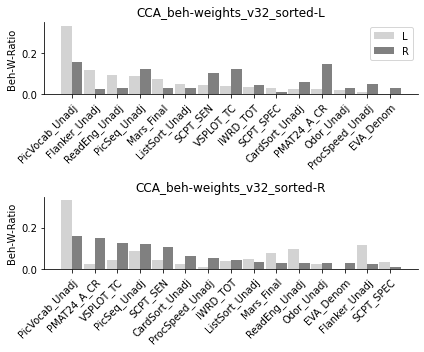

In [2]:
figsize = (6, 5)
Hemis = ('L', 'R')
colors = ('lightgray', 'gray')
cca_ver = 'v32'
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_MMP-vis3-{Hemi}_{v}.pkl')
out_name = f'CCA_beh-weights_{cca_ver}'
titles = [f'{out_name}_sorted-{i}' for i in Hemis]
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

n_Hemi = len(Hemis)
trg_names = None
Hemi2bwr = {}
for Hemi in Hemis:
    cca_dict = pkl.load(open(
        fpath.format(Hemi=Hemi, v=cca_ver), 'rb'))
    ws = np.abs(cca_dict['model'].y_rotations_[:, 0])
    Hemi2bwr[Hemi] = ws / np.sum(ws)
    if trg_names is None:
        trg_names = cca_dict['target names']
    else:
        assert trg_names == cca_dict['target names']
n_trg = len(trg_names)

ys = []
xticklabels = []
for Hemi in Hemis:
    y = np.zeros((n_Hemi, n_trg))
    sort_indices = np.argsort(Hemi2bwr[Hemi])[::-1]
    for Hemi_idx, Hemi in enumerate(Hemis):
        y[Hemi_idx] = Hemi2bwr[Hemi][sort_indices]
    ys.append(y)
    sorted_names = tuple(trg_names[i] for i in sort_indices)
    xticklabels.append(sorted_names)

plot_bar(
    ys, n_row=n_Hemi, n_col=1, figsize=figsize,
    label=[Hemis, None], color=[colors]*n_Hemi, 
    xticklabel=xticklabels, rotate_xticklabel=True, 
    ylabel='Beh-W-Ratio', ylim=None, title=titles, mode=out_file)

for Hemi_idx, Hemi in enumerate(Hemis):
    print(f'==={Hemi}===')
    bwr_vec = ys[Hemi_idx][Hemi_idx]
    sorted_names = xticklabels[Hemi_idx]
    print('>>>BWR')
    for trg_name, bwr in zip(sorted_names, bwr_vec):
        print(f'{trg_name}({bwr})', end=', ')
    print('BWR<<<')
    cumulative_bwr = 0
    for trg_idx, trg_name in enumerate(sorted_names):
        cumulative_bwr += bwr_vec[trg_idx]
        print(f'cumulative BWR from {sorted_names[0]} to {trg_name}', cumulative_bwr)
    print()

### 梯度成分和各个行为之间的回归分数

===v34_predict score_PC2-LH===
>>>r value
DDisc_AUC_200(0.10315648864770476), DDisc_AUC_40K(0.0989629397024467), Taste_Unadj(0.06789281399596248), Noise_Comp(0.03790341741208766), PainInterf_Tscore(0.026529008005678464), PainIntens_RawScore(0.008271197617848435)
r value<<<
>>>p value
>>>predict score
---significant---
DDisc_AUC_200(0.0005664616911434365), DDisc_AUC_40K(0.0008973729900605237), Taste_Unadj(0.016209506576337292)
---not significant---
Noise_Comp(0.11636945071153516), PainInterf_Tscore(0.201838153365673), PainIntens_RawScore(0.3973095000993723)
predict score<<<
>>>predict score (fdr)
---significant---
DDisc_AUC_200(0.0026921189701815712), DDisc_AUC_40K(0.0026921189701815712), Taste_Unadj(0.032419013152674585)
---not significant---
Noise_Comp(0.17455417606730275), PainInterf_Tscore(0.2422057840388076), PainIntens_RawScore(0.3973095000993723)
predict score (fdr)<<<
>>>predict score (bonf)
---significant---
DDisc_AUC_200(0.003398770146860619), DDisc_AUC_40K(0.00538423794036314

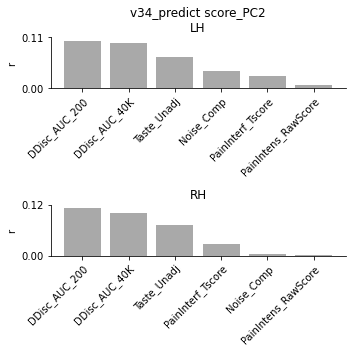

In [3]:
# settings
meas_type = 'predict score'  # 'predict score' or 'direct corr'
figsize = (5, 5)
Hemis = ('L', 'R')
cca_ver = 'v34'
fpath = pjoin(anal_dir, 'fit/weight-CCA-beh_MMP-vis3-{Hemi}_{v}.pkl')
out_name = f'CCA_grad-predict-beh_{cca_ver}'
out_file = pjoin(work_dir, f'{out_name}.svg')
# out_file = 'show'

n_Hemi = len(Hemis)
fig, axes = plt.subplots(n_Hemi, 1, figsize=figsize)
pc_name = None
beh_names = None
for Hemi_idx, Hemi in enumerate(Hemis):
    # loading
    cca_dict = pkl.load(open(fpath.format(Hemi=Hemi, v= cca_ver), 'rb'))

    if pc_name is None:
        pc_name = cca_dict['feature names'][0].split('_')[0]
        pc_name = f"P{pc_name}"
    else:
        assert pc_name[1:] == cca_dict['feature names'][0].split('_')[0]
    pc_1st_comp = cca_dict['X_trans'][:, [0]]
    title_name = f'{cca_ver}_{meas_type}_{pc_name}'

    if beh_names is None:
        beh_names = cca_dict['target names']
    else:
        assert beh_names == cca_dict['target names']
    n_beh = len(beh_names)
    beh_arr = cca_dict['Y']

    # linear regression
    lm = LinearRegression()
    lm.fit(pc_1st_comp, beh_arr)
    beh_arr_pred = lm.predict(pc_1st_comp)

    # calculating corr and score
    r_dict = {
        'direct corr': np.zeros(n_beh, np.float64),
        'predict score': np.zeros(n_beh, np.float64)}
    p_dict = {
        'direct corr': np.zeros(n_beh, np.float64),
        'predict score': np.zeros(n_beh, np.float64)}
    for beh_idx in range(n_beh):
        r, p = pearsonr(pc_1st_comp[:, 0], beh_arr[:, beh_idx],
                        alternative='two-sided')
        r_pred, p_pred = pearsonr(beh_arr_pred[:, beh_idx],
                                beh_arr[:, beh_idx], alternative='greater')
        r_dict['direct corr'][beh_idx] = r
        r_dict['predict score'][beh_idx] = r_pred
        p_dict['direct corr'][beh_idx] = p
        p_dict['predict score'][beh_idx] = p_pred
    np.testing.assert_almost_equal(np.abs(r_dict['direct corr']),
                                   r_dict['predict score'], 10)
    sorted_indices = np.argsort(r_dict[meas_type])[::-1]
    rs = r_dict[meas_type][sorted_indices]
    ps = p_dict[meas_type][sorted_indices]
    sorted_names = [beh_names[i] for i in sorted_indices]
    # sorted_names = []
    # for sort_idx in sorted_indices:
    #     beh_name = beh_names[sort_idx]
    #     if beh_name.endswith('_Unadj'):
    #         beh_name = beh_name.rstrip('_Unadj')
    #     sorted_names.append(beh_name)

    print(f'==={title_name}-{Hemi}H===')
    print('>>>r value')
    for beh_idx, beh_name in enumerate(sorted_names):
        msg = f'{beh_name}({rs[beh_idx]})'
        if beh_idx == n_beh - 1:
            print(msg)
        else:
            print(msg, end=', ')
    print('r value<<<')

    print('>>>p value')
    print_ps(ps, sorted_names, meas_type)

    _, ps_fdr, _, _ = multipletests(ps, 0.05, 'fdr_bh')
    print_ps(ps_fdr, sorted_names, f'{meas_type} (fdr)')

    _, ps_bonf, _, _ = multipletests(ps, 0.05, 'bonferroni')
    print_ps(ps_bonf, sorted_names, f'{meas_type} (bonf)')
    print('p value<<<')

    ax = axes[Hemi_idx]
    x = np.arange(n_beh)
    ax.bar(x, rs, fc='darkgray')
    tick_refiner = TickRefinery(ax)
    tick_refiner.set_yticks_as_limit(2, 2)
    if Hemi_idx == 0:
        ax.set_title(f"{title_name}\n{Hemi}H")
    else:
        ax.set_title(f'{Hemi}H')
    ax.set_xticks(x)
    ax.set_xticklabels(sorted_names)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    ax.set_ylabel('r')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### 成分间的相关以及成分的权重

corr(X_trans, Y_trans):
[[ 1.38401652e-01  1.11022302e-16]
 [-6.37997854e-05  1.05184635e-01]]


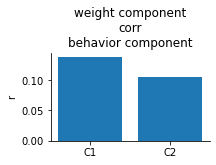

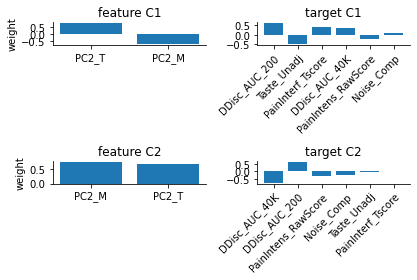

In [6]:
# figsize0 = (3.2, 2.4)
# figsize = (10, 10)
# n_trg = 10  # 取权重排前n_trg的target进行显示
# vis_name = 'MMP-vis3-R'
# fname = f'weight-CCA-beh_{vis_name}_v5'

# figsize0 = (3.2, 2.4)
# figsize = (7, 5)
# n_trg = 10  # 取权重排前n_trg的target进行显示
# vis_name = 'MMP-vis3-R'
# fname = f'weight-CCA-beh_{vis_name}_v8'

figsize0 = (3.2, 2.4)
# figsize = (3.5, 4)
# n_trg = 2  # 取权重排前n_trg的target进行显示
# figsize = (5.3, 4)
# n_trg = 5
figsize = (5.9, 4)
n_trg = 6
# figsize = (6, 4)
# n_trg = 9
# figsize = (7, 4)
# n_trg = 12
# figsize = (7.5, 4)
# n_trg = 13
# figsize = (7.5, 4)
# n_trg = 15
vis_name = 'MMP-vis3-R'
fname = f'weight-CCA-beh_{vis_name}_v34'

fpath = pjoin(anal_dir, f'fit/{fname}.pkl')
out_file0 = pjoin(work_dir, f'{fname}0.jpg')
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

cca_dict = pkl.load(open(fpath, 'rb'))
n_component = cca_dict['X_trans'].shape[1]
components = [f'C{i}' for i in range(1, n_component+1)]
print('corr(X_trans, Y_trans):')
print(1 - cdist(cca_dict['X_trans'].T, cca_dict['Y_trans'].T, 'correlation'))

fig0, ax0 = plt.subplots(1, 1, figsize=figsize0)
XC_YC_rs = [pearsonr(cca_dict['X_trans'][:, i], cca_dict['Y_trans'][:, i])[0]
            for i in range(n_component)]
x0 = np.arange(n_component)
ax0.bar(x0, XC_YC_rs)
ax0.set_title('weight component\ncorr\nbehavior component')
ax0.set_xticks(x0)
ax0.set_xticklabels(components)
ax0.set_ylabel('r')
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

fig, axes = plt.subplots(n_component, 2, figsize=figsize)
x1 = np.arange(len(cca_dict['feature names']))
x2 = np.arange(n_trg)
for c_idx, c_name in enumerate(components):
    ax1 = axes[c_idx, 0]
    w1 = cca_dict['model'].x_rotations_[:, c_idx]
    indices1 = np.argsort(np.abs(w1))[::-1]
    xticklabels1 = [cca_dict['feature names'][i] for i in indices1]
    xticklabels1 = [f"P{i.rstrip('_weight')}" for i in xticklabels1]
    ax1.bar(x1, w1[indices1])
    ax1.set_title(f'feature {c_name}')
    ax1.set_ylabel('weight')
    ax1.set_xticks(x1)
    ax1.set_xticklabels(xticklabels1)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)

    ax2 = axes[c_idx, 1]
    w2 = cca_dict['model'].y_rotations_[:, c_idx]
    indices2 = np.argsort(np.abs(w2))[::-1][:n_trg]
    xticklabels2 = []
    for idx2 in indices2:
        beh = cca_dict['target names'][idx2]
        if beh in beh_name2abbr.keys():
            beh = beh_name2abbr[beh]
        xticklabels2.append(beh)
    ax2.bar(x2, w2[indices2])
    ax2.set_title(f'target {c_name}')
    ax2.set_xticks(x2)
    ax2.set_xticklabels(xticklabels2)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    plt.setp(ax2.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

fig0.tight_layout()
fig.tight_layout()
if out_file == 'show':
    fig0.show()
    fig.show()
else:
    fig0.savefig(out_file0)
    fig.savefig(out_file)

## PC12_fit_func3

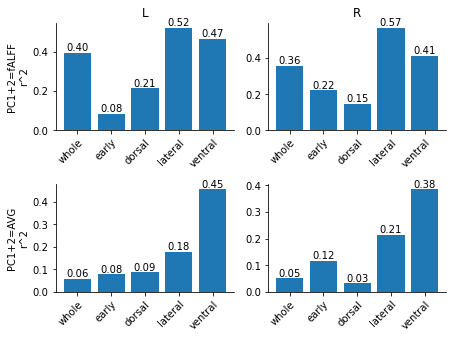

In [2]:
Hemis = ('L', 'R')
figsize = (6.4, 4.8)
title = 'PC1+2=func3'
trg_names = ['fALFF', 'AVG']
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

n_trg = len(trg_names)
n_Hemi = len(Hemis)
fig, axes = plt.subplots(n_trg, n_Hemi, figsize=figsize)
for Hemi_idx, Hemi in enumerate(Hemis):
    vis_name = f'MMP-vis3-{Hemi}'
    fpath = pjoin(anal_dir, f'fit/{title}_{Hemi}.pkl')
    data = pkl.load(open(fpath, 'rb'))
    xticklabels = ['whole'] + \
        [i.split('-')[-1] for i in data['row_name'][1:]]
    x = np.arange(len(xticklabels))
    for trg_idx, trg_name in enumerate(trg_names):
        ax = axes[trg_idx, Hemi_idx]
        col_idx = data['col_name'].index(trg_name)
        y = data['r'][:, col_idx] ** 2
        rects = ax.bar(x, y)
        show_bar_value(rects, '.2f', ax=ax)
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        if Hemi_idx == 0:
            ax.set_ylabel(f'PC1+2={trg_name}\nr^2')
        if trg_idx == 0:
            ax.set_title(Hemi)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

## PC12_fit_func4

### fit goodneess

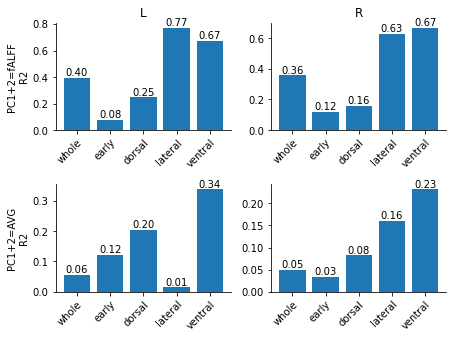

In [2]:
Hemis = ('L', 'R')
figsize = (6.4, 4.8)
title = 'PC1+2=func4'
trg_names = ['fALFF', 'AVG']
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

n_trg = len(trg_names)
n_Hemi = len(Hemis)
fig, axes = plt.subplots(n_trg, n_Hemi, figsize=figsize)
for Hemi_idx, Hemi in enumerate(Hemis):
    vis_name = f'MMP-vis3-{Hemi}'
    fpath = pjoin(anal_dir, f'fit/{title}_{Hemi}.pkl')
    data = pkl.load(open(fpath, 'rb'))
    xticklabels = ['whole'] + \
        [i.split('-')[-1] for i in data['row_name'][1:]]
    x = np.arange(len(xticklabels))
    for trg_idx, trg_name in enumerate(trg_names):
        ax = axes[trg_idx, Hemi_idx]
        col_idx = data['col_name'].index(trg_name)
        y = data['R2'][:, col_idx]
        rects = ax.bar(x, y)
        show_bar_value(rects, '.2f', ax=ax)
        ax.set_xticks(x)
        ax.set_xticklabels(xticklabels)
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")
        if Hemi_idx == 0:
            ax.set_ylabel(f'PC1+2={trg_name}\nR2')
        if trg_idx == 0:
            ax.set_title(Hemi)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

fig.tight_layout()
if out_file == 'show':
    fig.show()
else:
    fig.savefig(out_file)

### PC1 and PC2 weights

L-('fALFF', 'whole') weights: [-0.00676368 -0.00280487]
L-('AVG', 'ventral') weights: [-15.33880674  11.49658361]
R-('fALFF', 'whole') weights: [-0.00670771 -0.00307683]
R-('AVG', 'ventral') weights: [-9.72032765  5.83136692]


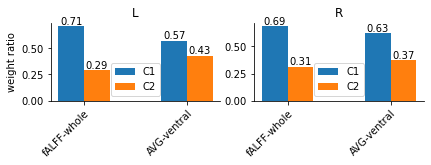

In [8]:
Hemis = ('L', 'R')
figsize = (6, 2.4)
title = 'PC1+2=func4'
trg_mask_pairs = (('fALFF', 'whole'), ('AVG', 'ventral'))
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

n_Hemi = len(Hemis)
ys = []
labels = []
xticklabels = tuple('-'.join(i) for i in trg_mask_pairs)
for Hemi in Hemis:
    vis_name = f'MMP-vis3-{Hemi}'
    fpath = pjoin(anal_dir, f'fit/{title}_{Hemi}.pkl')
    data = pkl.load(open(fpath, 'rb'))
    n_pc = data['weight'].shape[-1]
    labels.append(tuple(f'C{i}' for i in range(1, n_pc+1)))
    y = np.zeros((n_pc, len(trg_mask_pairs)))
    for tm_idx, trg_mask in enumerate(trg_mask_pairs):
        trg_name, mask_name = trg_mask
        if mask_name == 'whole':
            mask_name = vis_name
        else:
            mask_name = f'{vis_name}-{mask_name}'
        row_idx = data['row_name'].index(mask_name)
        col_idx = data['col_name'].index(trg_name)
        y[:, tm_idx] = data['weight'][row_idx, col_idx]
        print(f'{Hemi}-{trg_mask} weights:', data['weight'][row_idx, col_idx])
    y = np.abs(y) / np.sum(np.abs(y), 0, keepdims=True)
    ys.append(y)

plot_bar(ys, 1, 2, figsize,  yerr=None, x=None, width=None,
         label=labels, color=None, fc_ec_flag=False, fc=None, ec=None,
         show_height='.2f', xlabel=None, xticklabel=xticklabels,
         rotate_xticklabel=True, ylabel='weight ratio', ylim=None,
         title=Hemis, mode=out_file)

## HCPDA_MT_fit_PC12_SW

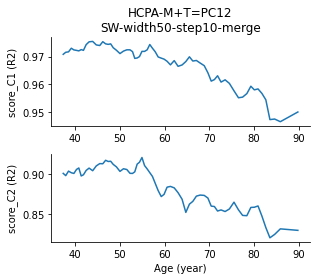

In [5]:
fname1 = 'HCPA-M+T=PC12'
fname2 = 'SW-width50-step10-merge'
figsize = (4.5, 4)
out_file = pjoin(work_dir, f'{fname1}_{fname2}_score.jpg')

fpath = pjoin(anal_dir, f'fit/{fname1}_{fname2}.pkl')
data = pkl.load(open(fpath, 'rb'))
labels = ['C1', 'C2']
x = data['age in months'] / 12
xs = [x, x]
ys = [data[f'score_{i}'] for i in labels]
ylabels = [f'score_{i} (R2)' for i in labels]
plot_line(x=xs, y=ys, n_row=2, n_col=1, figsize=figsize, xlabel='Age (year)',
          ylabel=ylabels, title=f'{fname1}\n{fname2}', mode=out_file)

## HCPD-M+T=C1C2.csv

### 现有的column

#### 以年为单位

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


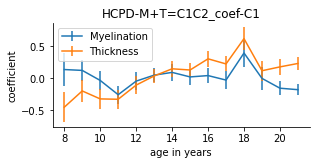

In [19]:
# load data
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = ['coef_C1_Myelination', 'coef_C1_Thickness']
labels = ('Myelination', 'Thickness')
ylabel='coefficient'
title = f'{fname}_coef-C1'

# cols = ['score_C1']
# labels = None
# ylabel='R2'
# title = f'{fname}_score-C1'

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# get valid subjects
# outlier_vec1 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-myelin_MMP-vis3-R_RSM-IQR3.npy'))
# outlier_vec2 = np.load(pjoin(anal_dir, f'outlier/{dataset_name}-thickness_MMP-vis3-R_RSM-IQR3.npy'))
# non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
# data = data[:, non_outlier_vec]
# ages = ages[non_outlier_vec]
# ages_uniq = np.unique(ages)

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, zscore_flag=zscore_flag, out_dict=True
)
plot_line(
    y=prepare_y_bar_line(y_dict, key_groups), figsize=figsize,
    yerr=prepare_y_bar_line(yerr_dict, key_groups), x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel
)


#### 以年龄窗口为单位

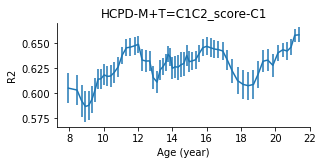

In [10]:
# load data
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
asw = AgeSlideWindow(dataset_name, 50, 10, True)
age_name = 'Age (year)'

# prepare plot contents
# cols = ['coef_C1_Myelination', 'coef_C1_Thickness']
# labels = ('Myelination', 'Thickness')
# ylabel='coefficient'
# title = f'{fname}_coef-C1'

cols = ['score_C1']
labels = None
ylabel='R2'
title = f'{fname}_score-C1'

n_col = len(cols)
data = np.array(df[cols])
figsize = (4.5, 2.4)
x = np.zeros(asw.n_win)
y = np.zeros((n_col, asw.n_win))
yerr = np.zeros((n_col, asw.n_win))
for win_idx in range(asw.n_win):
    win_id = win_idx + 1
    indices = asw.get_subj_indices(win_id)
    samples = data[indices]
    x[win_idx] = np.mean(asw.get_ages(win_id, 'year'))
    y[:, win_idx] = np.mean(samples, 0)
    yerr[:, win_idx] = sem(samples, 0)

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=x, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel
)


### (|M|-|T|)/(|M|+|T|)

Warning! The sample size of value-6 is 5.
Warning! The sample size of value-7 is 5.


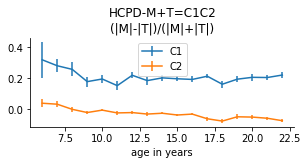

In [9]:
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

figsize = (4.5, 2.4)
labels = ('C1', 'C2')
data = np.zeros((len(labels), df.shape[0]), np.float64)
for lbl_idx, lbl in enumerate(labels):
    m = np.abs(df[f'coef_{lbl}_Myelination'])
    t = np.abs(df[f'coef_{lbl}_Thickness'])
    data[lbl_idx, :] =  (m - t) / (m + t)
title = f'{fname}\n(|M|-|T|)/(|M|+|T|)'
out_file = pjoin(work_dir, f'{fname}_MT-diff.jpg')
# out_file = 'show'

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq,
    label=labels, xlabel=age_name, title=title, mode=out_file
)


### |M|-|T|

Warning! The sample size of value-6 is 4.
Warning! The sample size of value-7 is 5.


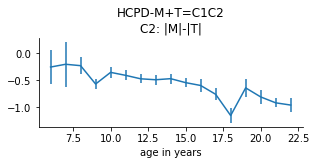

In [12]:
# load data
fname = 'HCPD-M+T=C1C2'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
age_name = 'age in years'
ages = pd.read_csv(dataset_name2info['HCPD'])[age_name]
ages_uniq = np.unique(ages)

# prepare plot contents
figsize = (4.5, 2.4)
lbl = 'C2'
data = np.zeros((1, df.shape[0]), np.float64)
m = np.abs(df[f'coef_{lbl}_Myelination'])
t = np.abs(df[f'coef_{lbl}_Thickness'])
data[0, :] =  m - t
title = f'{fname}\n{lbl}: |M|-|T|'
out_file = pjoin(work_dir, f'{fname}_MT-diff-{lbl}.jpg')
# out_file = 'show'

# get valid subjects
outlier_vec1 = np.load(pjoin(anal_dir, 'outlier/HCPD-myelin_MMP-vis3-R_RSM-IQR3.npy'))
outlier_vec2 = np.load(pjoin(anal_dir, 'outlier/HCPD-thickness_MMP-vis3-R_RSM-IQR3.npy'))
non_outlier_vec = ~np.logical_or(outlier_vec1, outlier_vec2)
data = data[:, non_outlier_vec]
ages = ages[non_outlier_vec]
ages_uniq = np.unique(ages)

y, yerr = summary_across_col_by_mask(data, ages, ages_uniq, ['mean', 'sem'])
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, xlabel=age_name,
    title=title, mode=out_file
)

## CalcS+OcPole+MT=C1.csv

score: 0.22387787046567784


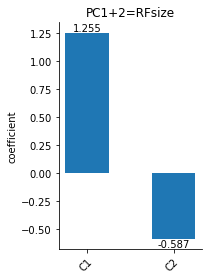

In [14]:
# fname = 'CalcS+OcPole+MT=C1'
# fname = 'CalcS+MT=C1'
# fname = 'OcPole+MT=C1'
fname = 'PC1+2=RFsize'
trg_name = 'RFsize'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df[f'score_{trg_name}'].item())
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith(f'coef_{trg_name}_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=out_file)

## CS+OpMt=C1C2.csv

score: 0.049836449998593824


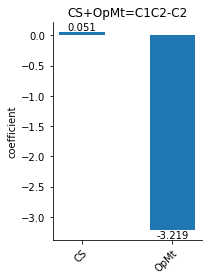

In [16]:
fname = 'CS+OpMt=C1C2'
trg_name = 'C2'
title = f'{fname}-{trg_name}'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score:', df[f'score_{trg_name}'].item())
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith(f'coef_{trg_name}_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 4), show_height='.3f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=title, mode=out_file)

## PC1+2=fALFF_ind.csv

score: 0.21015780590137687±0.002423204638360952


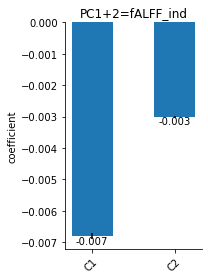

In [4]:
fname = 'PC1+2=fALFF_ind'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print('score: {0}±{1}'.format(np.mean(df['score']), sem(df['score'])))
out_file = pjoin(work_dir, f'{fname}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith('coef_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
coef_data = np.array(df[coef_names])
y = np.mean(coef_data, 0)
yerr = sem(coef_data, 0)
plot_bar(y=y, figsize=(3, 4), show_height='.3f', yerr=yerr,
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=fname, mode=out_file)

## Mean8+Tau+Diff=C1C2.csv

score_C1: 0.9636226915861064


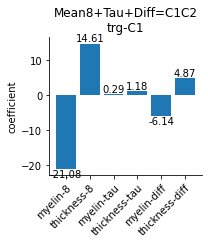

In [9]:
fname = 'Mean8+Tau+Diff=C1C2'
# fname = 'Mean8=C1C2'
pc_num = 'C1'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))
print(f'score_{pc_num}:', df[f'score_{pc_num}'].item())
out_file = pjoin(work_dir, f'{fname}_{pc_num}.jpg')
# out_file = 'show'

coef_names = [i for i in df.columns if i.startswith(f'coef_{pc_num}_')]
feat_names = tuple(i.split('_')[-1] for i in coef_names)
plot_bar(y=np.array(df.loc[0, coef_names]), figsize=(3, 3.5), show_height='.2f',
         xticklabel=feat_names, rotate_xticklabel=True, ylabel='coefficient',
         title=f'{fname}\ntrg-{pc_num}', mode=out_file)

## HCPD-M+T=C1C2_local-mask1-N3-R.csv

[ 5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 8  9 10 11 12 13 14 15 16 17 18 19 20 21]


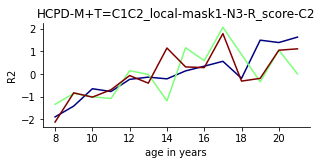

In [6]:
# load data
N = 3
dataset_name = 'HCPD'
fname = f'{dataset_name}-M+T=C1C2_local-mask1-N{N}-R'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = [f'score_C2-{i}' for i in range(1, N+1)]
labels = tuple(i[-1] for i in cols)
labels = None
ylabel='R2'
title = f'{fname}_score-C2'
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, N)
colors = tuple(cmap(color_indices[i]) for i in range(N))

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, out_dict=True
)

if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel, color=colors
)


## HCPD/A-M+T=C1C2_MMP-vis3-R-EDMV

[ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 100]
[ 36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
 100]
Warning! The sample size of value-50 is 5.
Warning! The sample size of value-63 is 7.
Warning! The sample size of value-67 is 8.
Warning! The sample size of value-68 is 9.
Warning! The sample size of value-73 is 9.
Warning! The sample size of value-76 is 8.
Warning! The sample size of value-79 is 8.
Warning! The sample size of value-83 is 8.
Warning! The sample size of value-86 is 7.
Warning! The sample size of value-87 is 5.
Warning! The sample size of value-88 is 6.
Warning! The sample size of value-89 is 5.


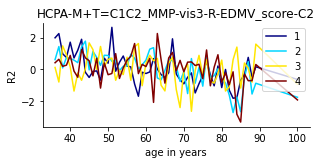

In [9]:
# load data
N = 4
dataset_name = 'HCPA'
fname = f'{dataset_name}-M+T=C1C2_MMP-vis3-R-EDMV'
df = pd.read_csv(pjoin(anal_dir, f'fit/{fname}.csv'))

# get age information
info_file = pjoin(proj_dir, f'data/HCP/{dataset_name}_SubjInfo.csv')
age_name = 'age in years'
ages = pd.read_csv(info_file)[age_name]
ages_uniq = np.unique(ages)
print(ages_uniq)
if dataset_name == 'HCPD':
    ages_uniq = ages_uniq[3:]
print(ages_uniq)

# prepare plot contents
cols = [f'score_C2-{i}' for i in range(1, N+1)]
labels = tuple(i[-1] for i in cols)
# labels = None
ylabel='R2'
title = f'{fname}_score-C2'
cmap = plt.cm.jet
color_indices = np.linspace(0, 1, N)
colors = tuple(cmap(color_indices[i]) for i in range(N))

data = np.array(df[cols]).T
figsize = (4.5, 2.4)
zscore_flag = True
key_groups = [cols]

# prepare out information
out_file = pjoin(work_dir, f'{title}.jpg')
# out_file = 'show'

# start
y_dict, yerr_dict = summary_across_col_by_mask(
    data=data, mask=ages, values=ages_uniq, metrics=['mean', 'sem'],
    nan_mode=False, row_names=cols, out_dict=True
)

if zscore_flag:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = None
    y = [zscore(i, 1) for i in y]
else:
    y = prepare_y_bar_line(y_dict, key_groups)
    yerr = prepare_y_bar_line(yerr_dict, key_groups)
plot_line(
    y=y, figsize=figsize, yerr=yerr, x=ages_uniq, label=labels,
    xlabel=age_name, title=title, mode=out_file, ylabel=ylabel, color=colors
)


## HCPD-M+T=C1C2_local-mask1-N3-R_AgeFitCol1.csv

remove 5/6/7
1 -0.016687421542859245
2 -0.03041684690858722
3 -0.025287467139545758


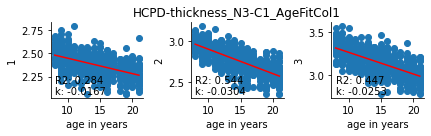

In [5]:
# data_name = 'HCPD'
# age_name = 'age in years'
# src_file1 = pjoin(anal_dir, f'fit/{data_name}-M+T=C1C2_local-mask1-N3-R_AgeFitCol1.csv')
# src_file2 = pjoin(anal_dir, f'fit/{data_name}-M+T=C1C2_local-mask1-N3-R.csv')
# info_file = pjoin(proj_dir, f'data/HCP/{data_name}_SubjInfo.csv')
# indices = ['score_C1-1', 'score_C1-2', 'score_C1-3', 'score_C2-1', 'score_C2-2', 'score_C2-3']
# n_row, n_col = 2, 3
# figsize = (9, 6)
# out_file = pjoin(work_dir, f'{data_name}-M+T=C1C2_local-mask1-N3-R.jpg')

data_name = 'HCPD'
age_name = 'age in years'
fname1 = f'{data_name}-thickness_N3-C1_AgeFitCol1'
src_file1 = pjoin(anal_dir, f'fit/{fname1}.csv')
src_file2 = pjoin(anal_dir, f'ROI_scalar/{data_name}-thickness_N3-C1.csv')
info_file = pjoin(proj_dir, f'data/HCP/{data_name}_SubjInfo.csv')
# indices = [i for i in range(1, 10)]
# n_row, n_col = 3, 3
# figsize = (6, 4)
indices = [i for i in range(1, 4)]
n_row, n_col = 1, 3
figsize = (6, 2)
out_file = pjoin(work_dir, f'{fname1}.jpg')

# out_file = None

df1 = pd.read_csv(src_file1, index_col=0)
df2 = pd.read_csv(src_file2)
info_df = pd.read_csv(info_file)
ages = np.array(info_df[age_name])
if data_name == 'HCPD':
    print('remove 5/6/7')
    idx_vec = np.zeros_like(ages, bool)
    for i in (5, 6, 7):
        idx_vec = np.logical_or(ages == i, idx_vec)
    idx_vec = ~idx_vec
    ages = ages[idx_vec]
    df2 = df2.loc[idx_vec]
ages_uniq = np.unique(ages)

fig, axes = plt.subplots(n_row, n_col, figsize=figsize)
if axes.shape != (n_row, n_col):
    axes = axes.reshape((n_row, n_col))
for idx, index in enumerate(indices):
    row_idx = int(idx / n_col)
    col_idx = idx % n_col
    ax = axes[row_idx, col_idx]
    ax.scatter(ages, df2[str(index)])
    y = ages_uniq * df1.loc[index, 'coef'] + df1.loc[index, 'intercept']
    ax.plot(ages_uniq, y, color='r')
    ax.set_ylabel(index)
    if row_idx == 0 and col_idx == int(n_col/2):
        ax.set_title(fname1)
    if row_idx == n_row-1:
        ax.set_xlabel(age_name)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    text_x = np.min(ages)
    text_y = np.min(df2[str(index)])
    text_s = 'R2: {:.3f}\nk: {:.4f}'.format(df1.loc[index, 'score'], df1.loc[index, 'coef'])
    ax.text(text_x, text_y, text_s)
    print(index, df1.loc[index, 'coef'])

fig.tight_layout()
if out_file is None:
    fig.show()
else:
    fig.savefig(out_file)